This part of the project has the goal of cleaning our final dataset and check for some correlations between features. We will prepare the final dataset for clustering.

In [22]:
#%load_ext nb_black

# Library to suppress warnings or deprecation notes
!pip install scikit-learn
!pip install geopy
!pip install folium
!pip install pdfkit
!pip install geopandas

import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.manifold import TSNE
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import math
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
import datetime
from sklearn.impute import KNNImputer
import plotly.express as px
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy import stats
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.metrics import make_scorer, silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram
from sklearn.model_selection import GridSearchCV

In [ ]:
df = pd.read_csv('df_featureselection_preprocessing.csv', sep = ',')


: 

In [ ]:
df.head()

Loyalty#  PointsRedeemedRatio  FlightsWithCompanionsRatio  \
0    100018             0.387904                    0.200000   
1    100102             0.553363                    0.224490   
2    100140             0.113362                    0.241706   
3    100214             0.354092                    0.157407   
4    100272             0.253580                    0.276243   

   AvgDistancePerFlight  KMPerRedeemedPoint  UnredeemedPoints  LoyaltyIndex  \
0           2356.577778           25.786888             32446    709.589704   
1           1384.141224           18.077435             15141    418.130598   
2           2047.539336           88.241585             38293    616.640254   
3           3375.941667           28.248369             23544   1014.088728   
4           2373.649171           39.448214             32058    714.181936   

                       CustomerSegment  HasBonus  AvgMonthlyFlights  ...  \
0  Moderate traveler and high redeemed         0           6.250000  ...   
1        Low traveler and low redeemed         0           6.805556  ...   
2   Moderate traveler and low redeemed         0           5.861111  ...   
3      High traveler and high redeemed         0           3.000000  ...   
4  Moderate traveler and high redeemed         0           5.027778  ...   

   Education   Income  Marital Status  LoyaltyStatus  EnrollmentMonth  \
0   Bachelor  82877.0         Married         Aurora                8   
1    College      0.0          Single           Nova                3   
2    College      0.0        Divorced           Nova                7   
3   Bachelor  42837.0         Married           Star                8   
4   Bachelor  80979.0        Divorced           Star                1   

   Time on Program  Cancelled  Reenroll  EnrollmentType  \
0         874 days          N         0        Standard   
1        2122 days          N         0        Standard   
2         884 days          N         0        Standard   
3        1242 days          N         0        Standard   
4        1816 days          N         0        Standard   

   Customer Lifetime Value  
0                  7919.20  
1                  2887.74  
2                  2838.07  
3                  4170.57  
4                  6622.05  

[5 rows x 34 columns]

: 

In [ ]:
# Convert to timedelta first
df['Time on Program'] = pd.to_timedelta(df['Time on Program'], errors='coerce')

# Convert to numeric days (overwrite the same column)
df['Time on Program'] = df['Time on Program'].dt.days

: 

                            Loyalty#  PointsRedeemedRatio  \
Loyalty#                    1.000000             0.003496   
PointsRedeemedRatio         0.003496             1.000000   
FlightsWithCompanionsRatio -0.002895             0.251326   
AvgDistancePerFlight        0.010949             0.034202   
KMPerRedeemedPoint         -0.004014            -0.067838   
UnredeemedPoints           -0.006881            -0.214582   
LoyaltyIndex                0.010940             0.034692   
HasBonus                    0.003978             0.515537   
AvgMonthlyFlights          -0.003419             0.061508   
sr_jan                      0.004087             0.057628   
sr_feb                     -0.006276             0.024619   
sr_mar                     -0.013685             0.044332   
sr_apr                      0.002944             0.039042   
sr_may                      0.006809             0.034793   
sr_jun                     -0.022908             0.049173   
sr_jul                  

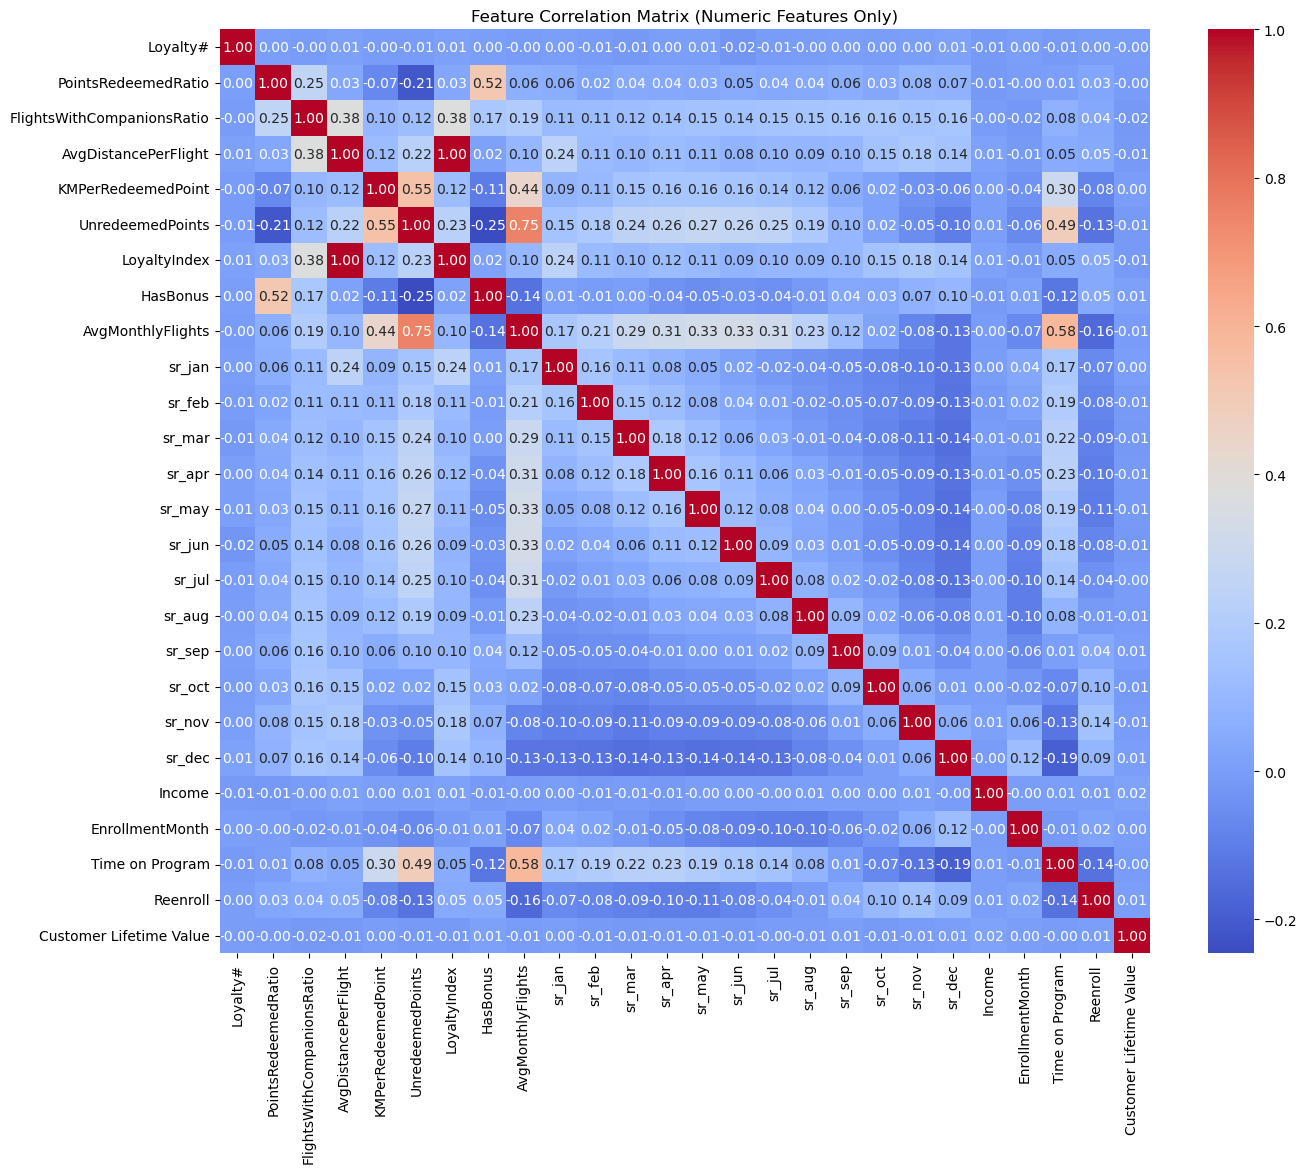

: 

In [ ]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Display correlation matrix
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(15,12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Matrix (Numeric Features Only)")
plt.show()


The correlations between numerical features are moderate and 

In [ ]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Find rows where any numeric column is negative
negative_rows = df[(df[numeric_cols] < 0).any(axis=1)]

# Display the result
print(f"Number of rows with negative values: {len(negative_rows)}")
print(negative_rows)

Number of rows with negative values: 0
Empty DataFrame
Columns: [PointsRedeemedRatio, FlightsWithCompanionsRatio, AvgDistancePerFlight, KMPerRedeemedPoint, UnredeemedPoints, LoyaltyIndex, CustomerSegment, HasBonus, AvgMonthlyFlights, sr_jan, sr_feb, sr_mar, sr_apr, sr_may, sr_jun, sr_jul, sr_aug, sr_sep, sr_oct, sr_nov, sr_dec, Province or State, Education, Income, Marital Status, LoyaltyStatus, EnrollmentMonth, Time on Program, Cancelled, Reenroll, EnrollmentType, Customer Lifetime Value]
Index: []

[0 rows x 32 columns]


: 

Categorical columns: Index(['CustomerSegment', 'Province or State', 'Education', 'Marital Status',
       'LoyaltyStatus', 'Cancelled', 'EnrollmentType'],
      dtype='object')
CustomerSegment vs Province or State: Chi2 = 20.58, p-value = 0.9005
CustomerSegment vs Education: Chi2 = 10.08, p-value = 0.6086
CustomerSegment vs Marital Status: Chi2 = 7.02, p-value = 0.3193


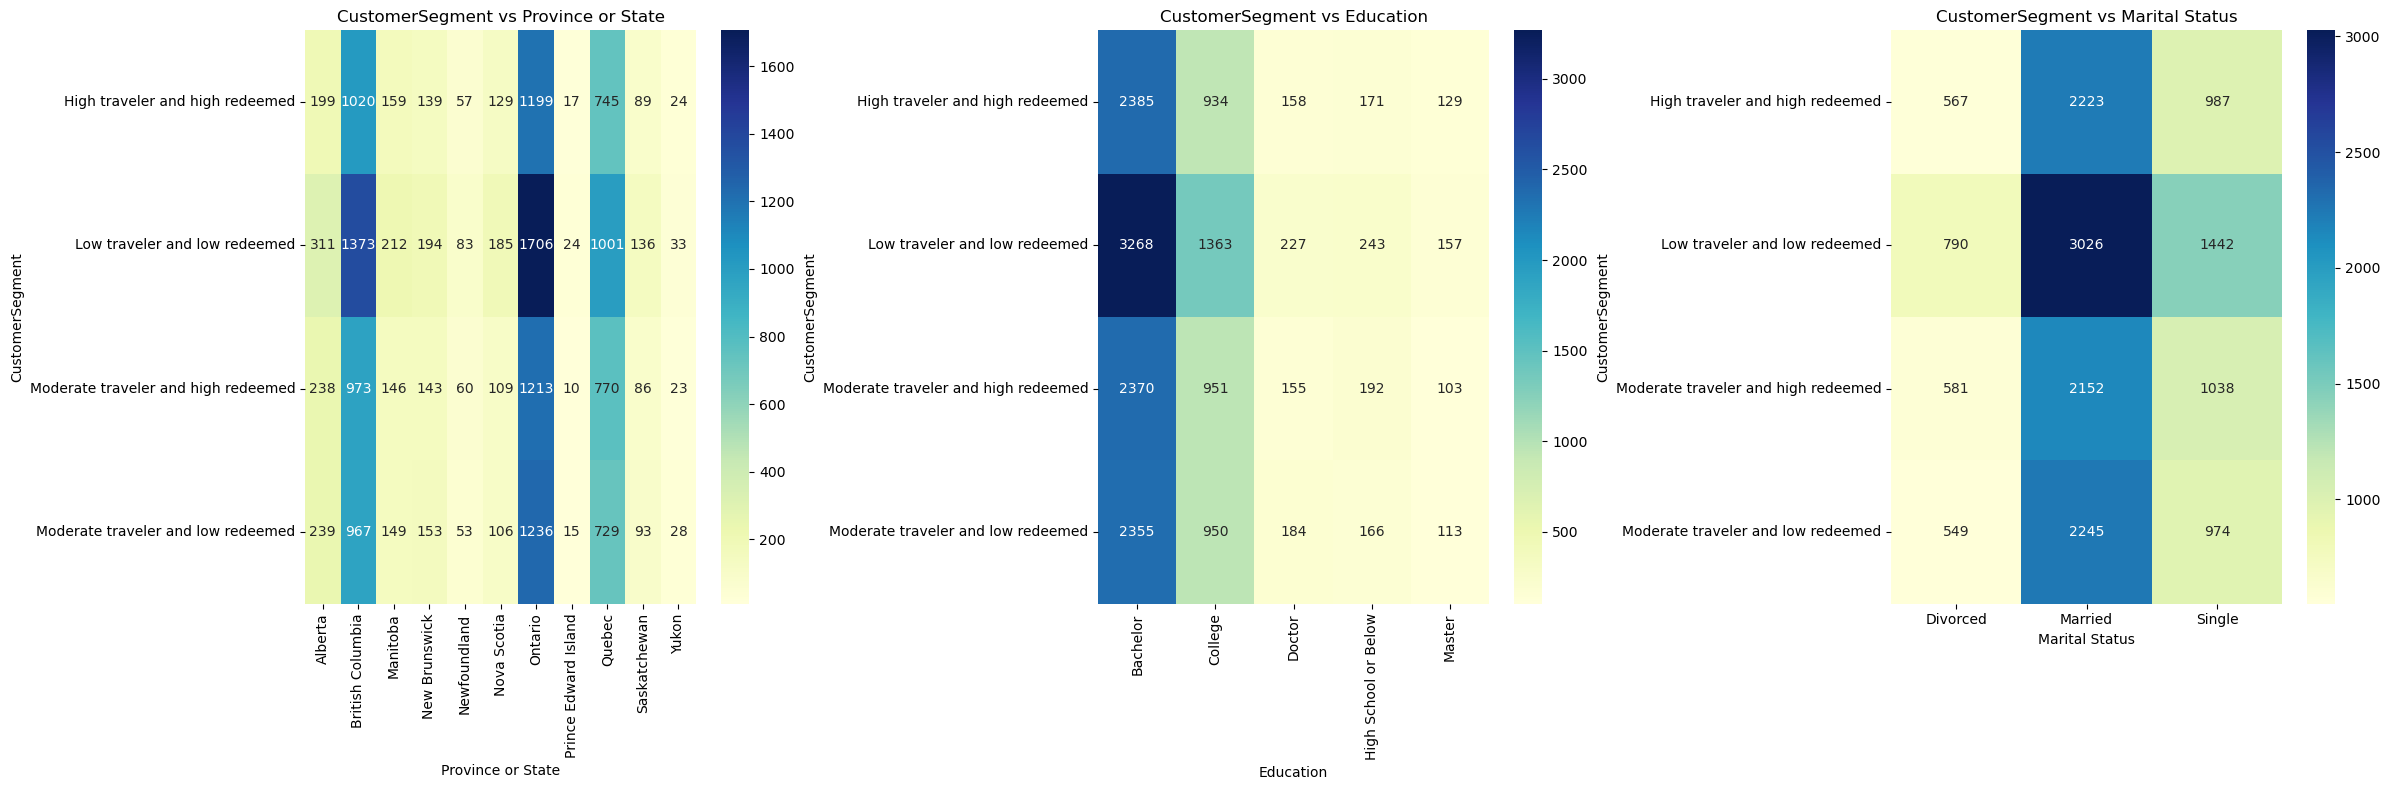

CustomerSegment vs LoyaltyStatus: Chi2 = 5.53, p-value = 0.4781
CustomerSegment vs Cancelled: Chi2 = 1154.33, p-value = 0.0000
CustomerSegment vs EnrollmentType: Chi2 = 2.29, p-value = 0.5138


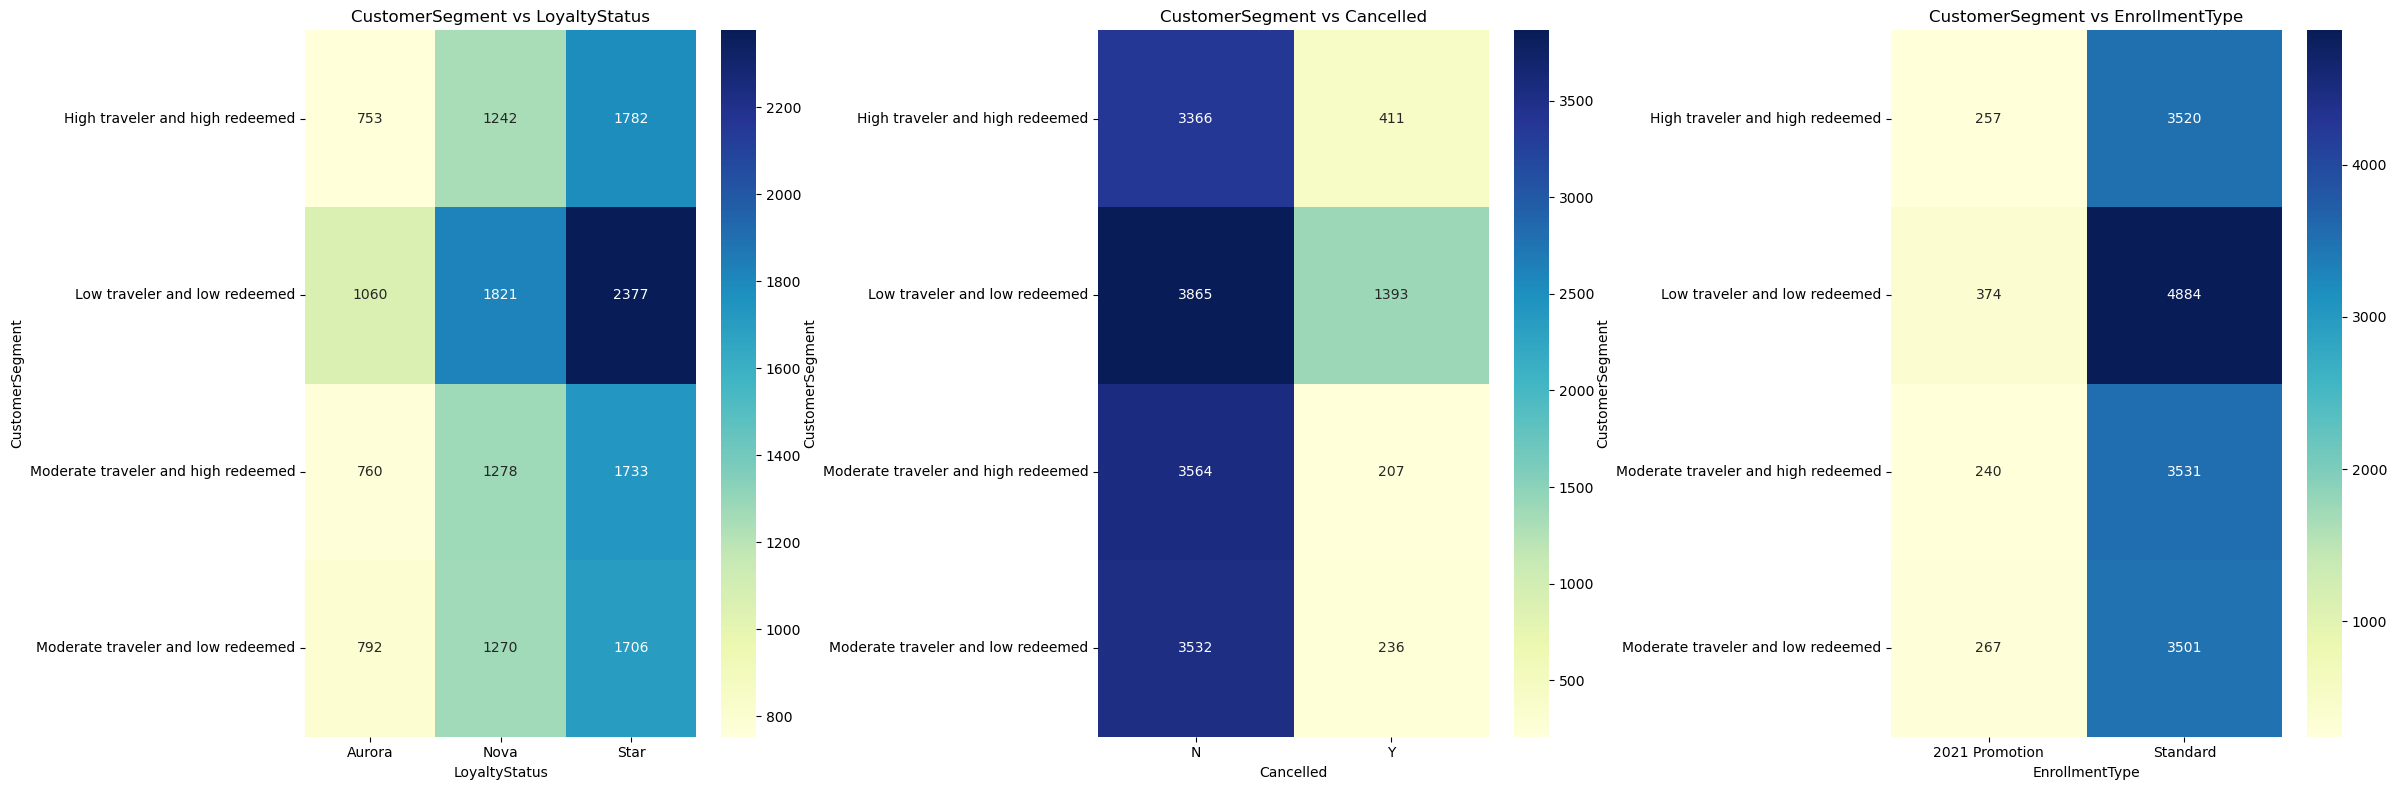

Province or State vs Education: Chi2 = 30.33, p-value = 0.8658
Province or State vs Marital Status: Chi2 = 13.90, p-value = 0.8355
Province or State vs LoyaltyStatus: Chi2 = 27.98, p-value = 0.1099


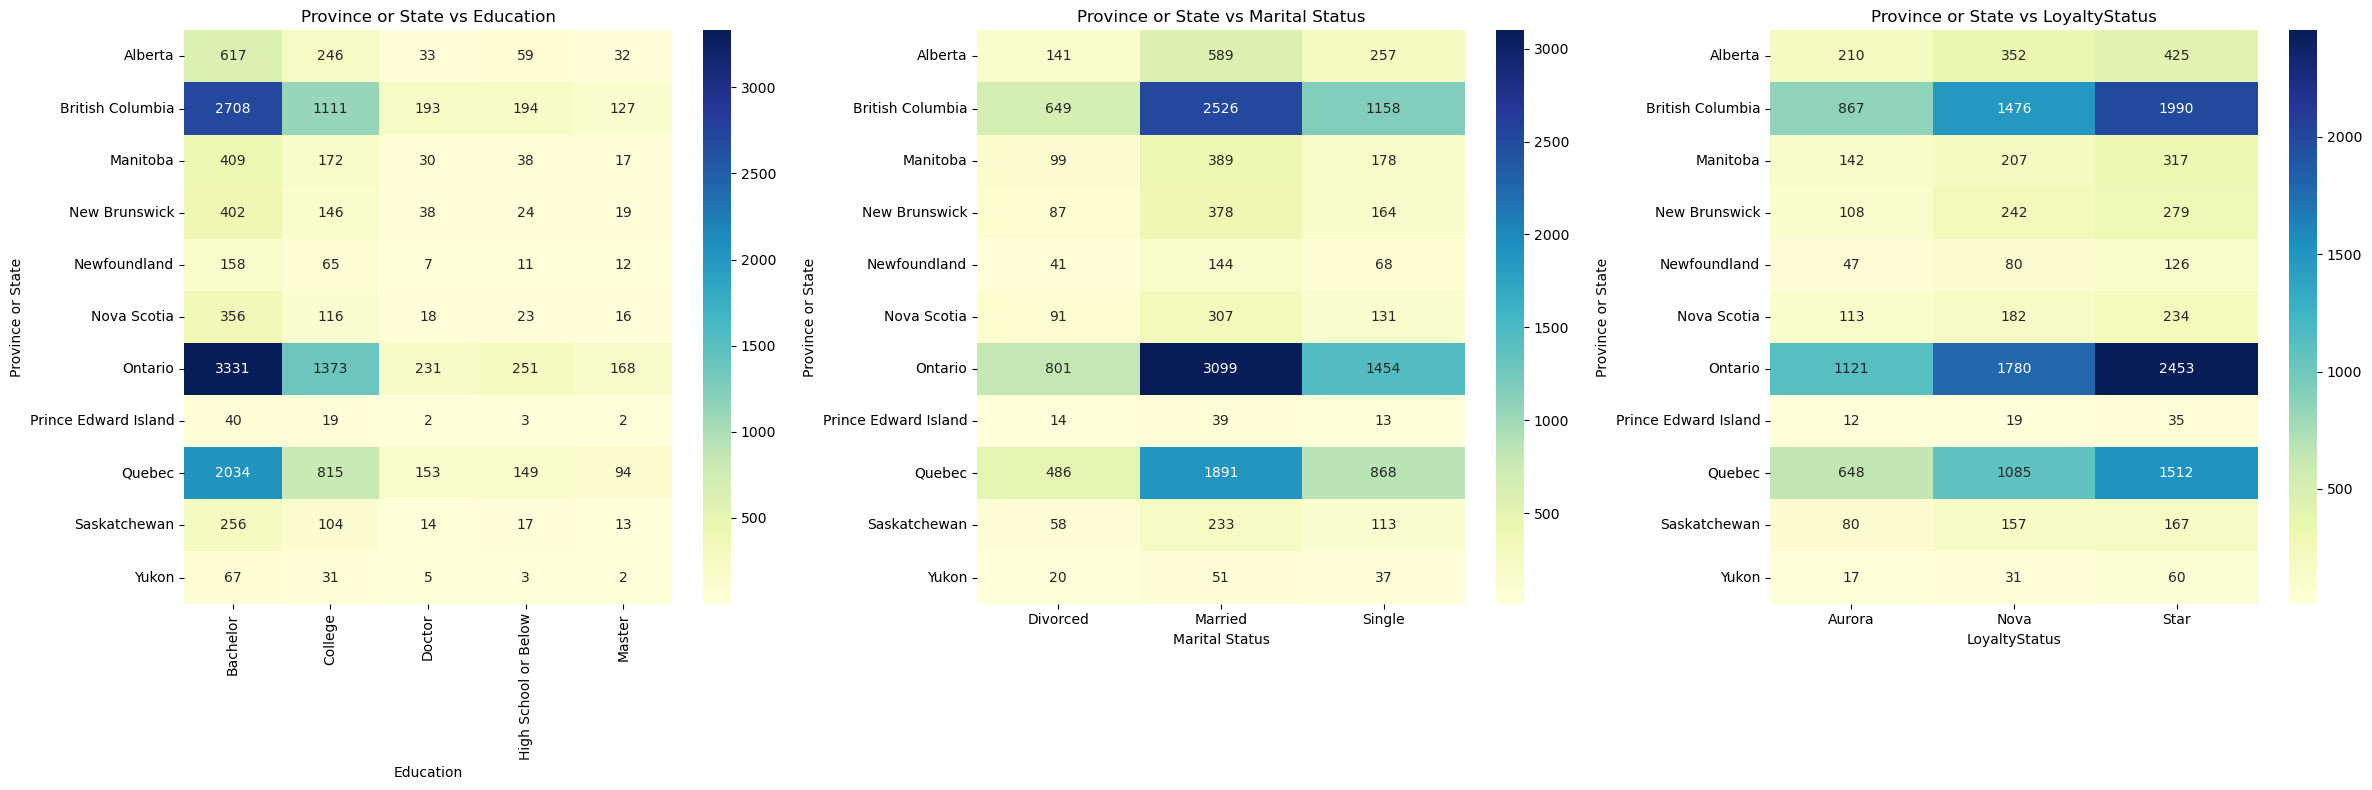

Province or State vs Cancelled: Chi2 = 16.89, p-value = 0.0769
Province or State vs EnrollmentType: Chi2 = 11.05, p-value = 0.3536
Education vs Marital Status: Chi2 = 2915.73, p-value = 0.0000


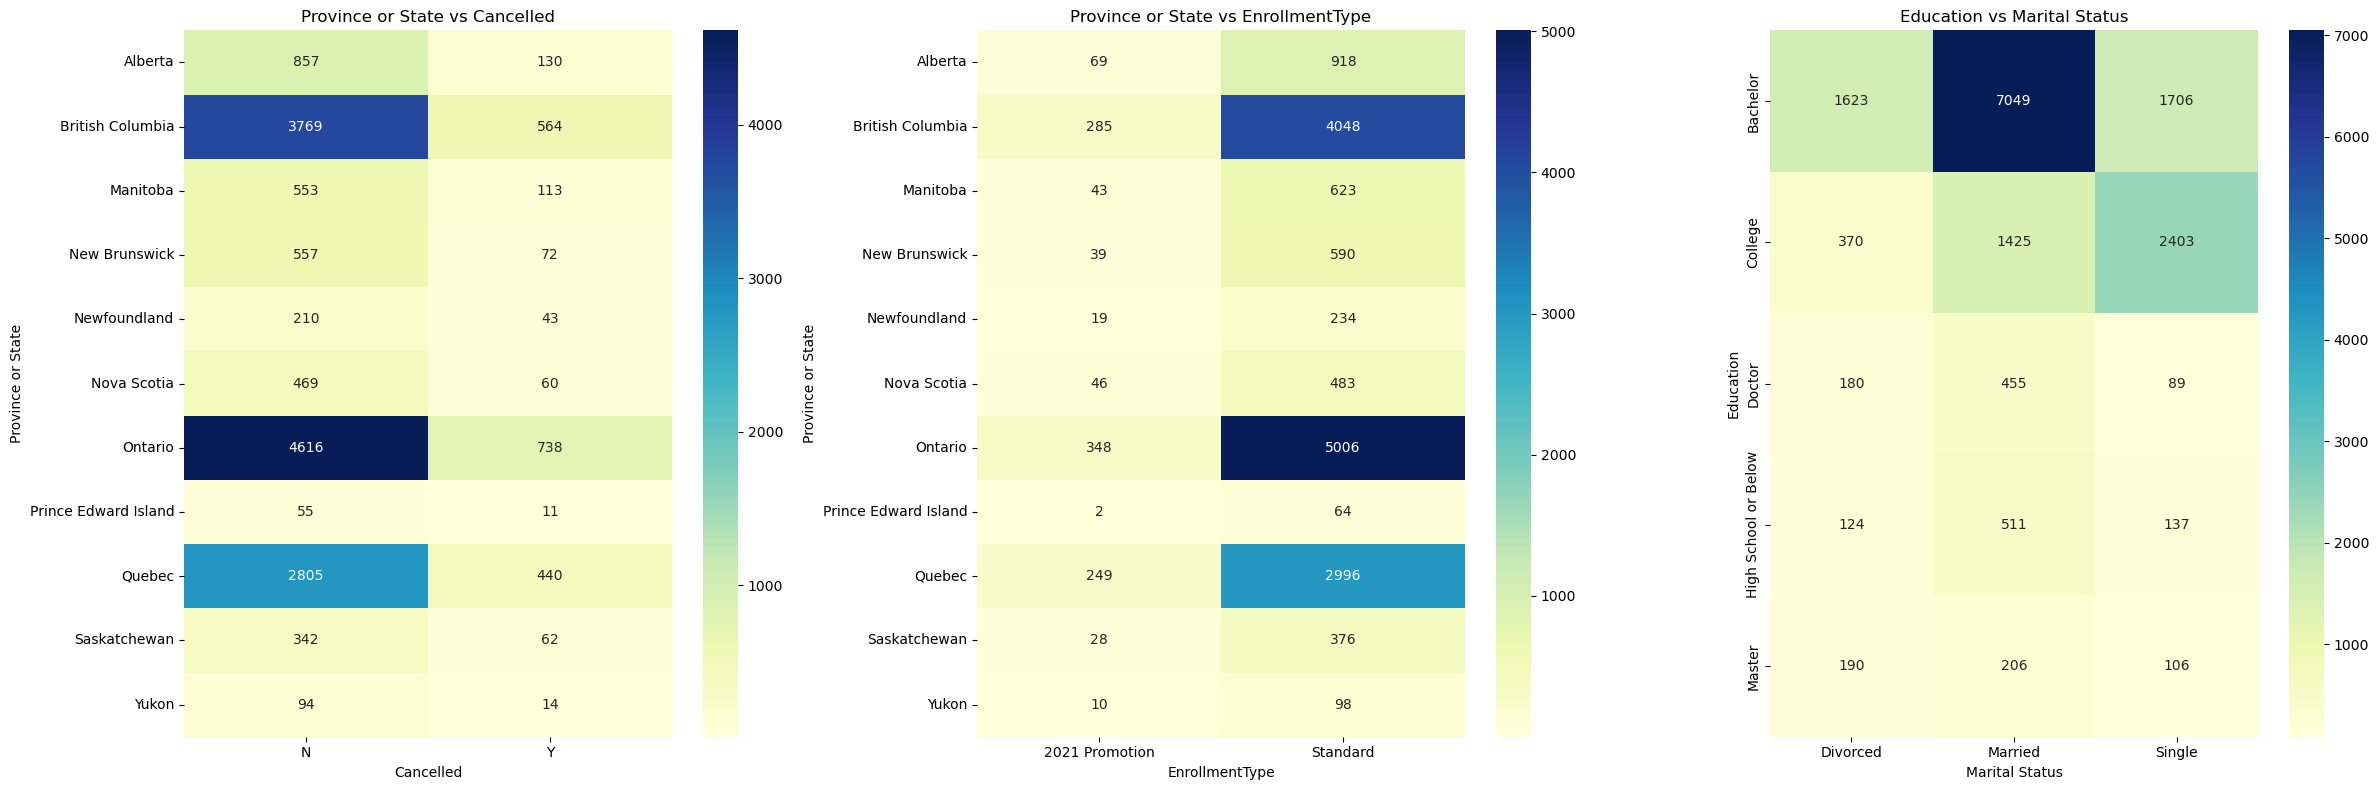

Education vs LoyaltyStatus: Chi2 = 88.80, p-value = 0.0000
Education vs Cancelled: Chi2 = 0.75, p-value = 0.9446
Education vs EnrollmentType: Chi2 = 4.02, p-value = 0.4030


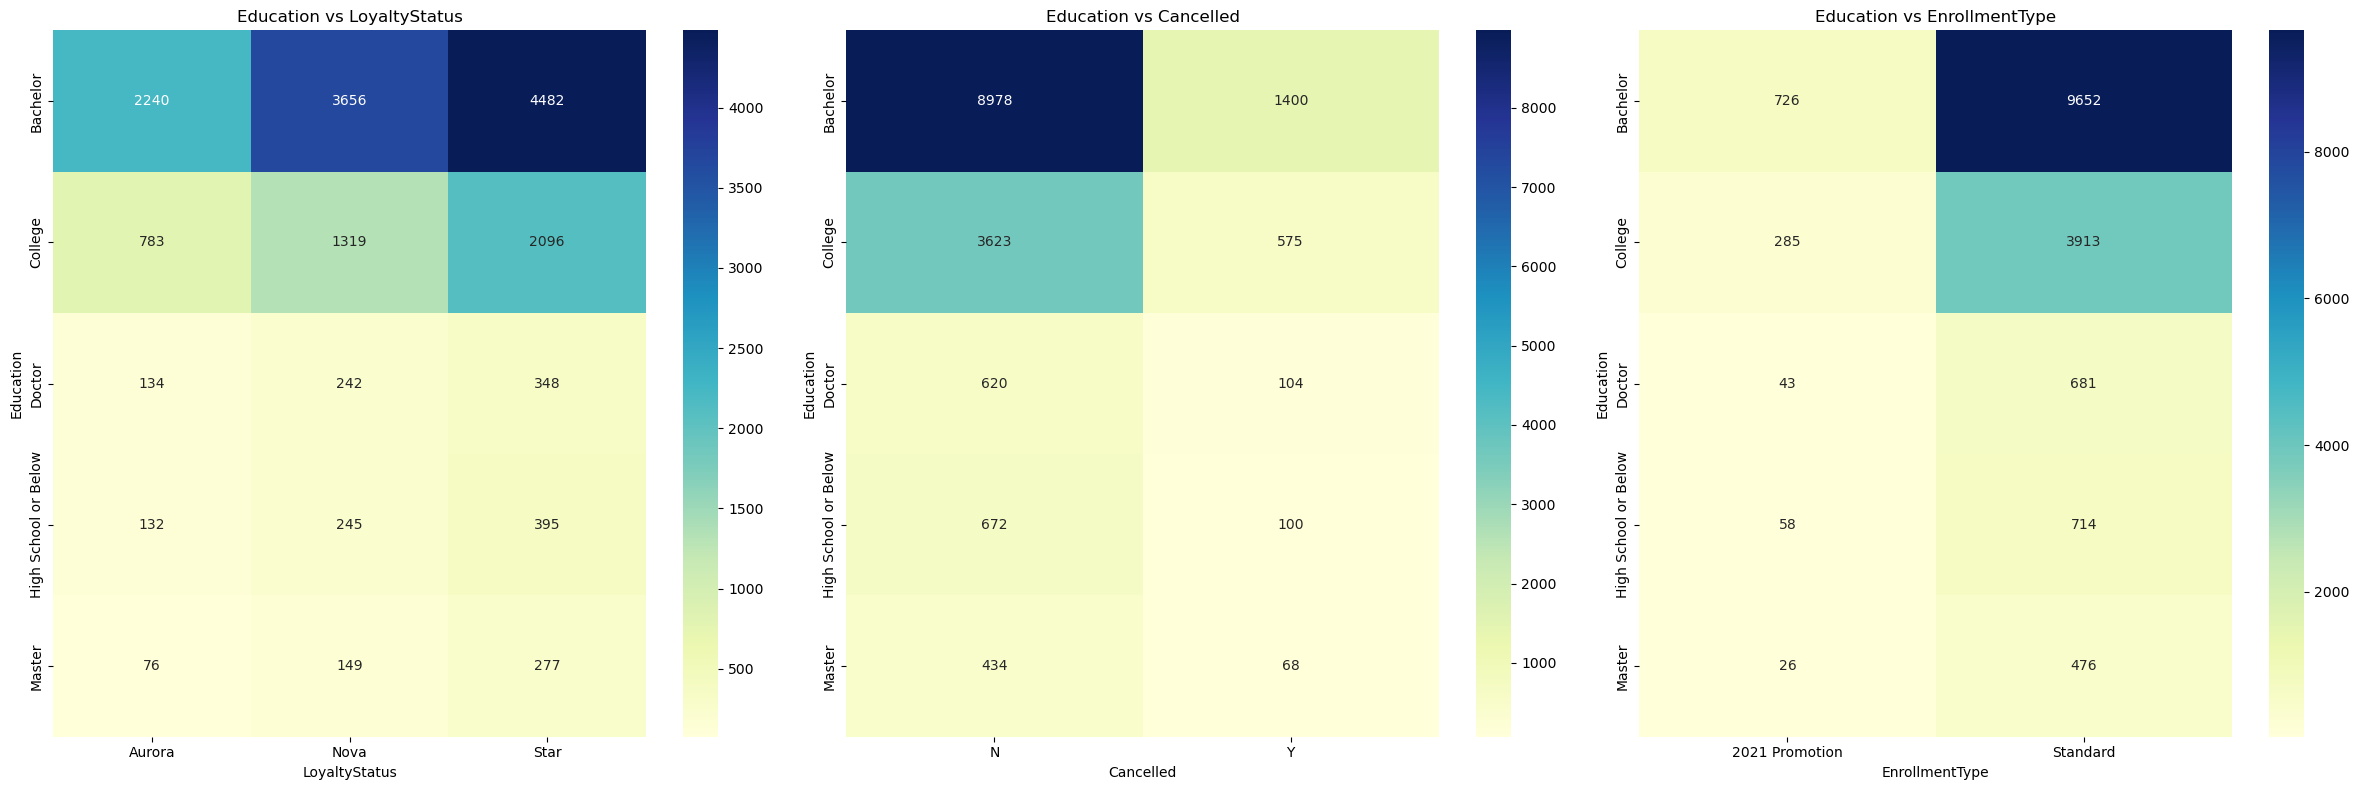

Marital Status vs LoyaltyStatus: Chi2 = 35.73, p-value = 0.0000
Marital Status vs Cancelled: Chi2 = 0.54, p-value = 0.7648
Marital Status vs EnrollmentType: Chi2 = 0.41, p-value = 0.8165


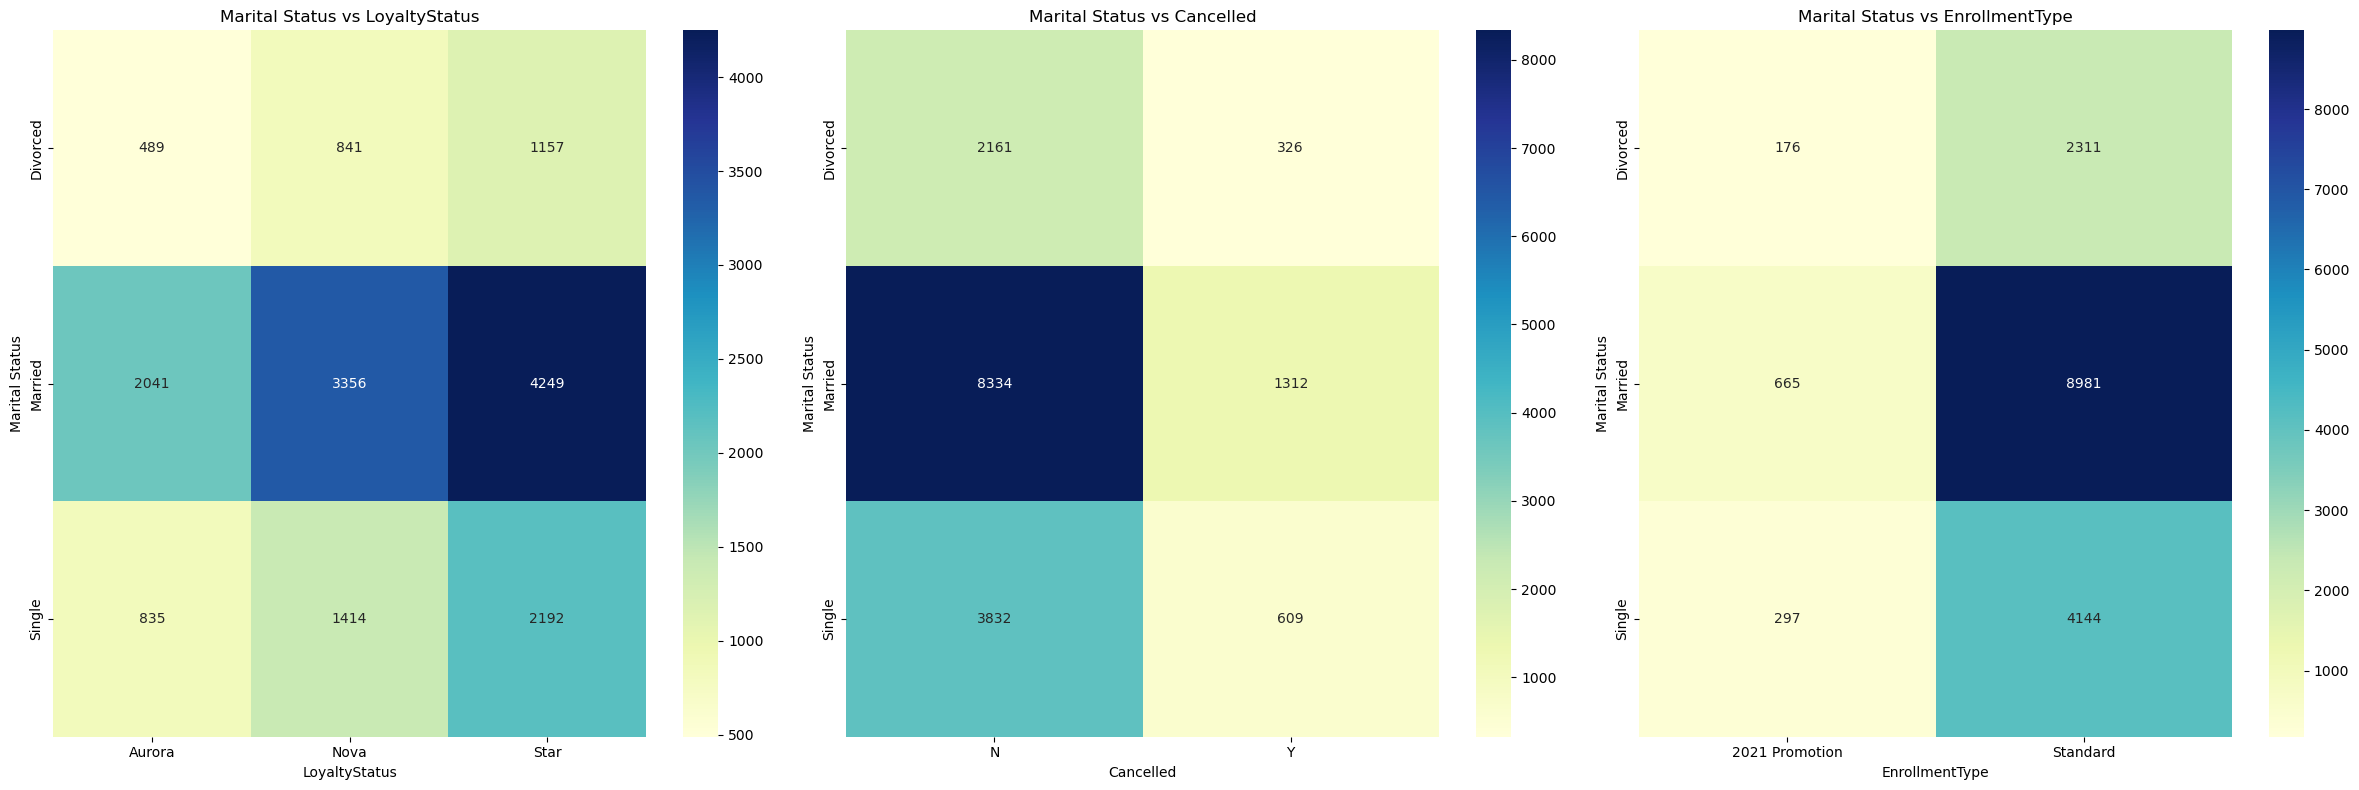

LoyaltyStatus vs Cancelled: Chi2 = 4.94, p-value = 0.0847
LoyaltyStatus vs EnrollmentType: Chi2 = 1.33, p-value = 0.5148
Cancelled vs EnrollmentType: Chi2 = 3.48, p-value = 0.0622


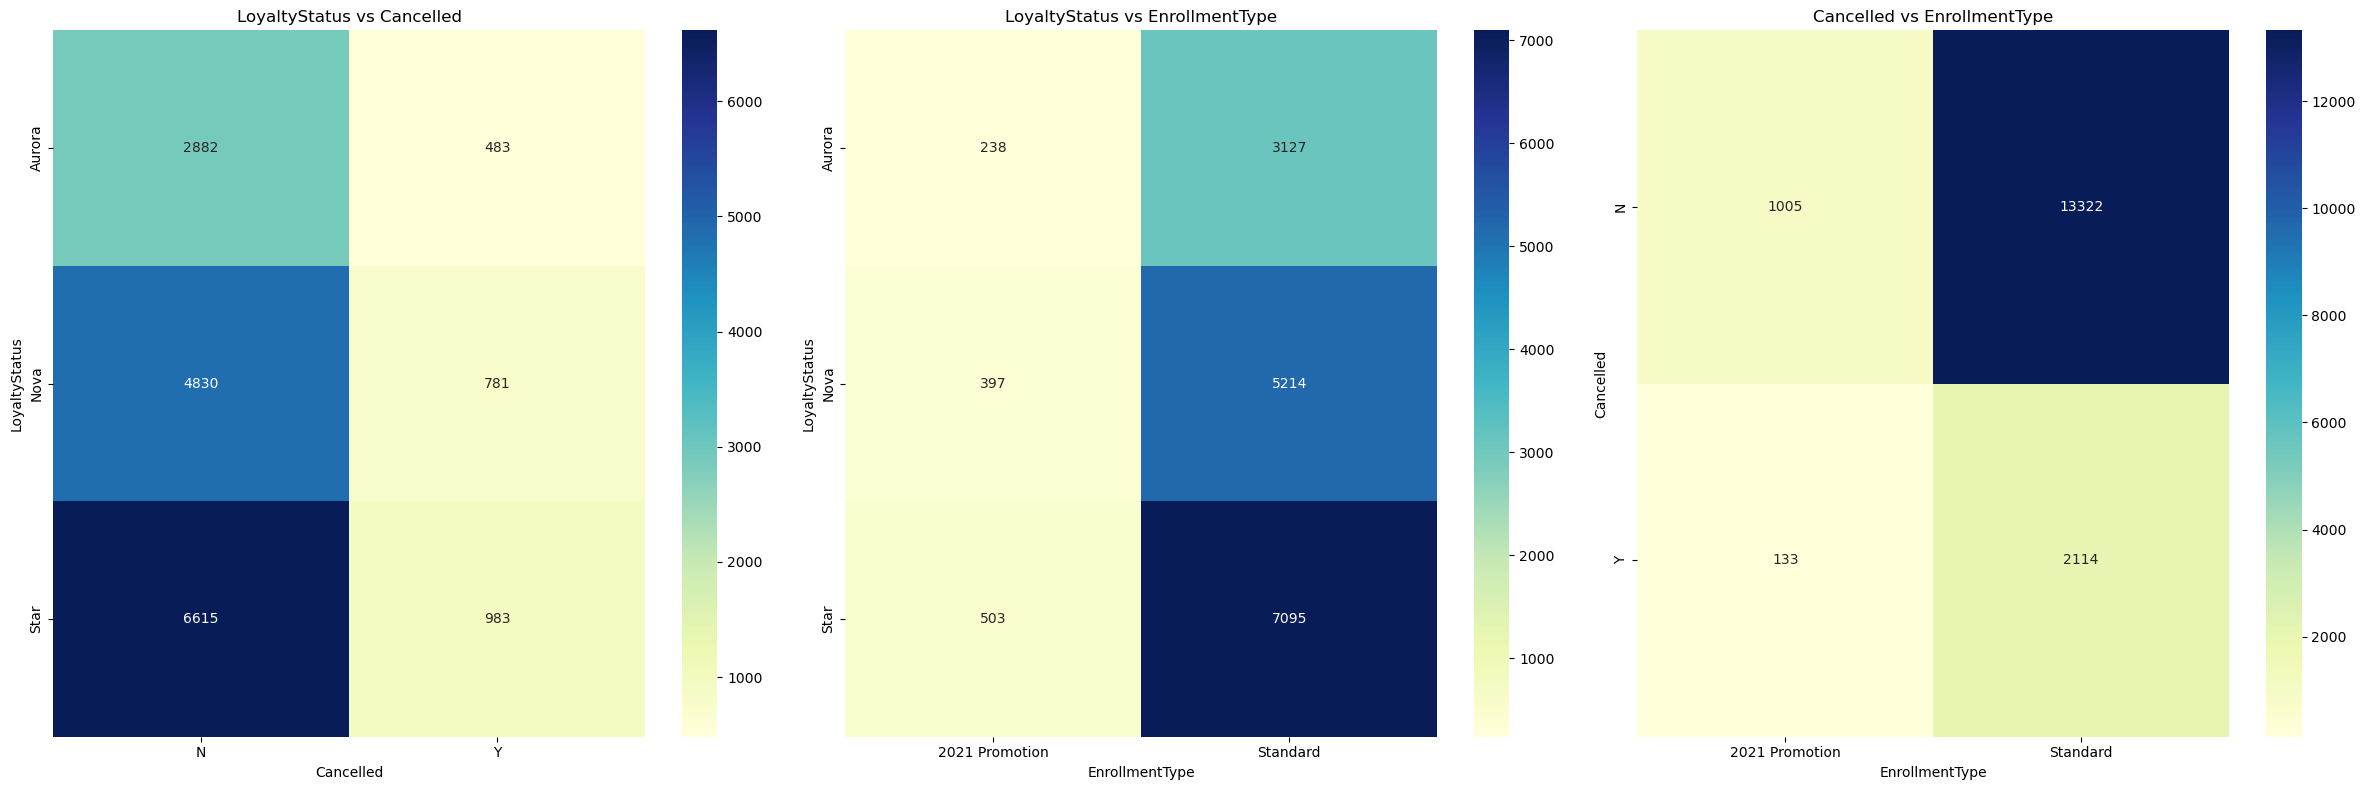

: 

In [ ]:
import itertools

categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_cols)

pairs = list(itertools.combinations(categorical_cols, 2))

for i in range(0, len(pairs), 3):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8)) 
    for j, ax in enumerate(axes):
        if i+j < len(pairs):
            col1, col2 = pairs[i+j]
            table = pd.crosstab(df[col1], df[col2])
            chi2, p, dof, _ = chi2_contingency(table)
            print(f"{col1} vs {col2}: Chi2 = {chi2:.2f}, p-value = {p:.4f}")
            
            sns.heatmap(table, annot=True, fmt='d', cmap='YlGnBu', ax=ax)
            ax.set_title(f"{col1} vs {col2}")
            ax.set_xlabel(col2)
            ax.set_ylabel(col1)
        else:
            ax.axis('off')  

    plt.tight_layout()
    plt.show()


In [ ]:
pairs = list(itertools.combinations(categorical_cols, 2))

p_zero_pairs = []

for col1, col2 in pairs:
    table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, _ = chi2_contingency(table)
    
    if p <= 0.05:
        p_zero_pairs.append((col1, col2))

print("Pairs with p-value <= 0.05 0:")
for pair in p_zero_pairs:
    print(pair)


Pairs with p-value <= 0.05 0:
('CustomerSegment', 'Cancelled')
('Education', 'Marital Status')
('Education', 'LoyaltyStatus')
('Marital Status', 'LoyaltyStatus')


: 

For now we will keep the four of them since they are not redudant, although they are correlated.

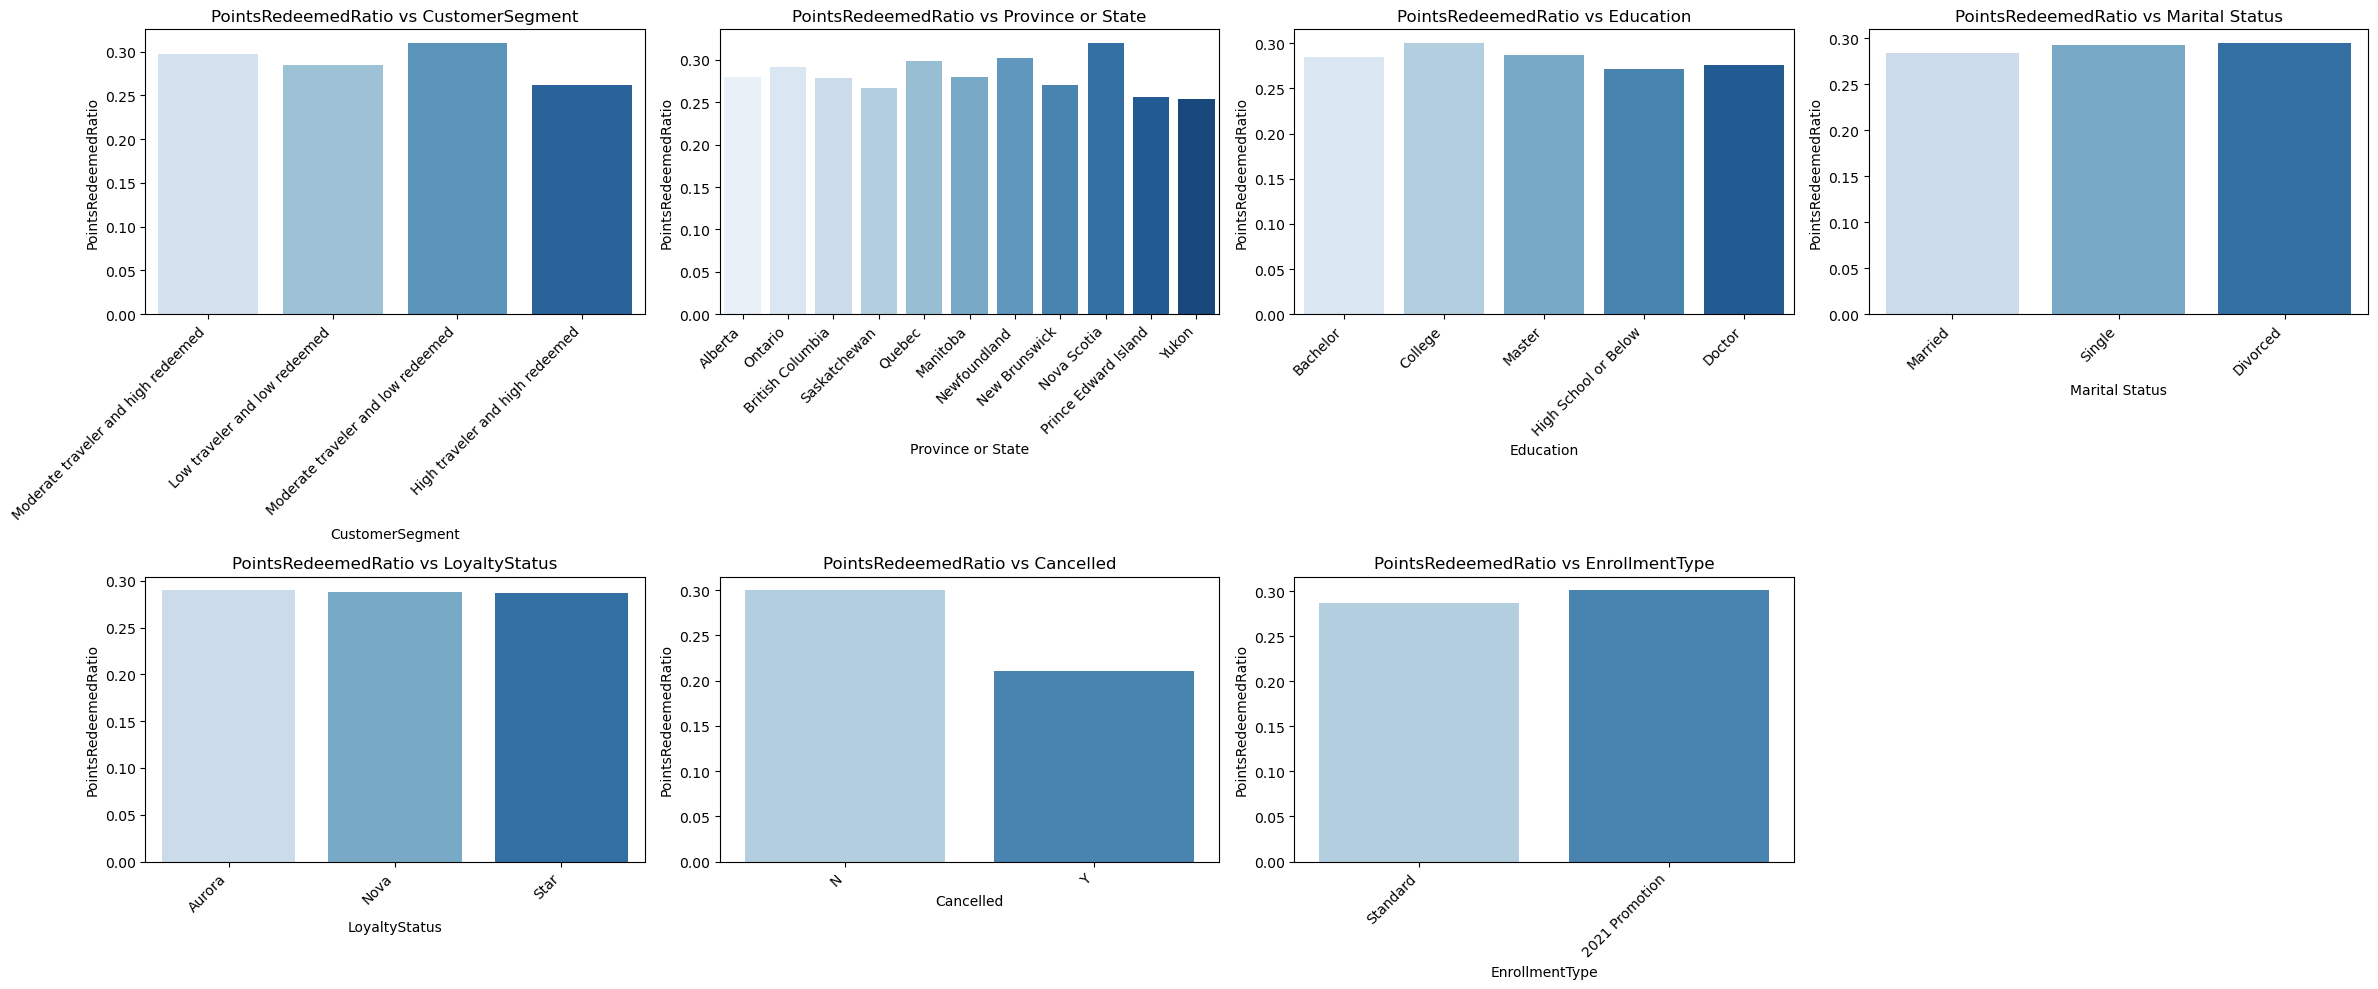

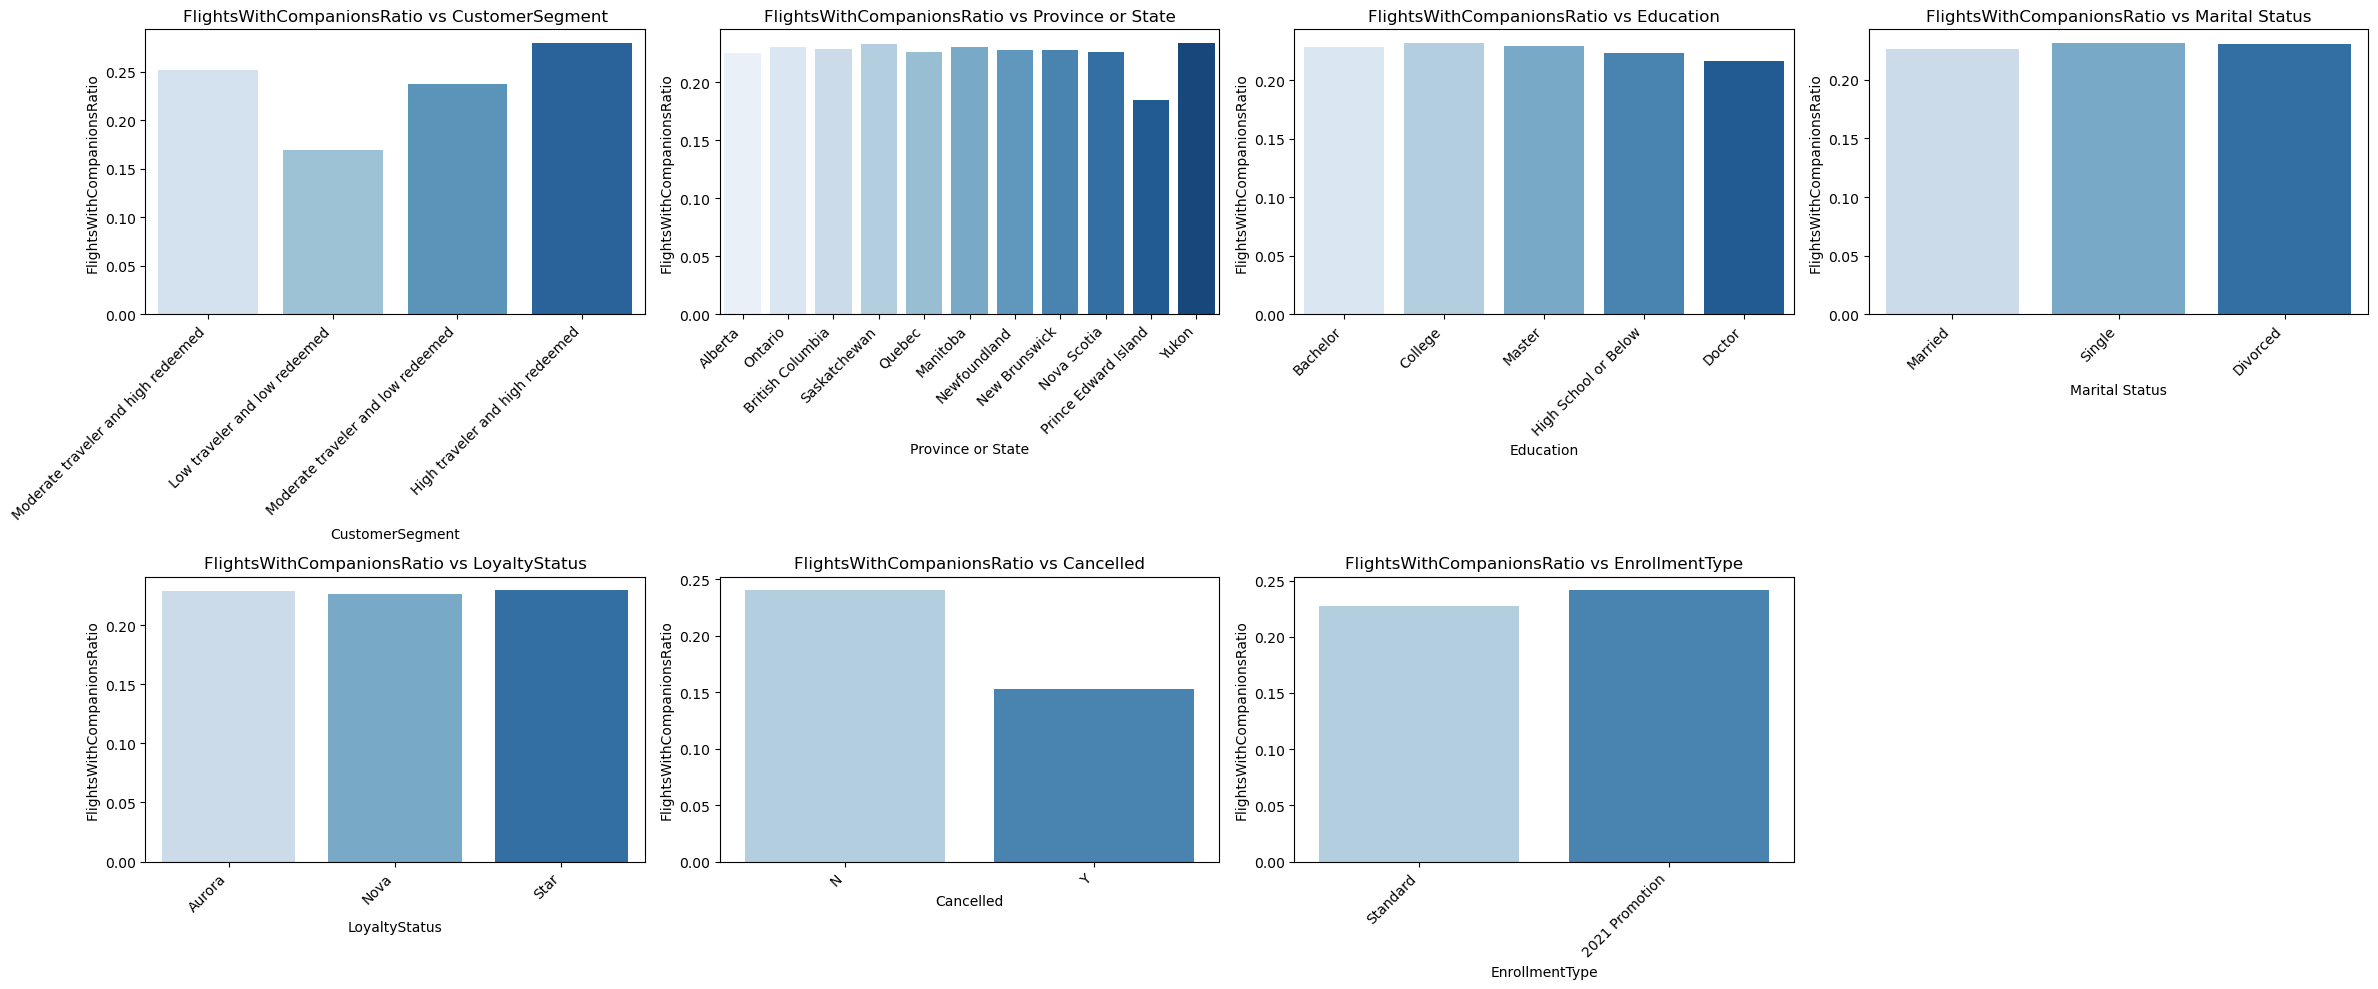

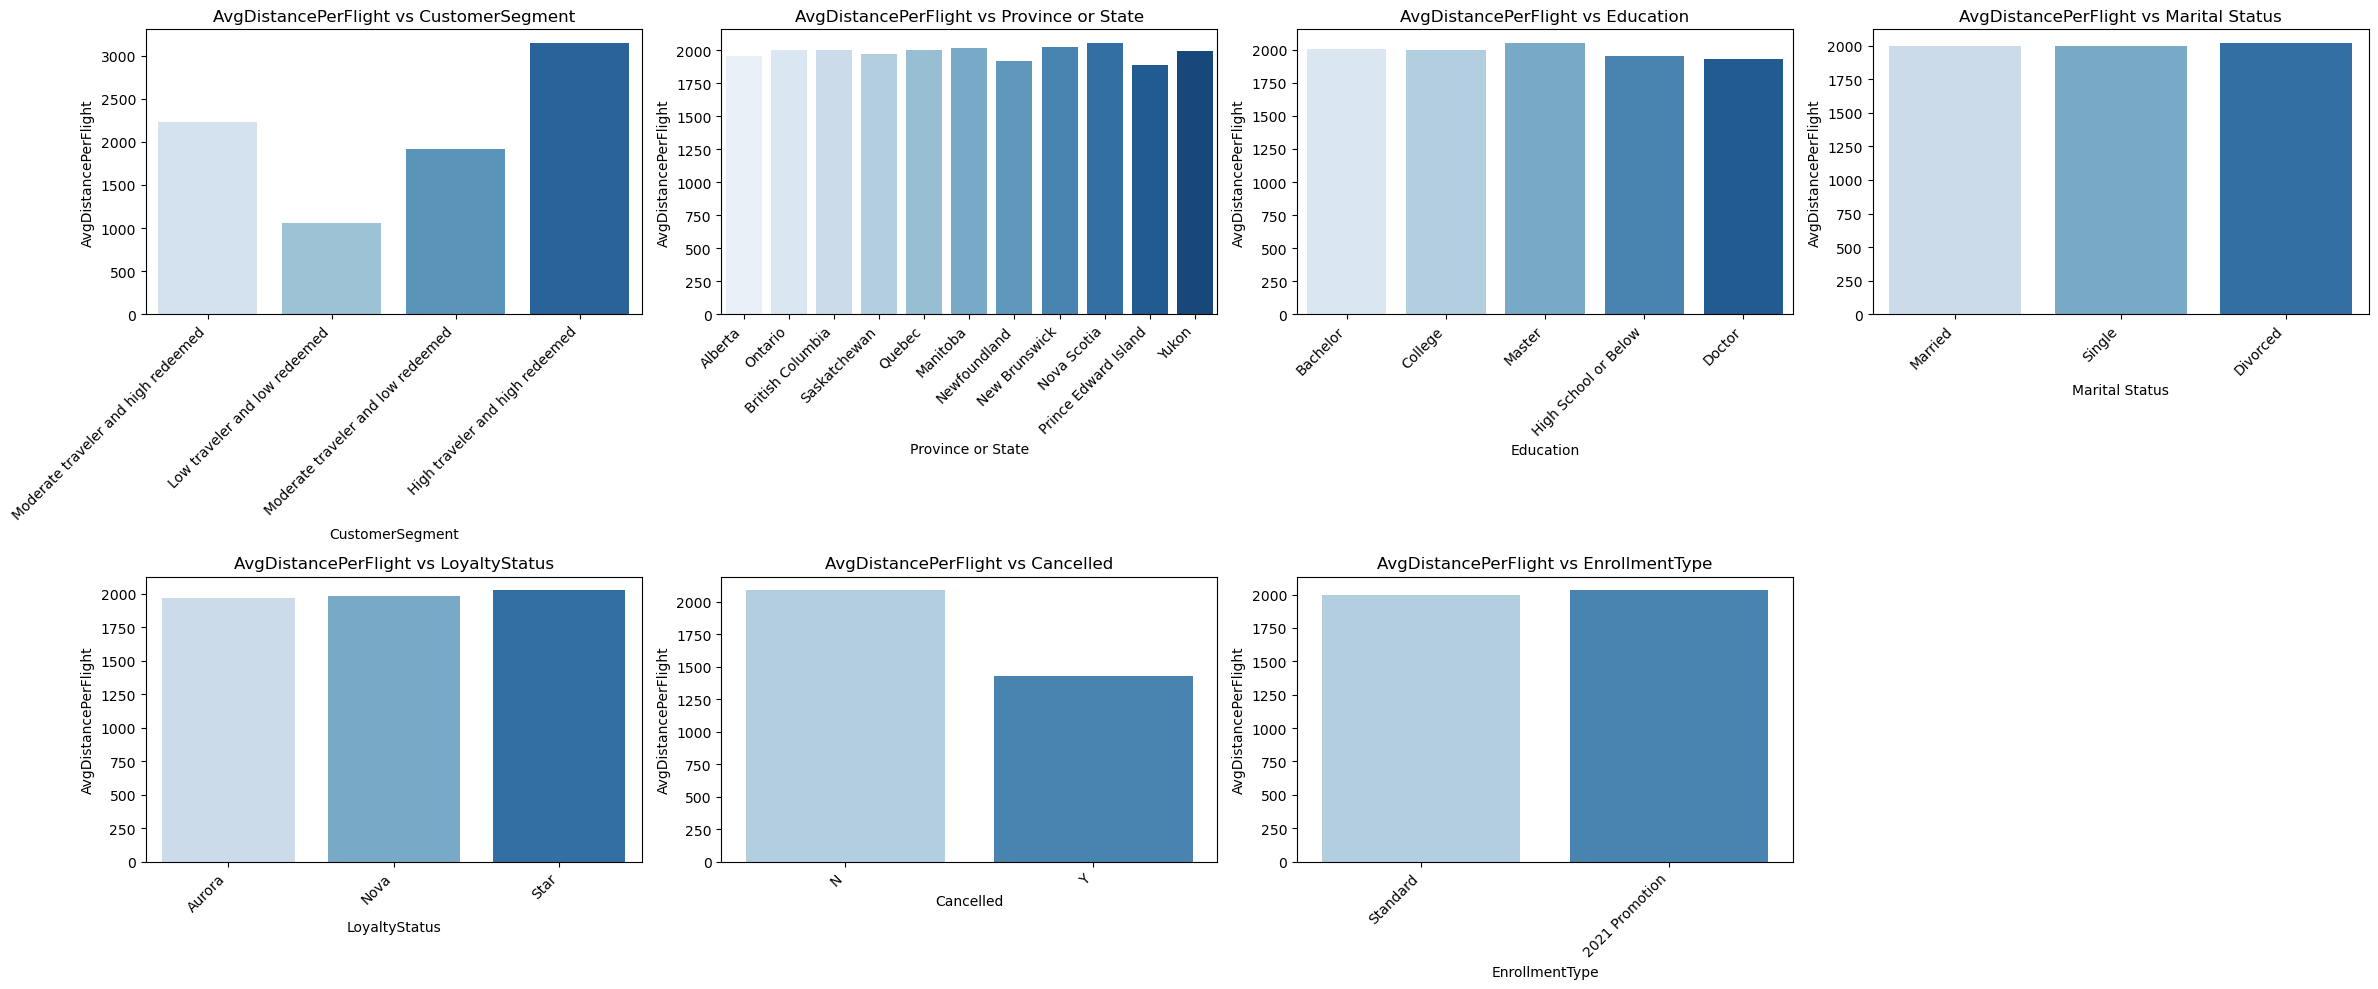

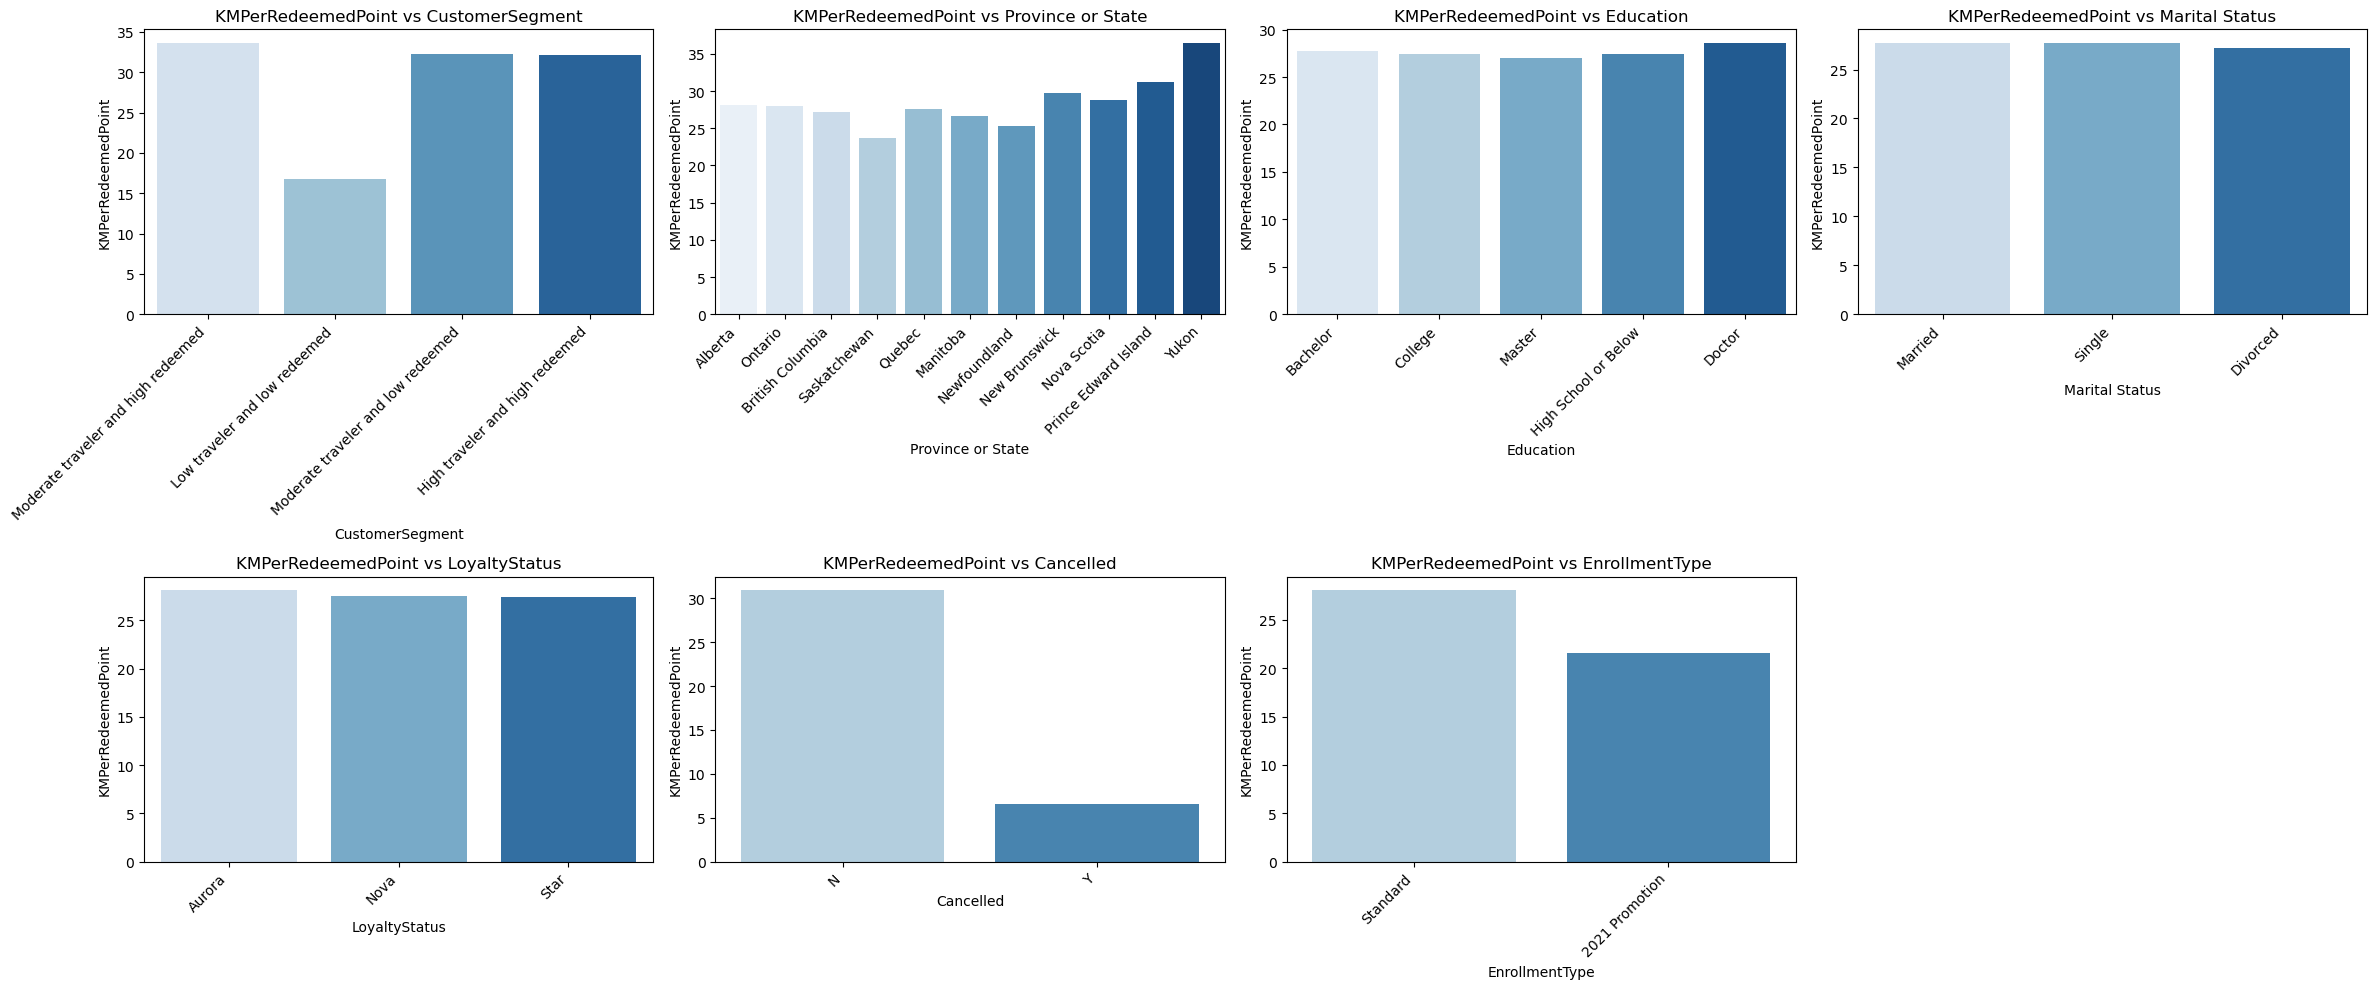

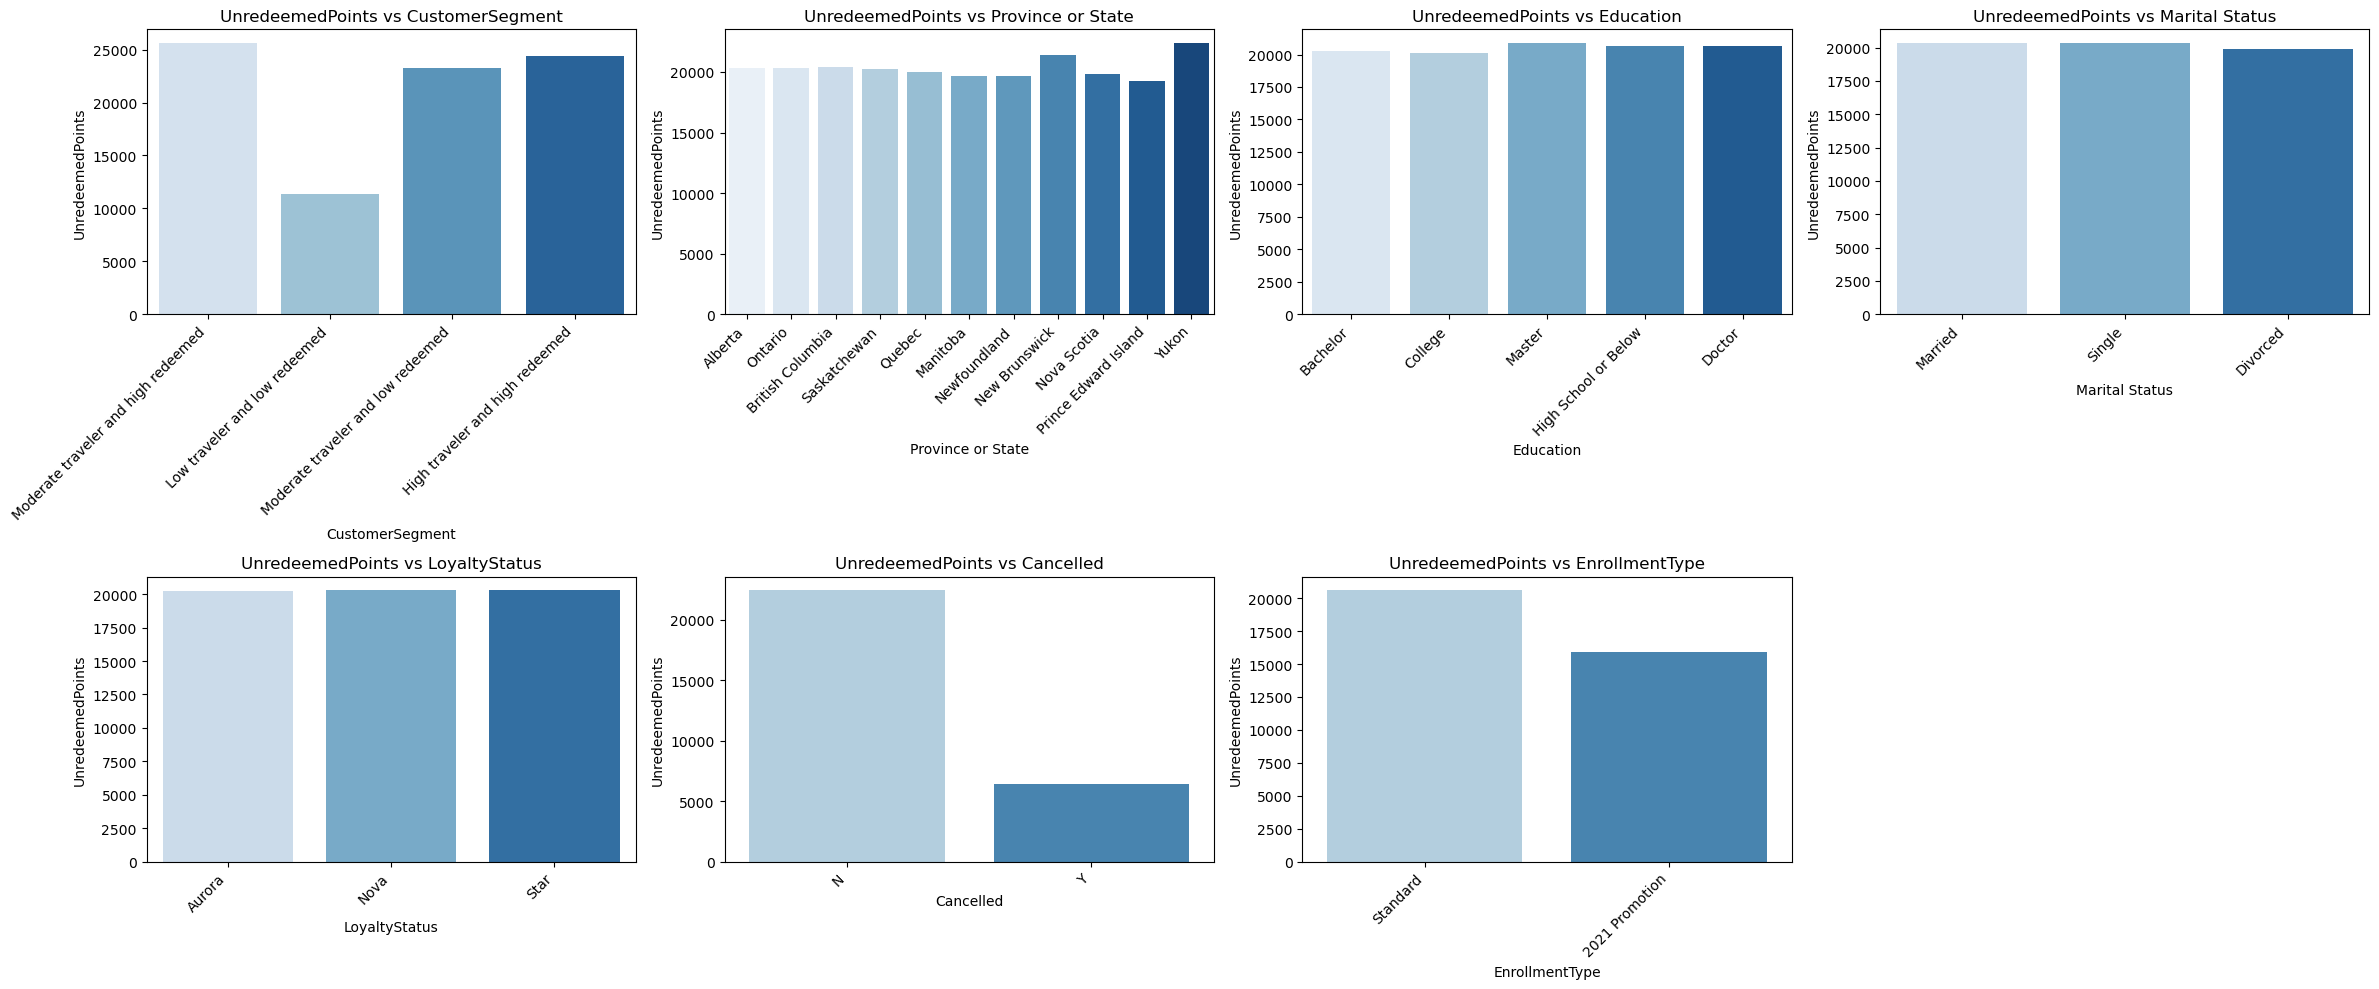

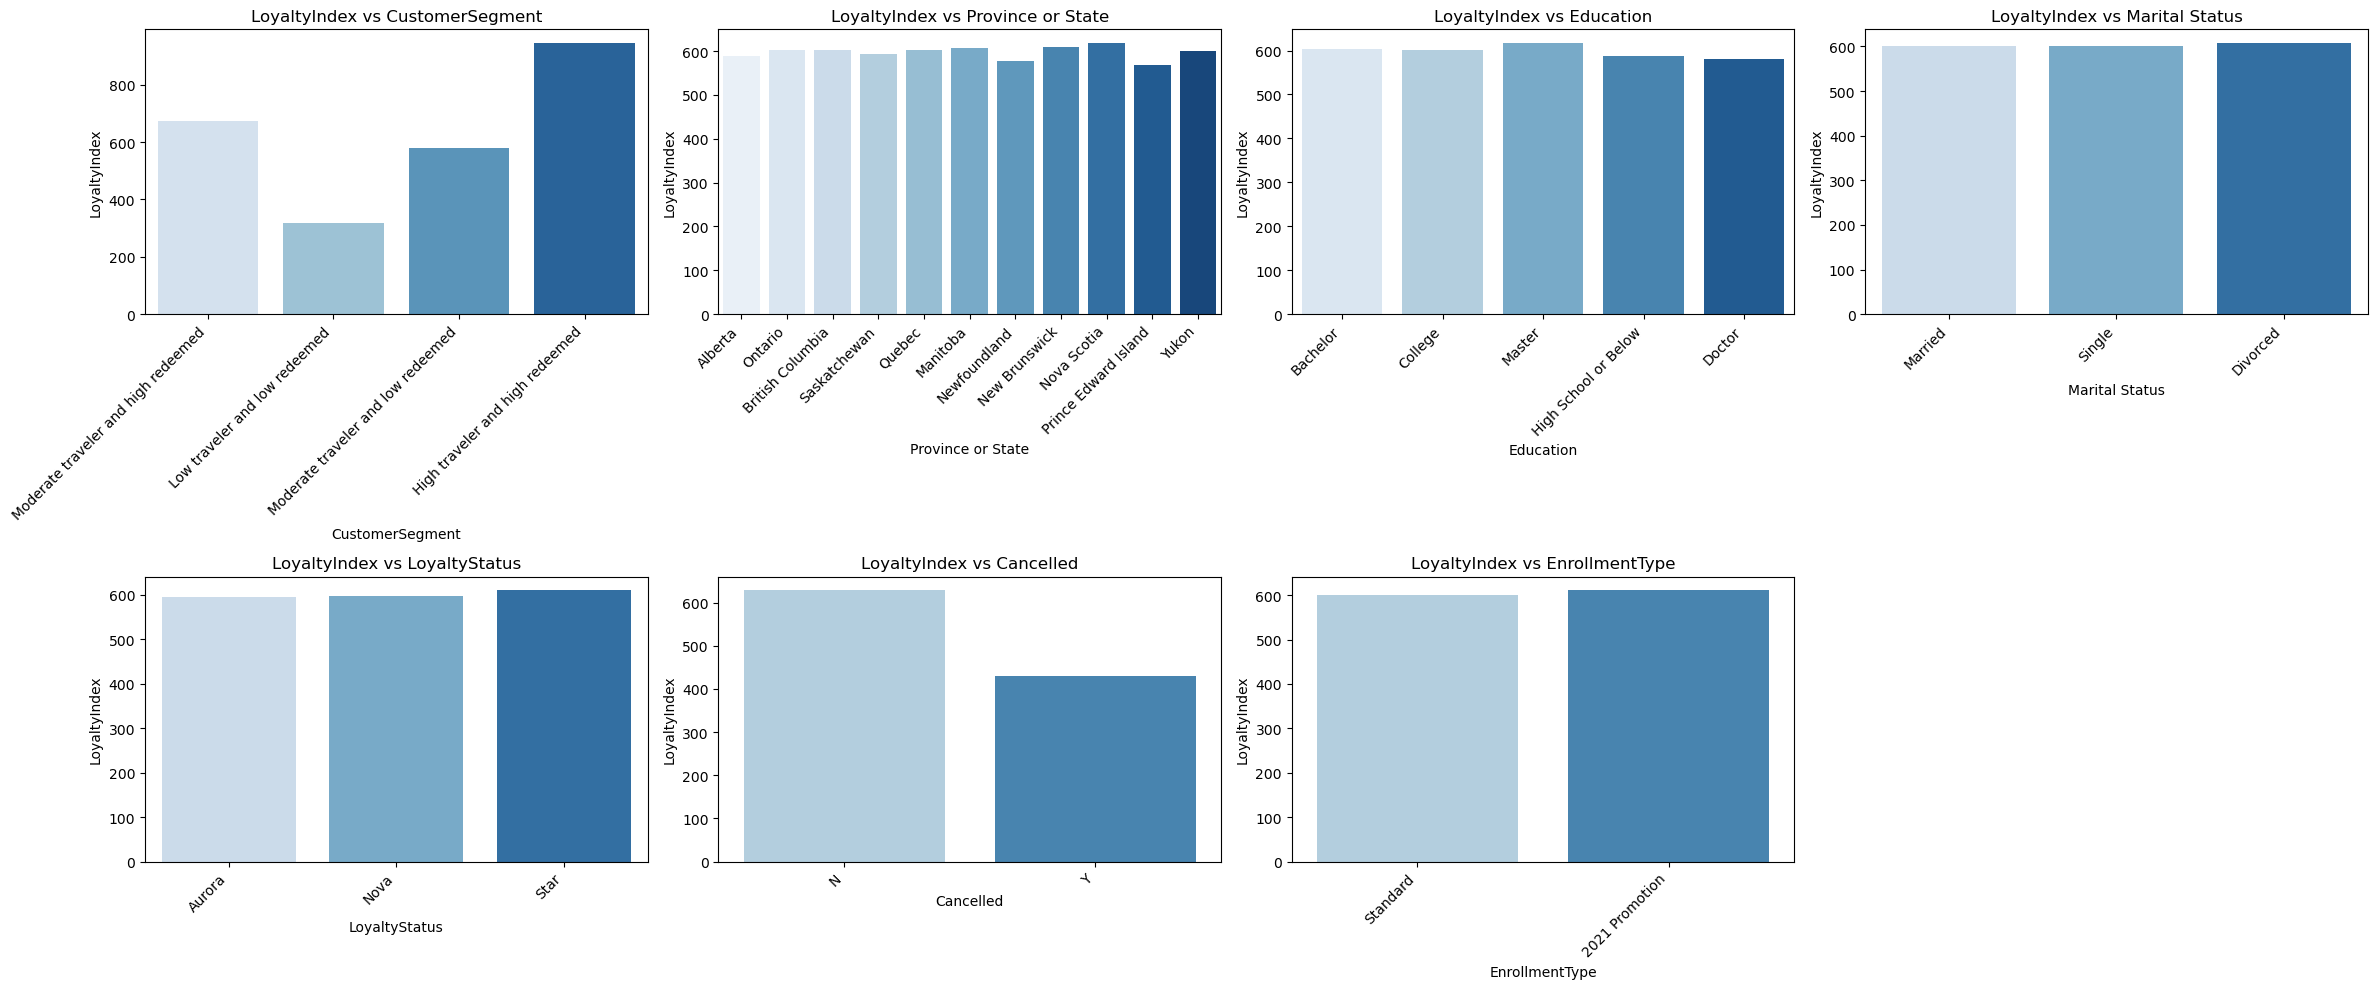

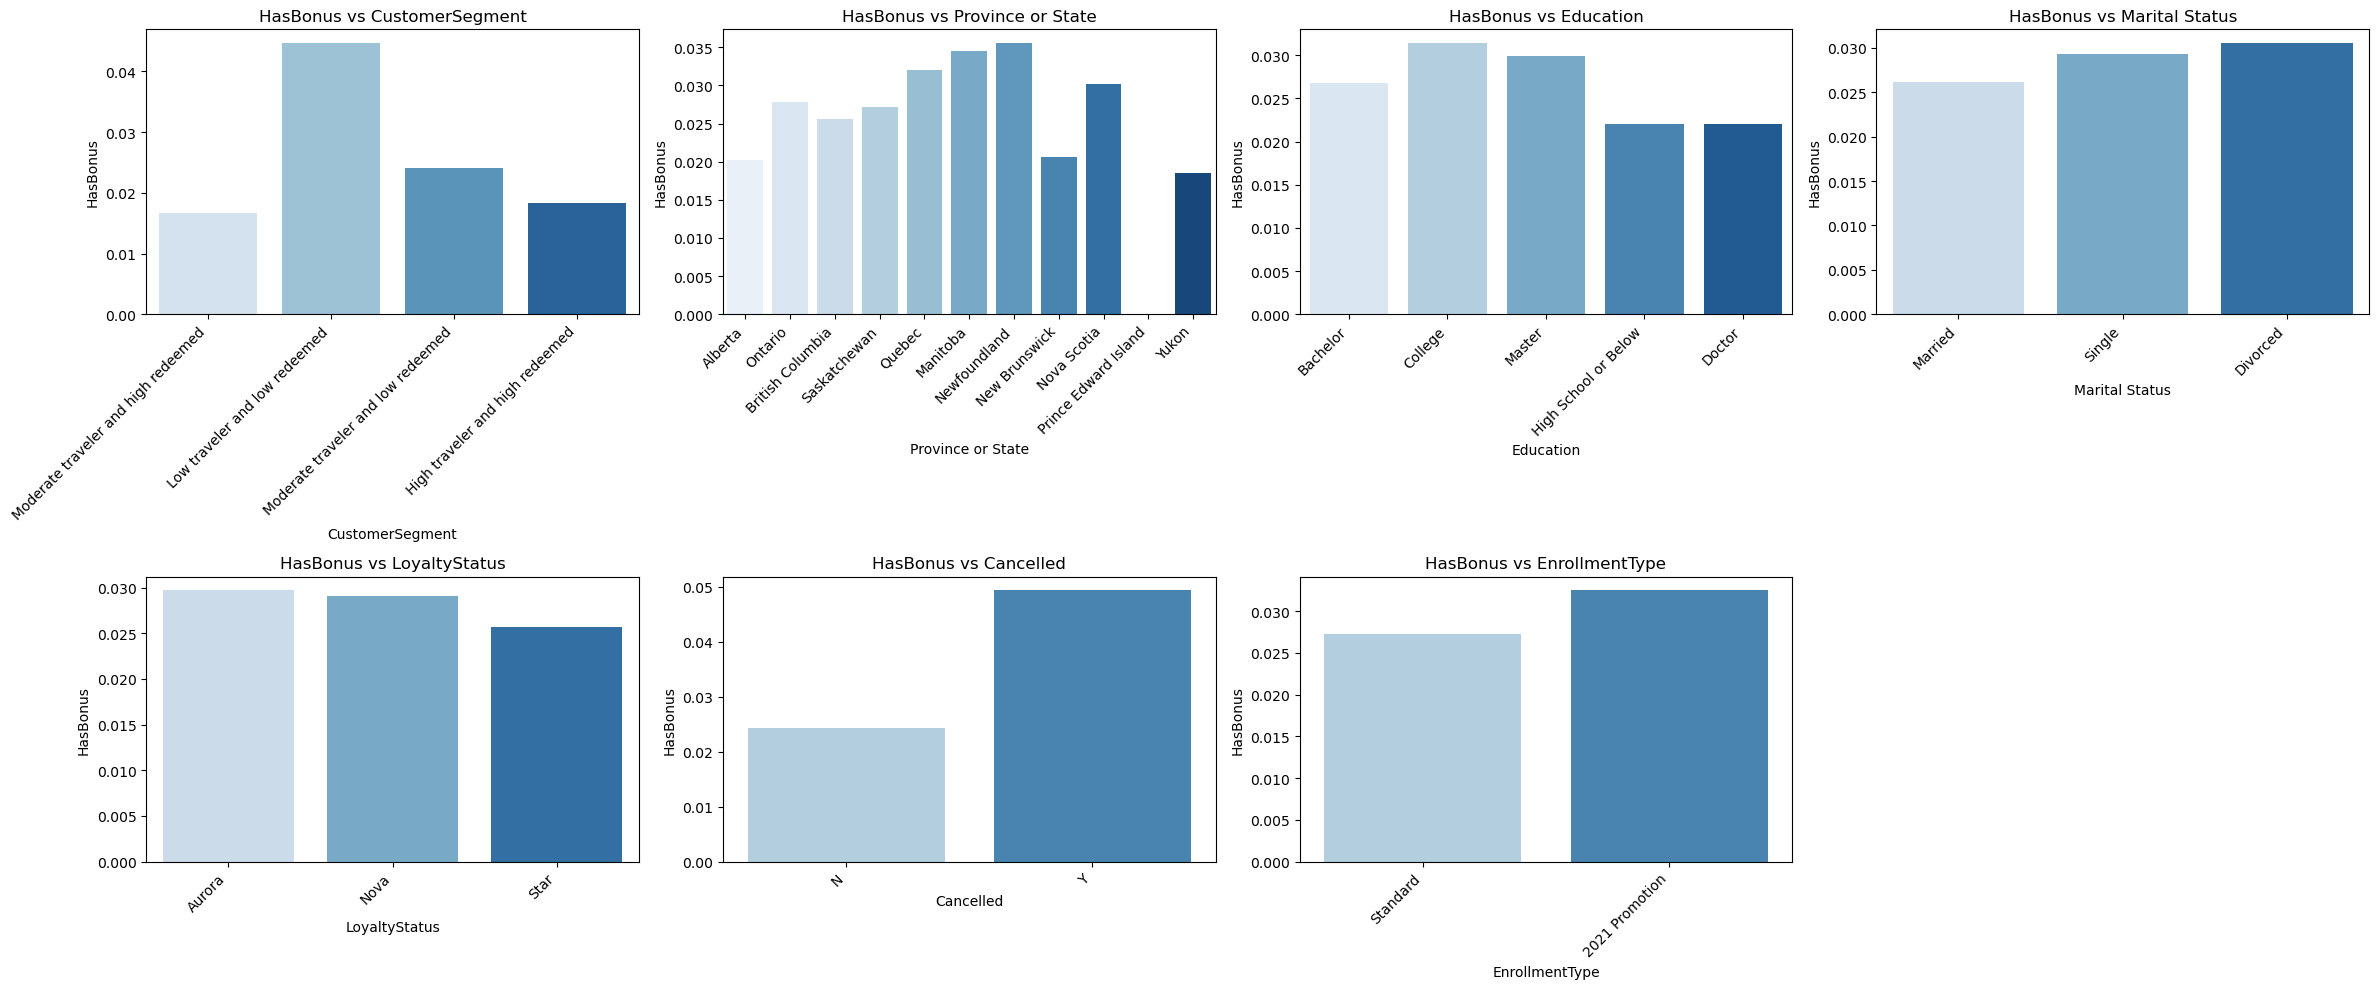

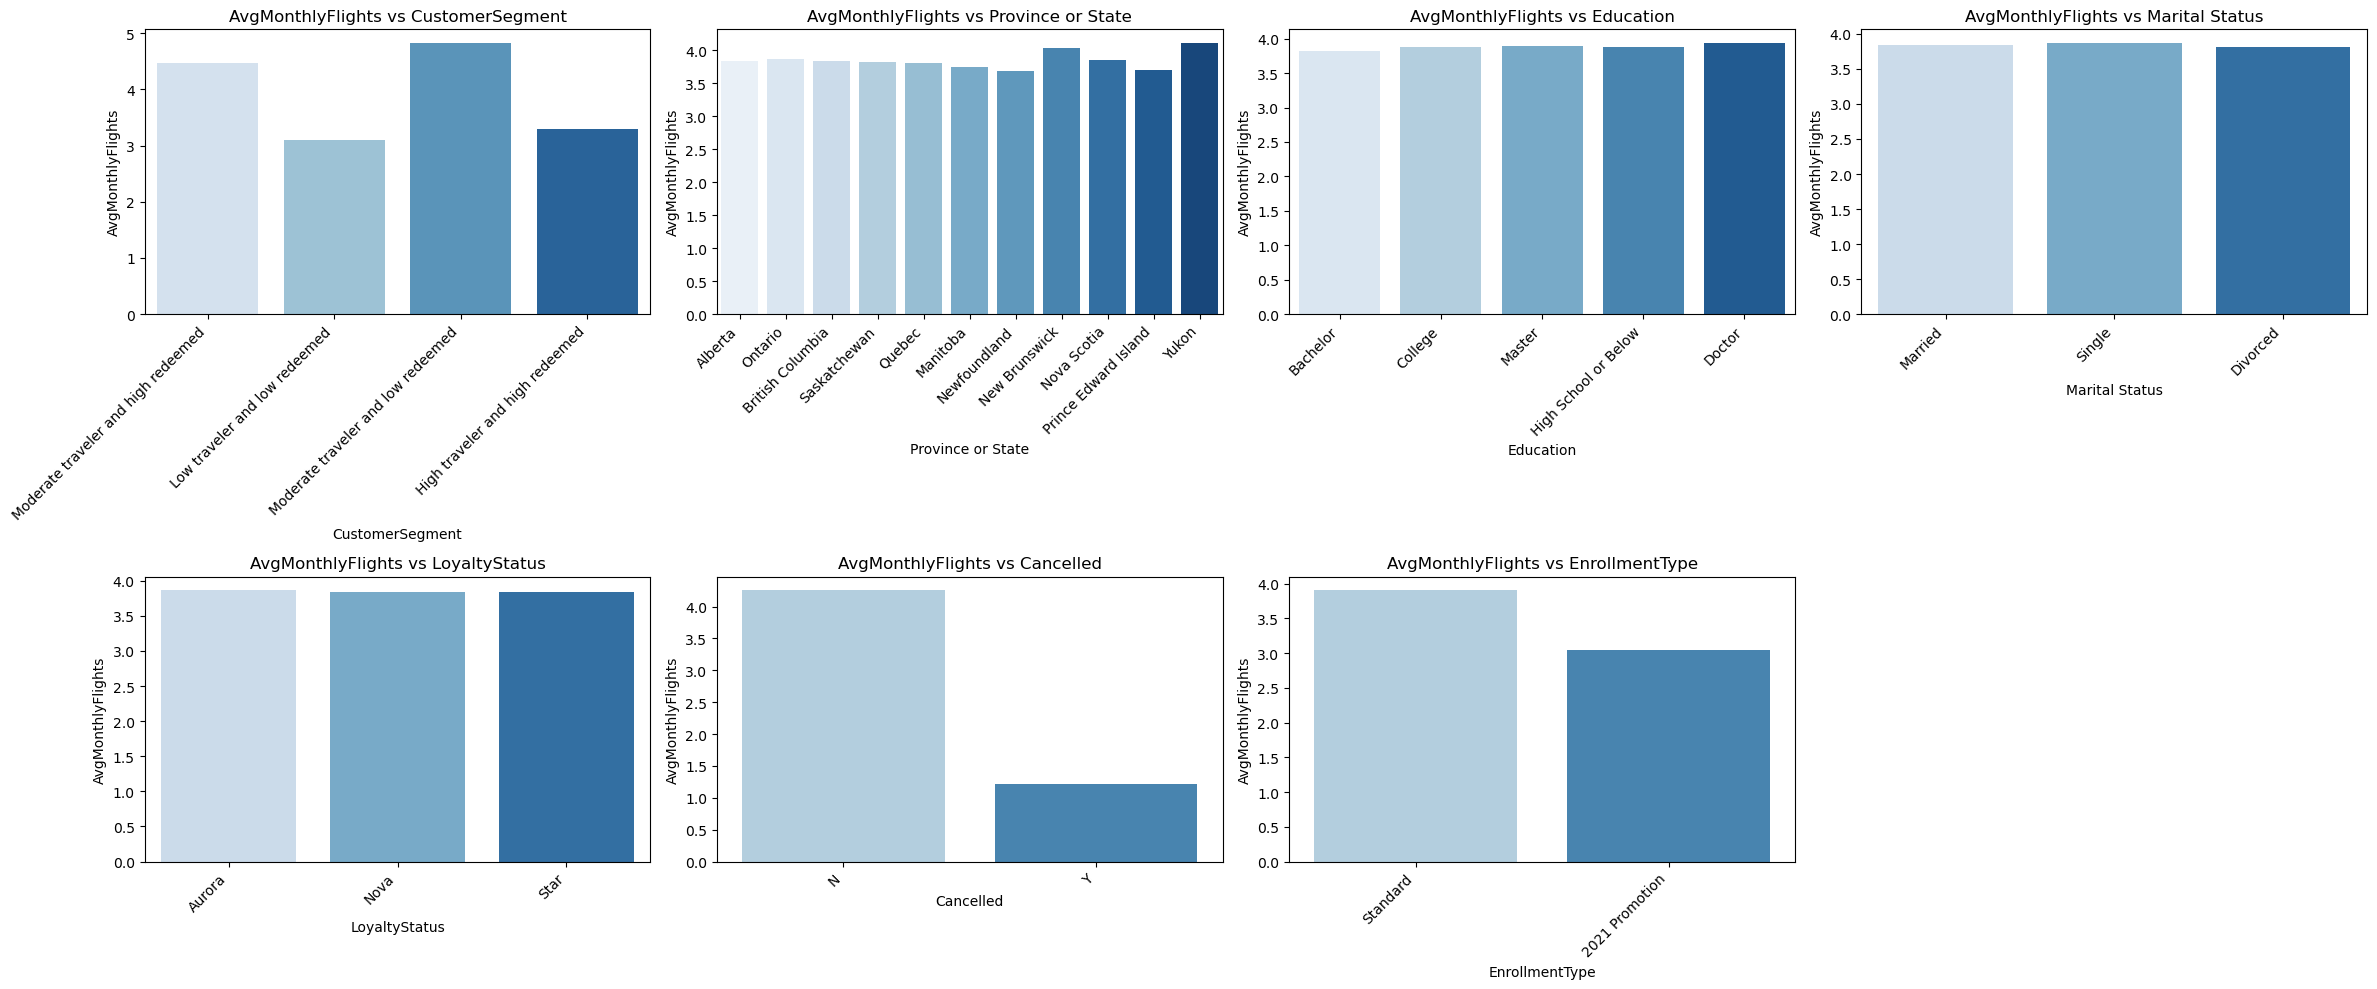

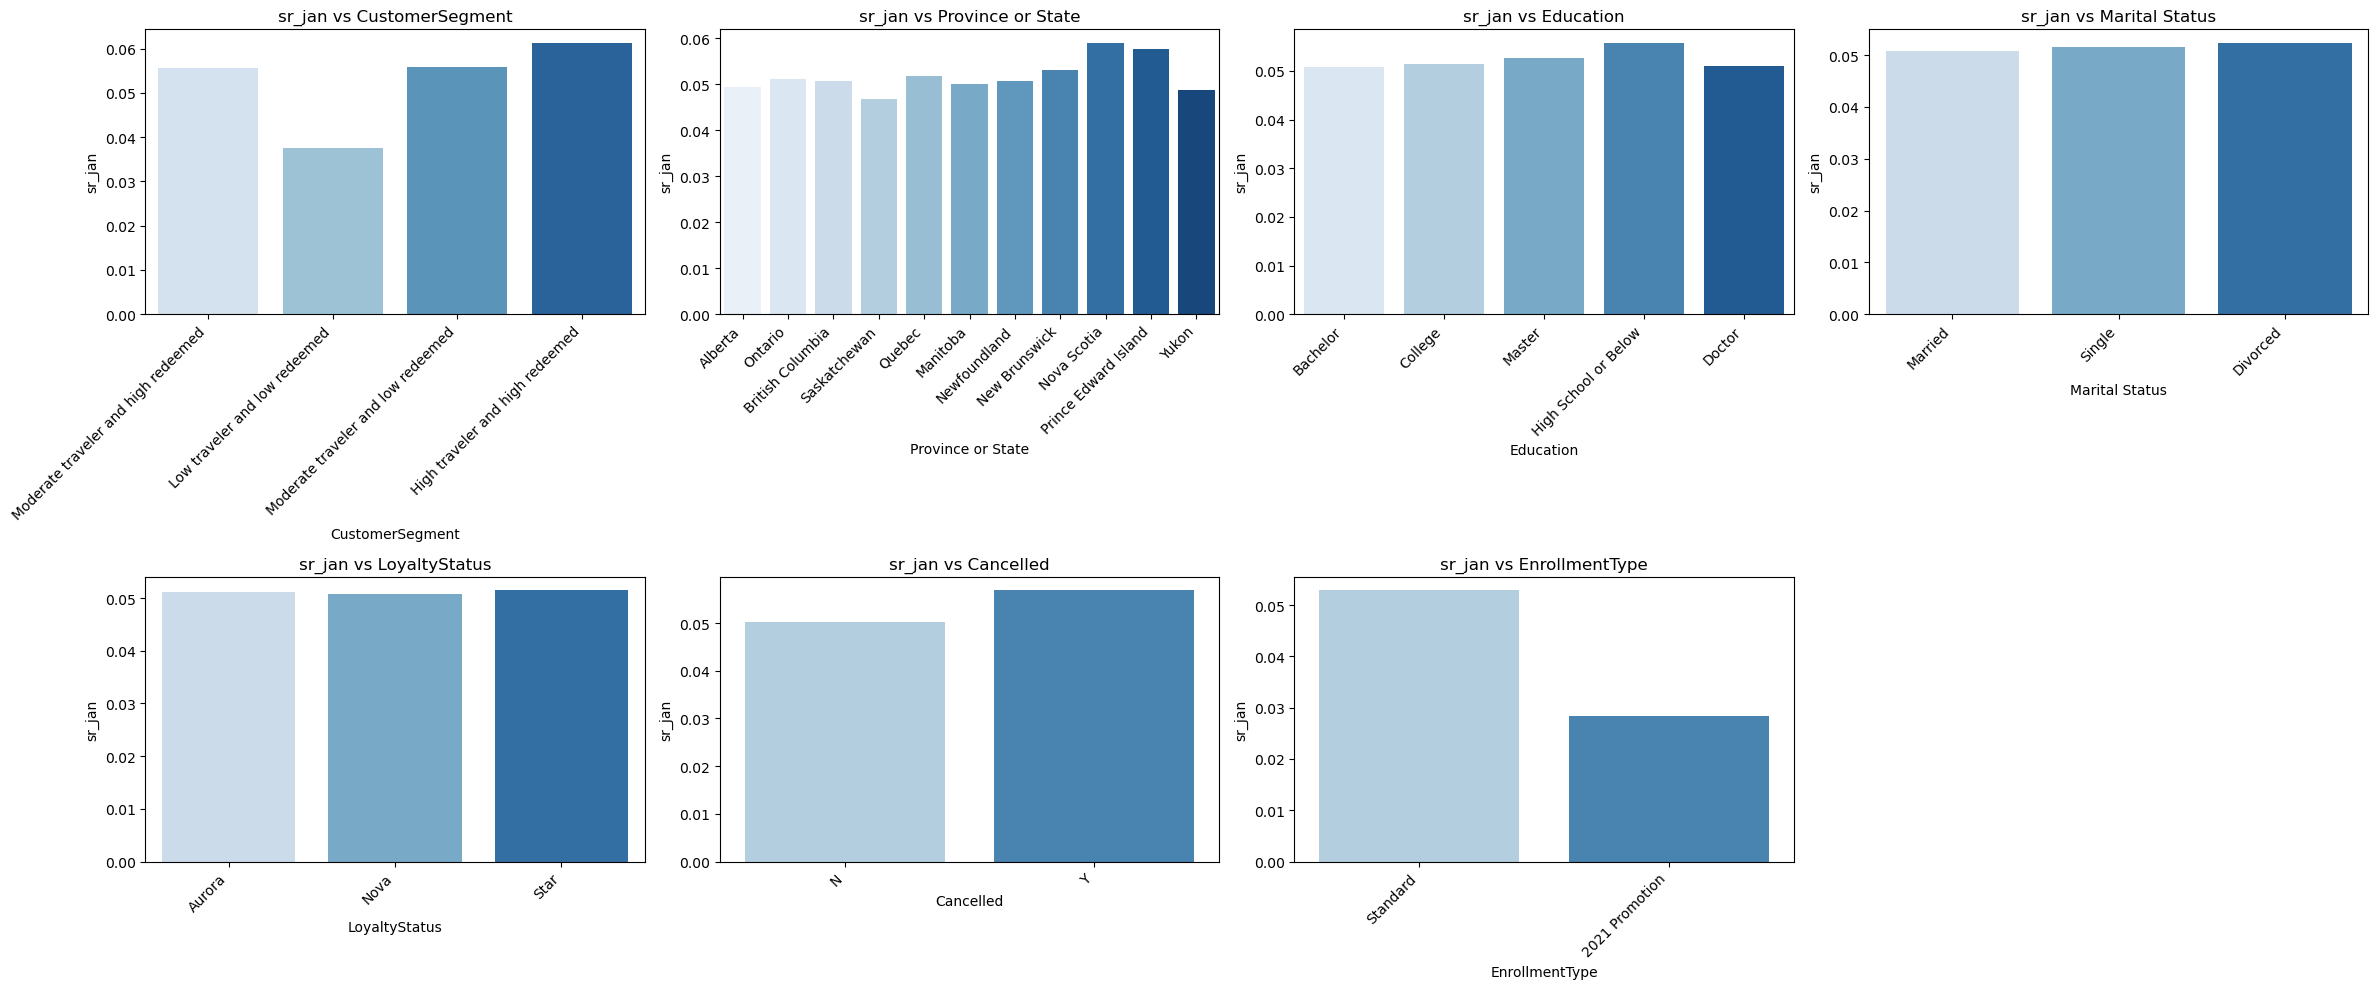

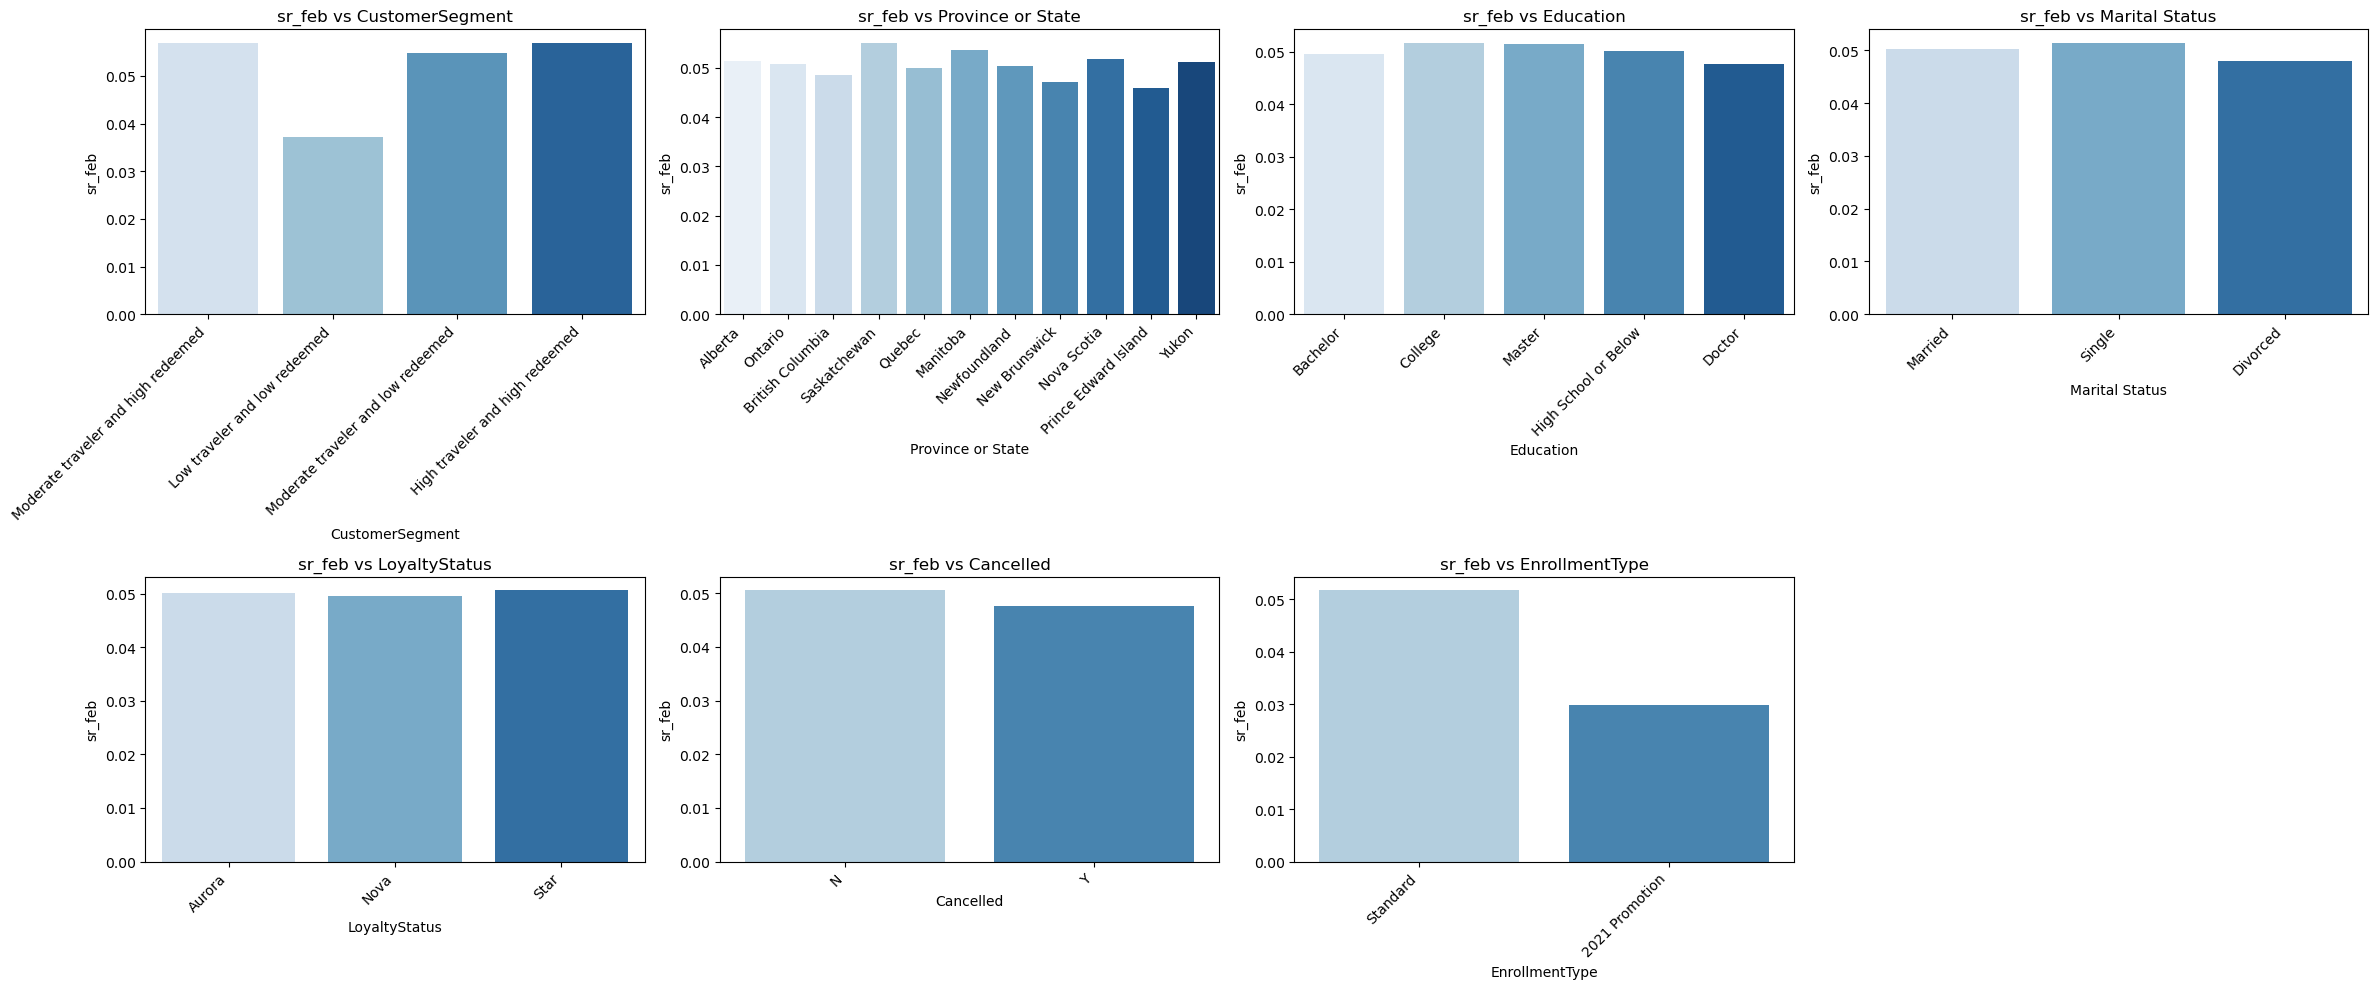

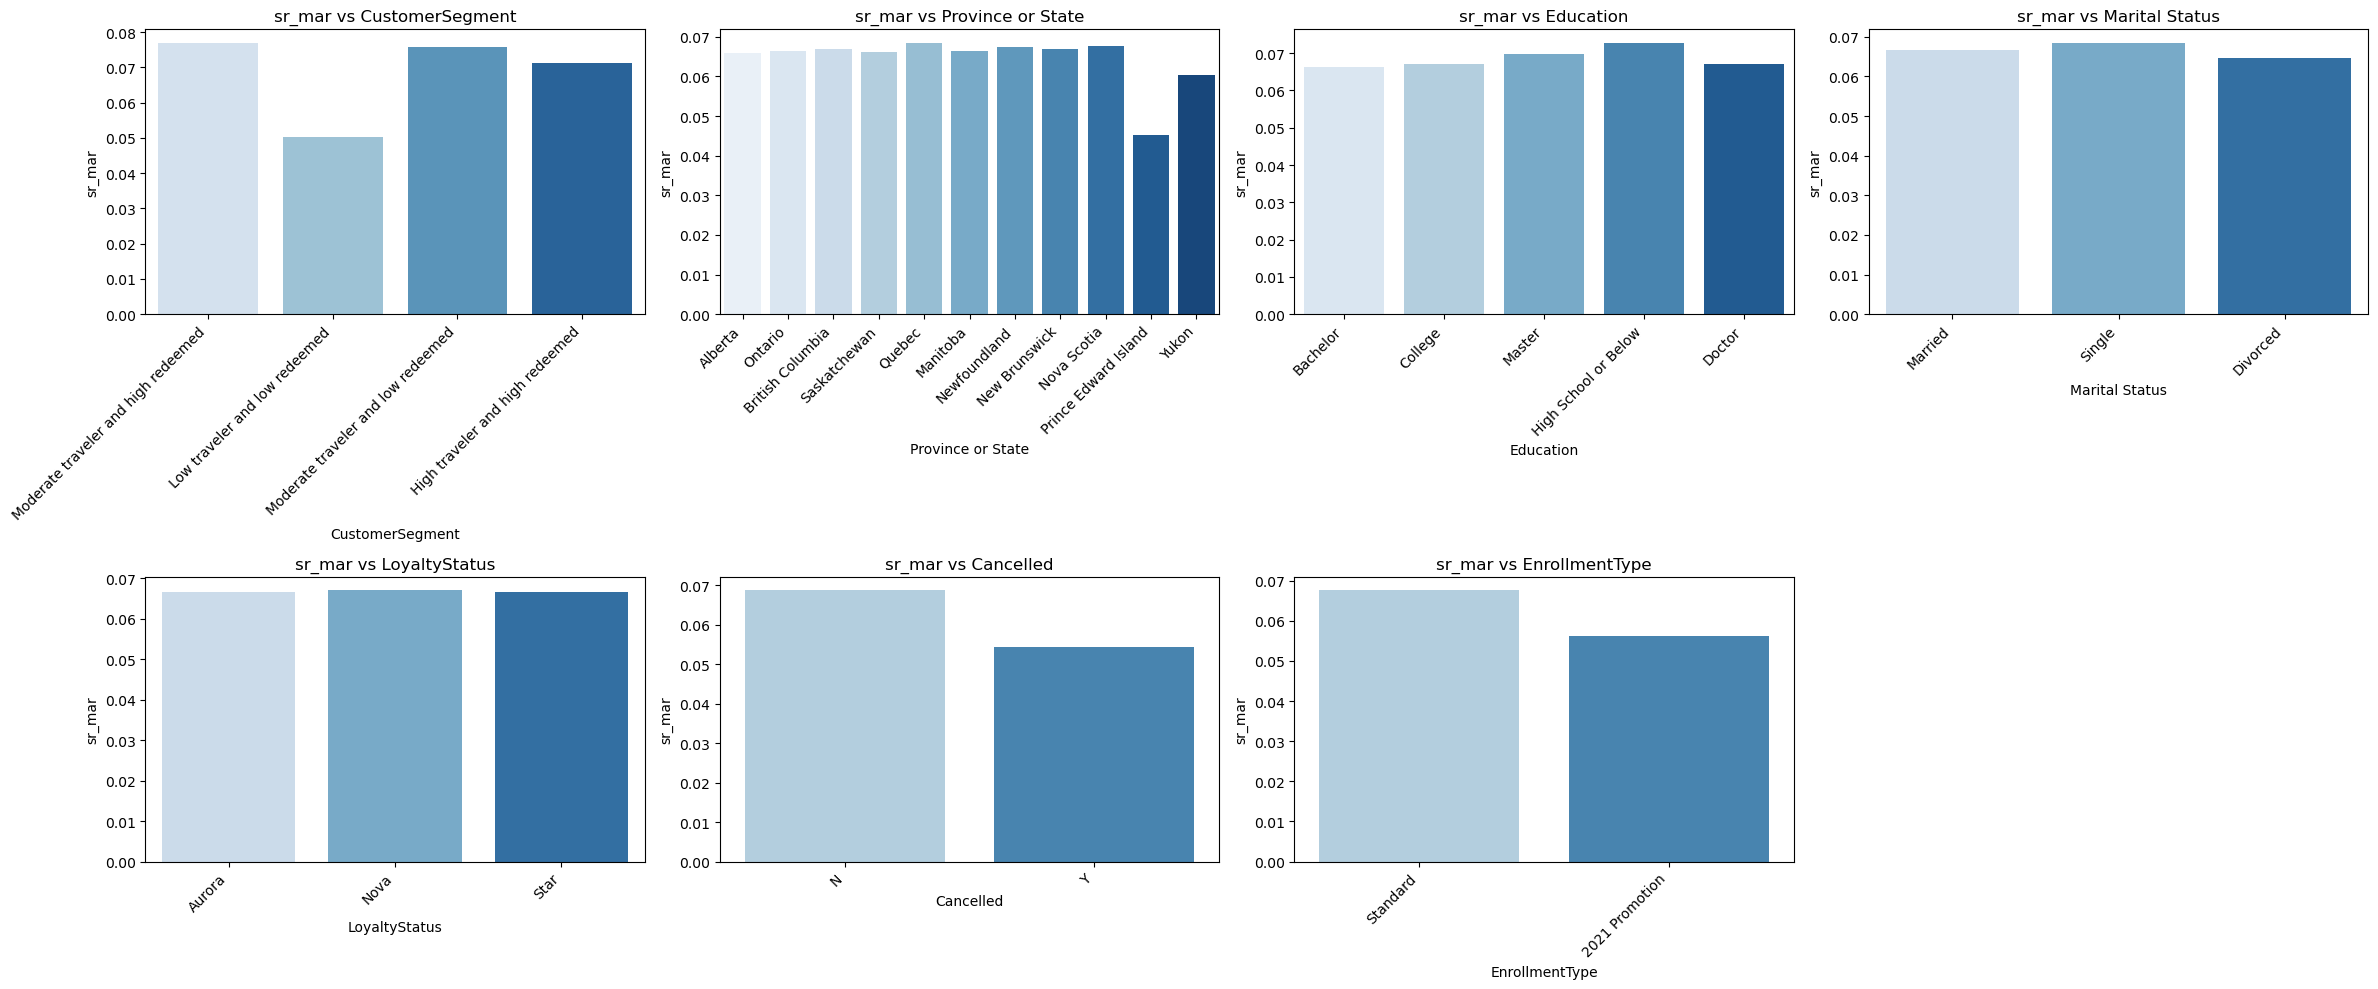

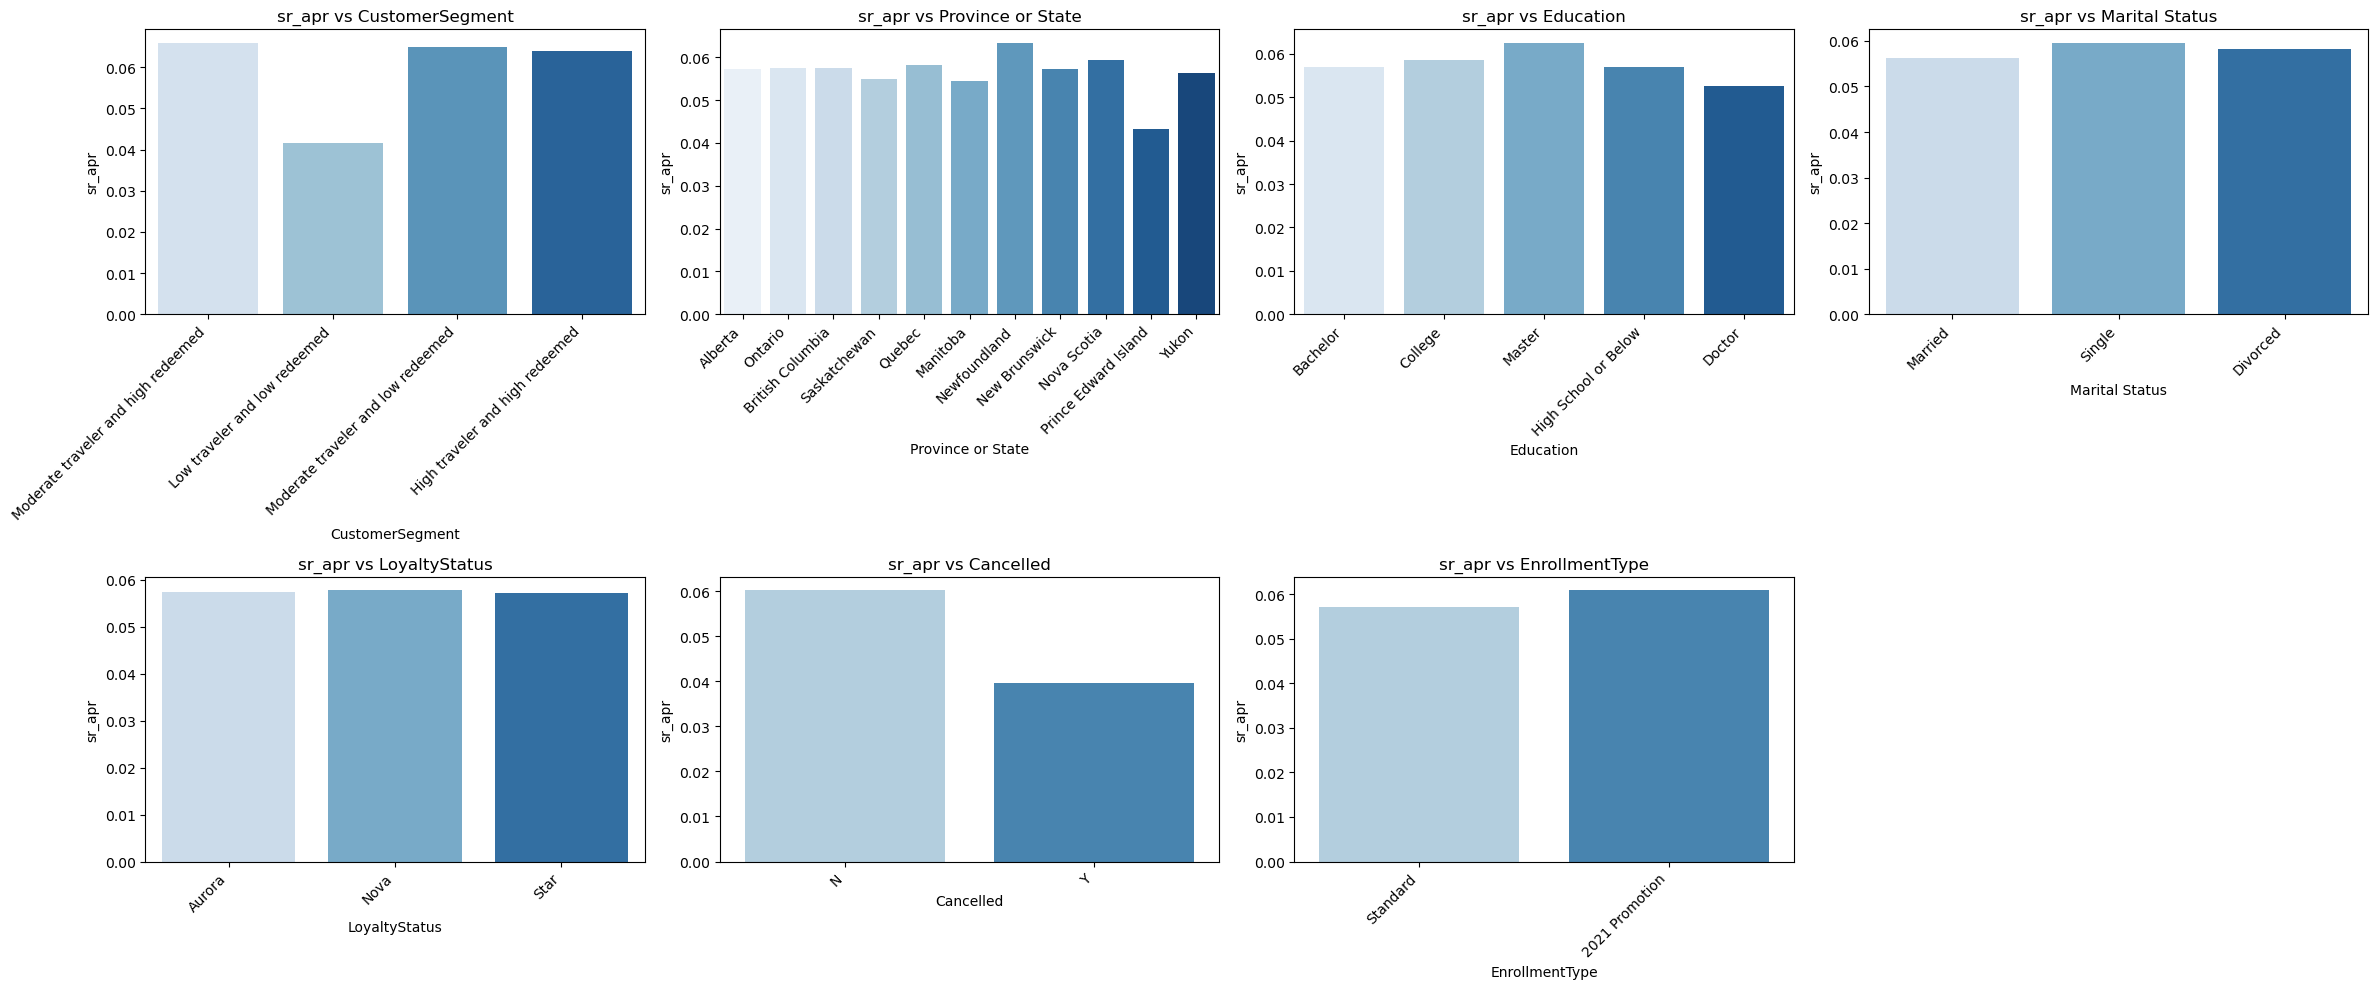

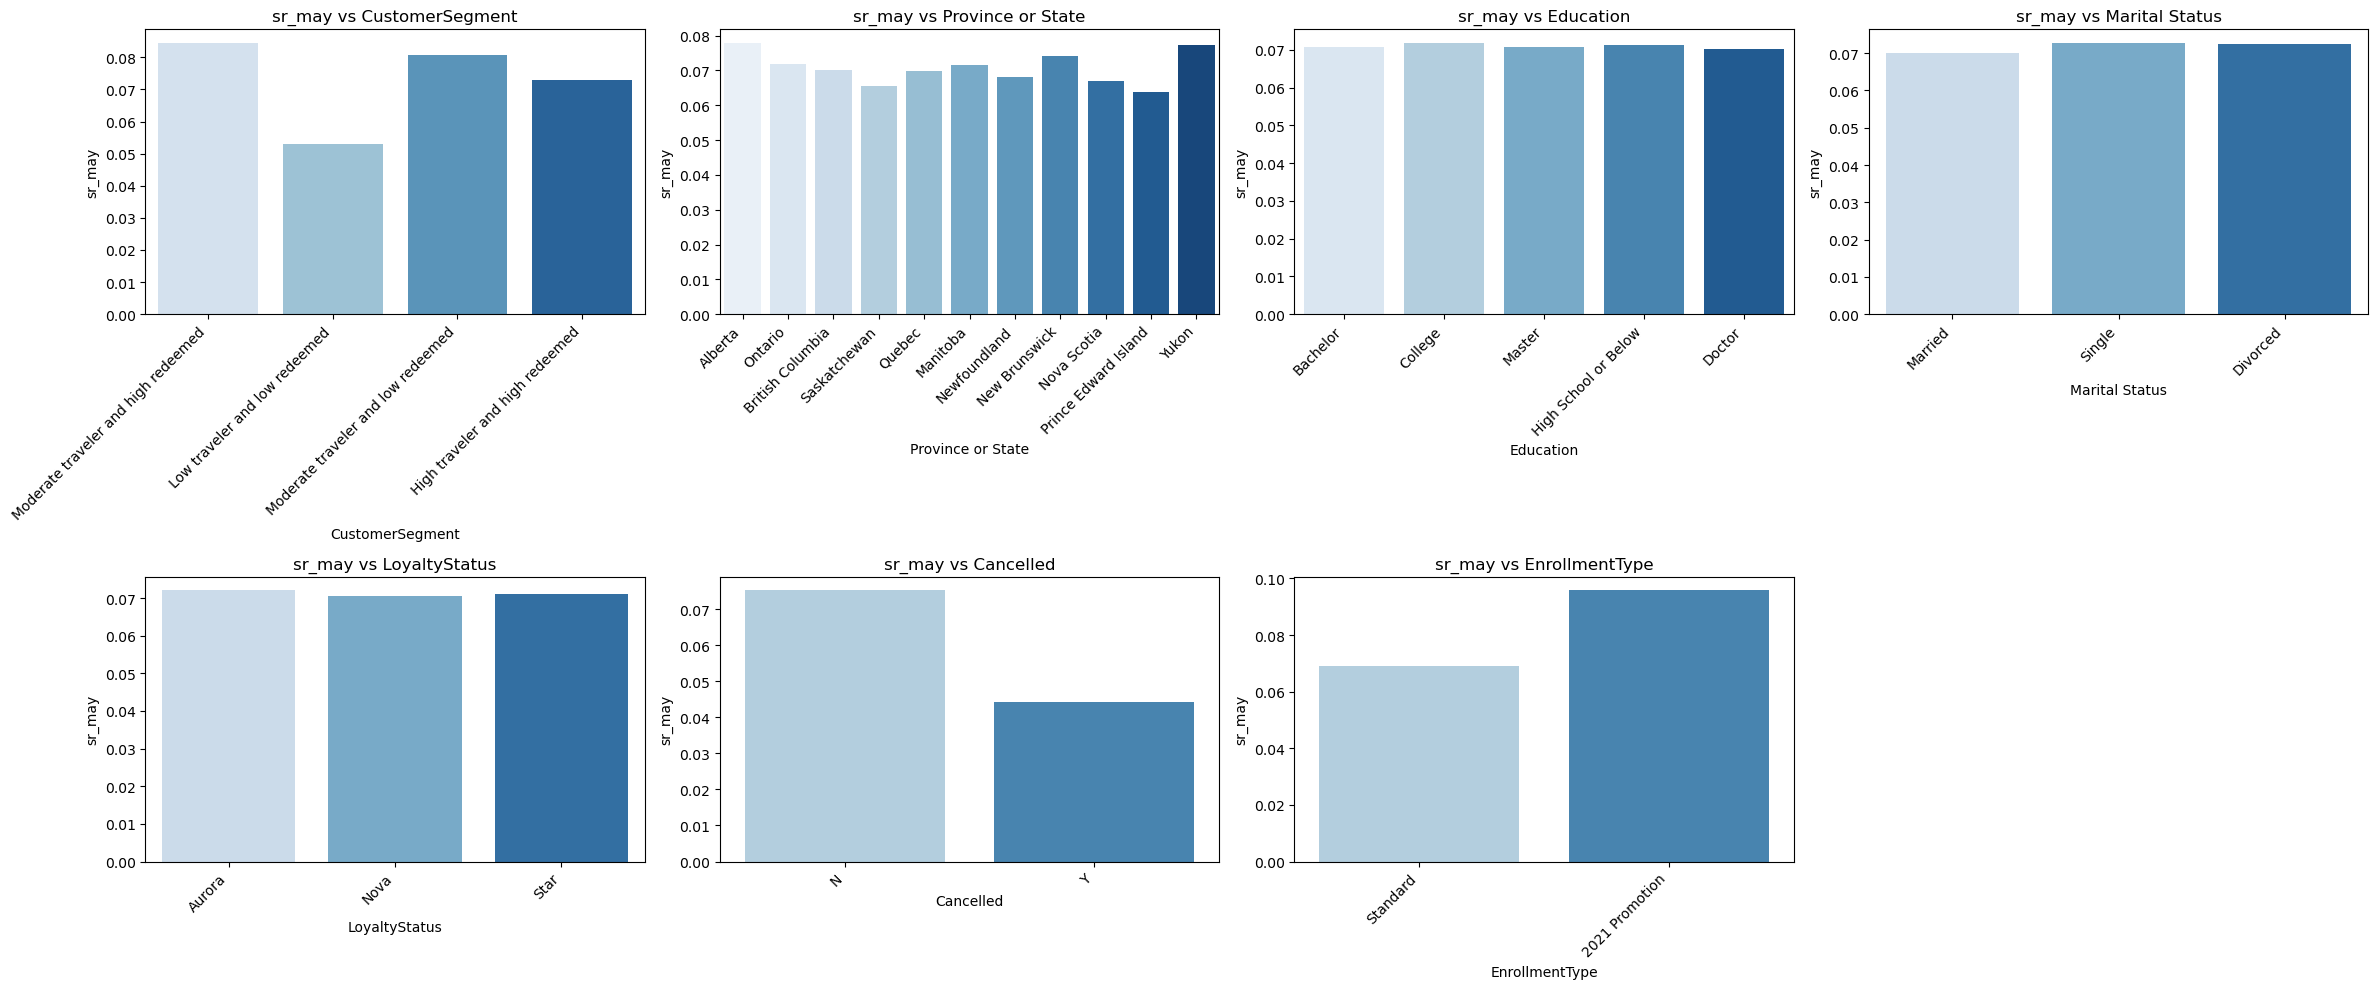

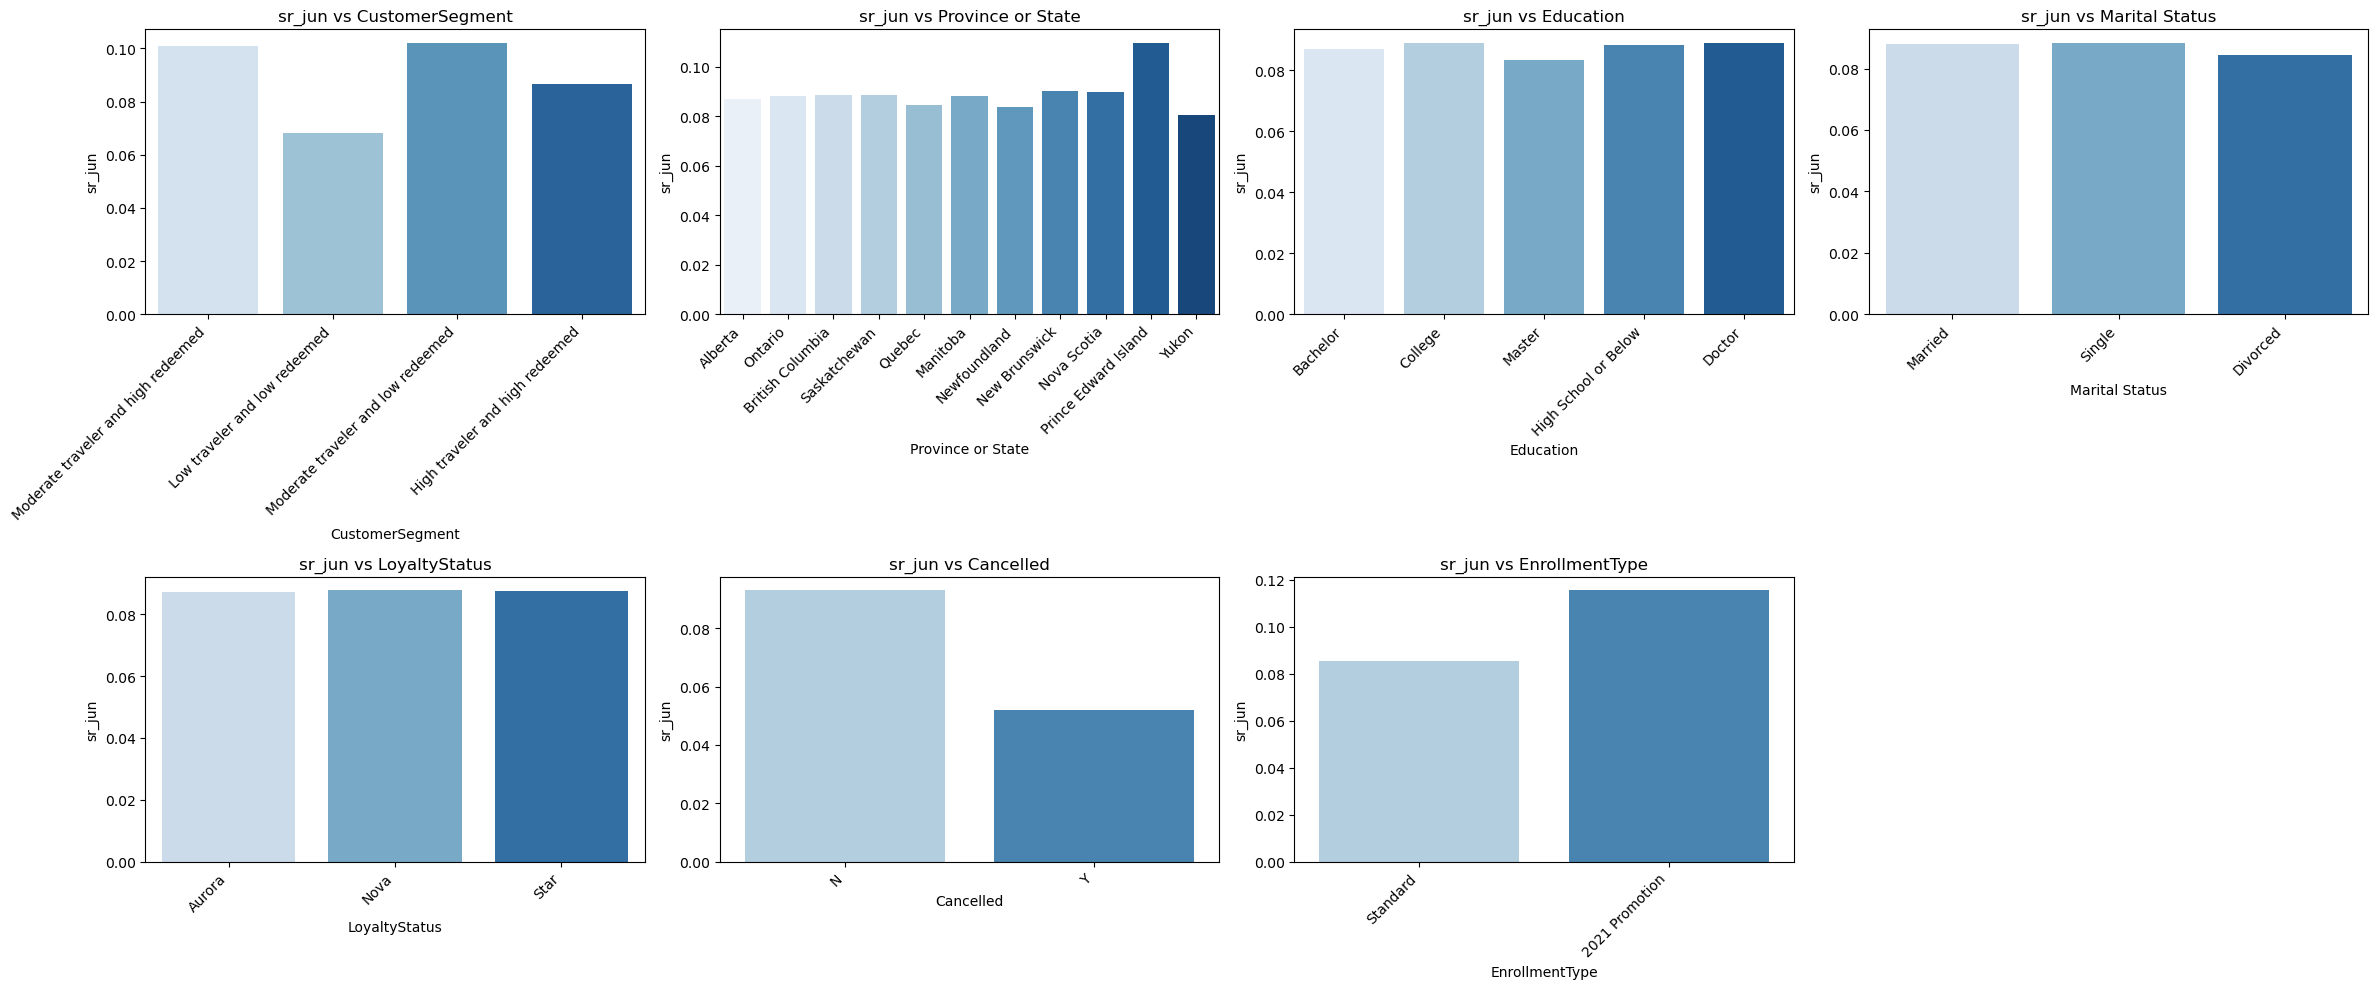

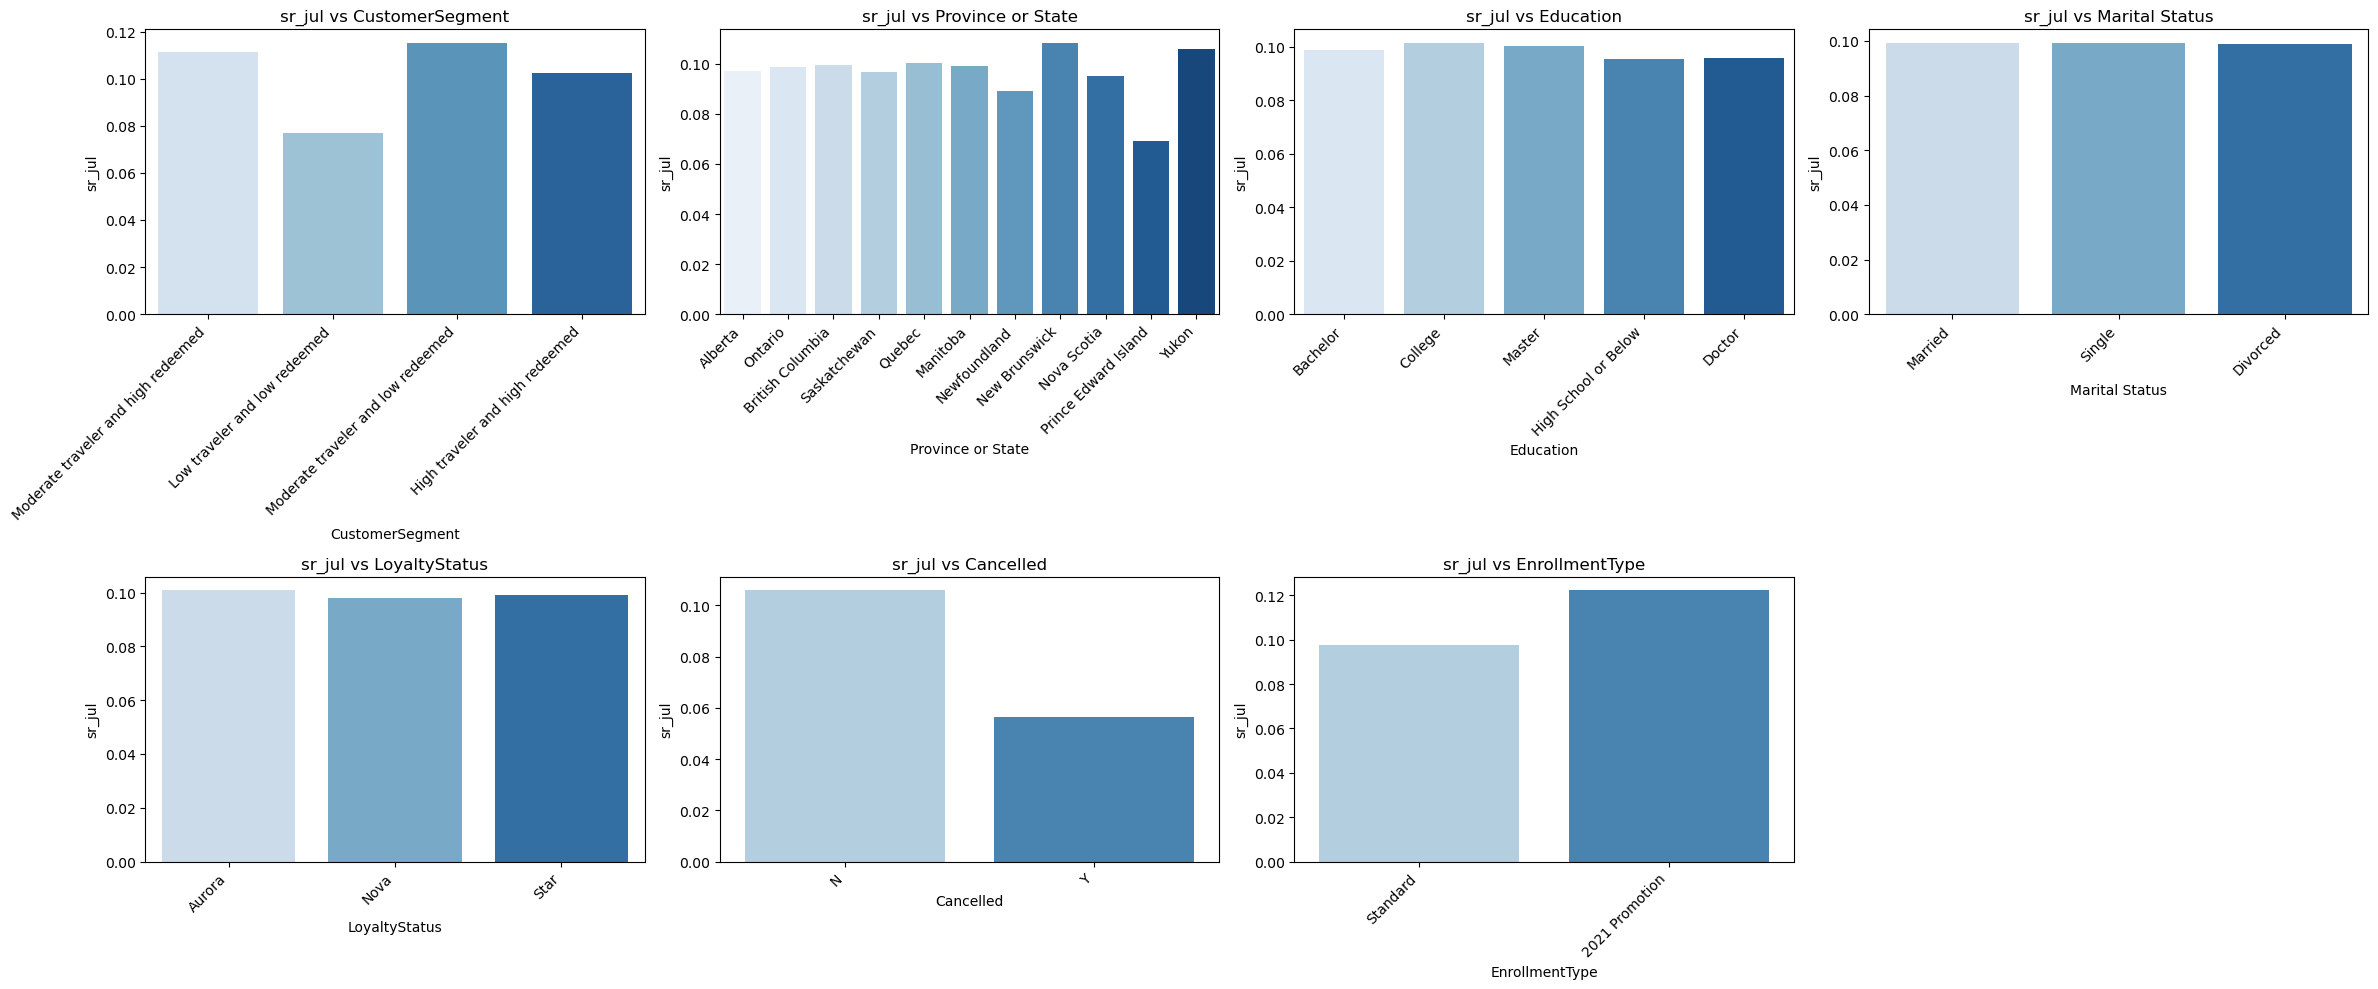

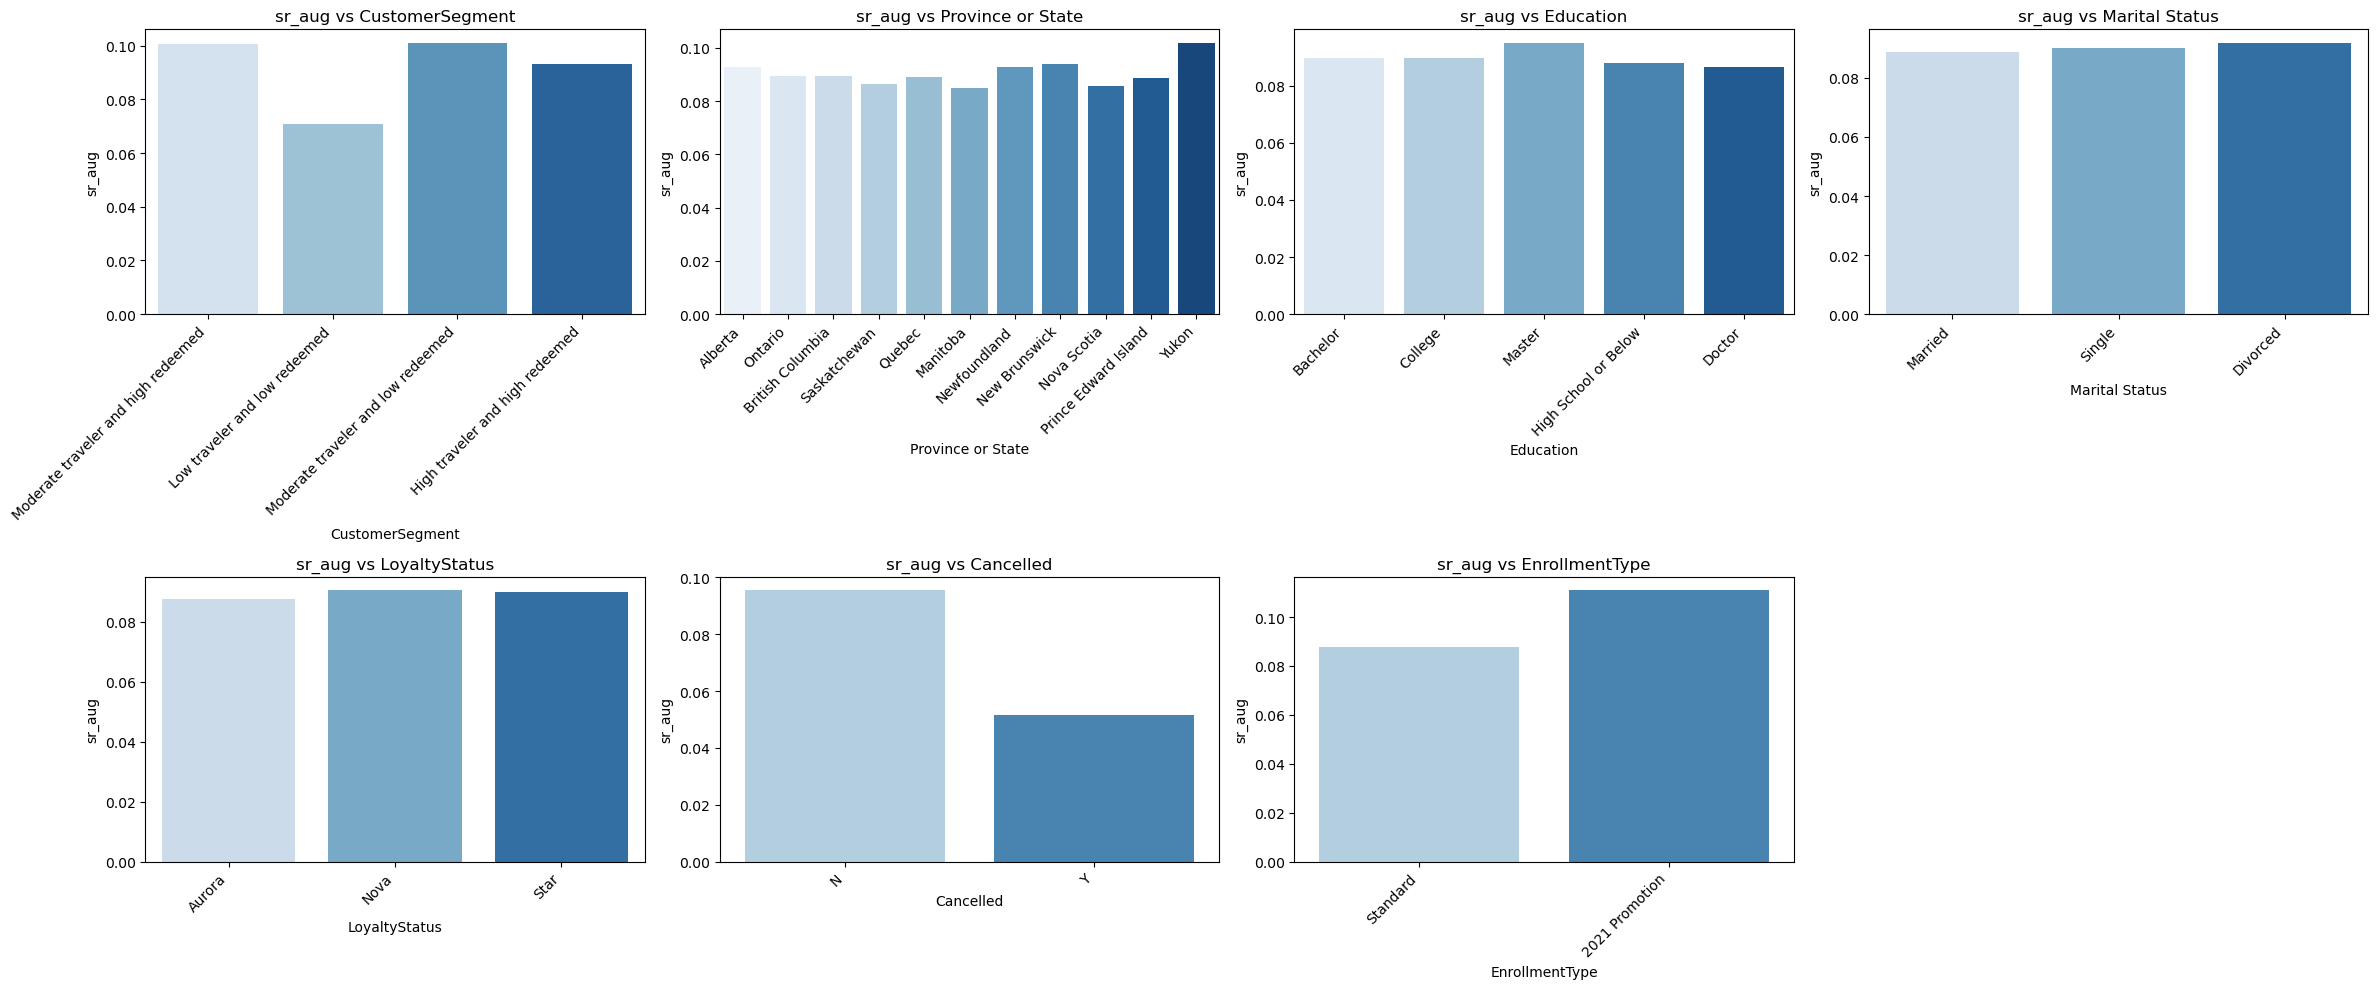

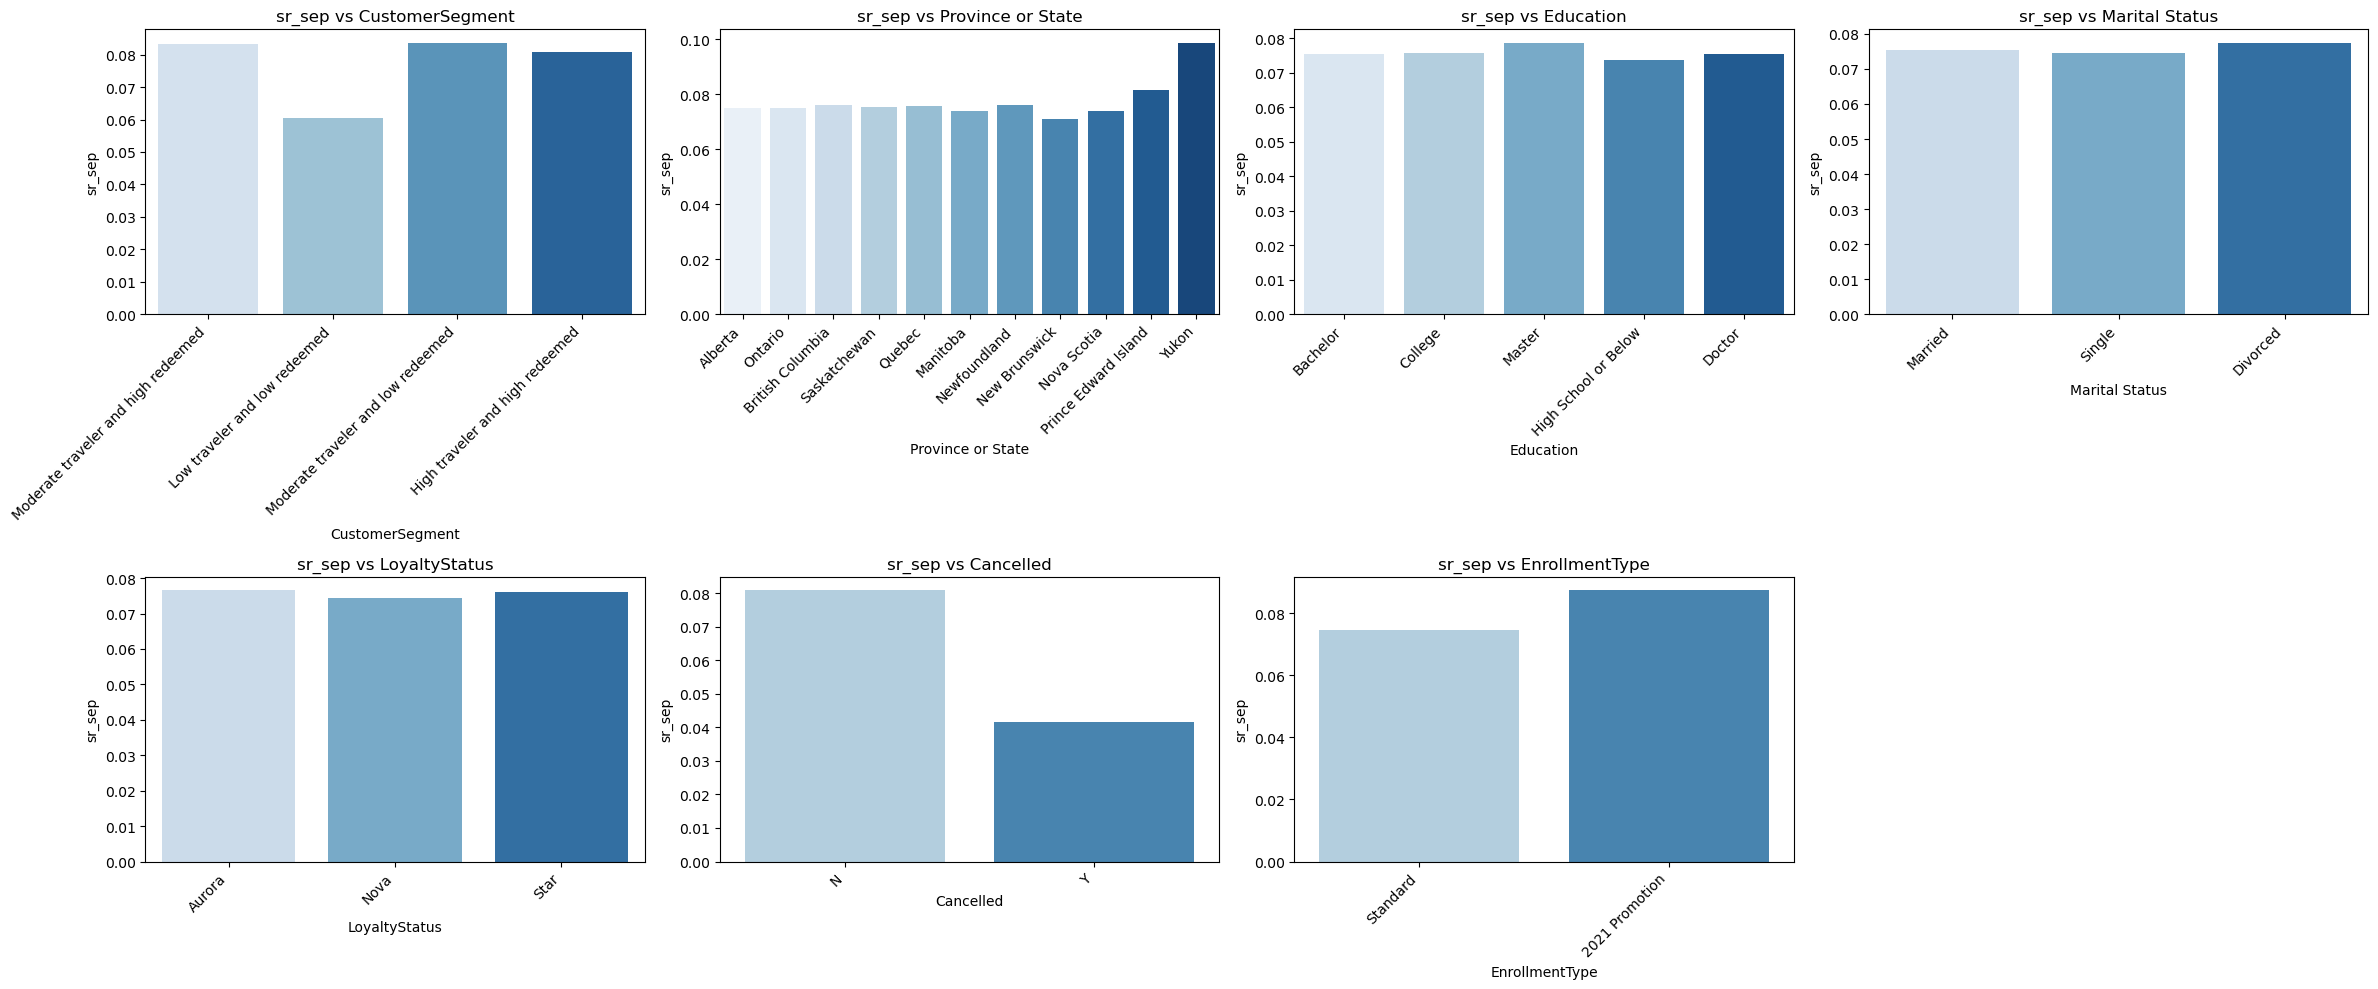

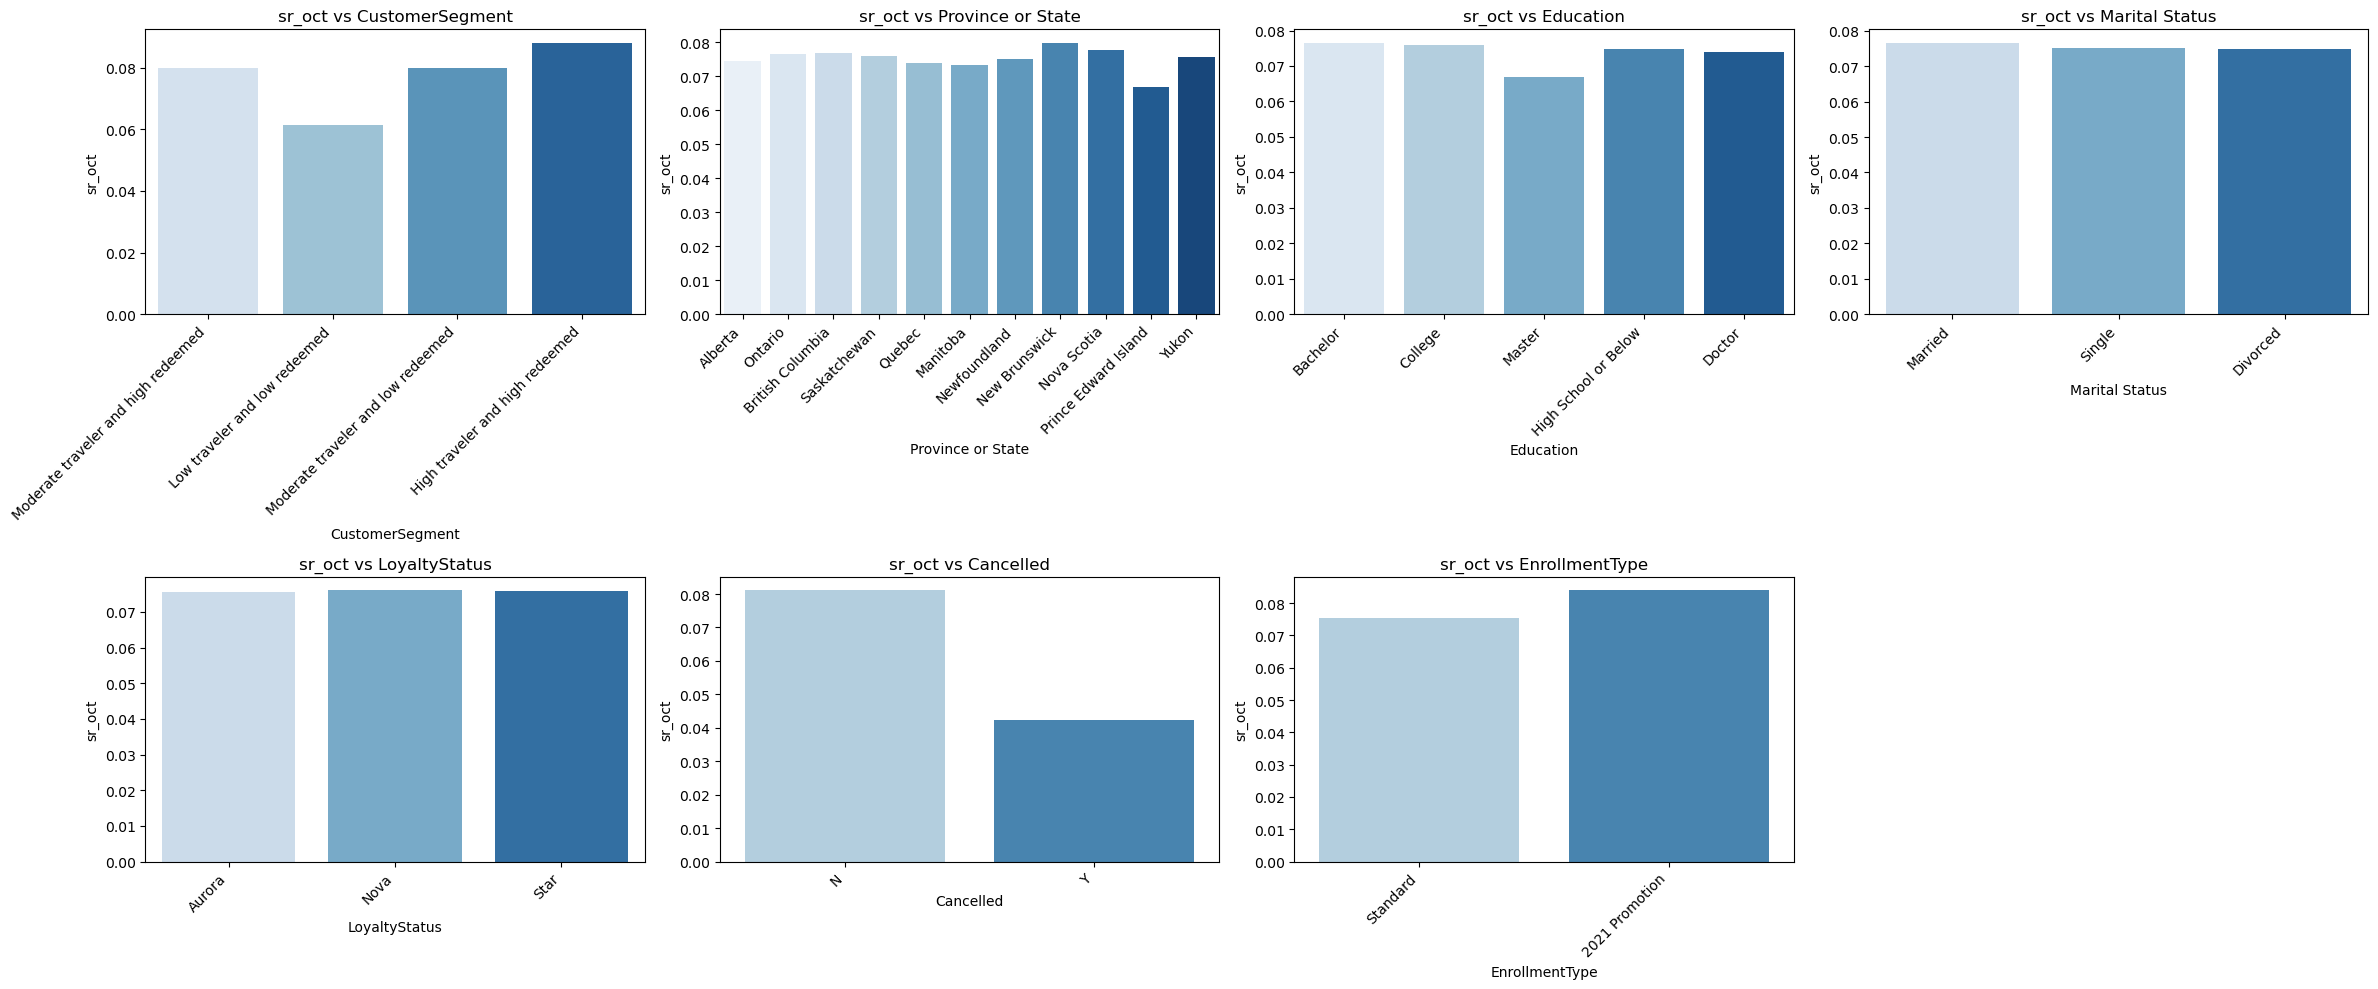

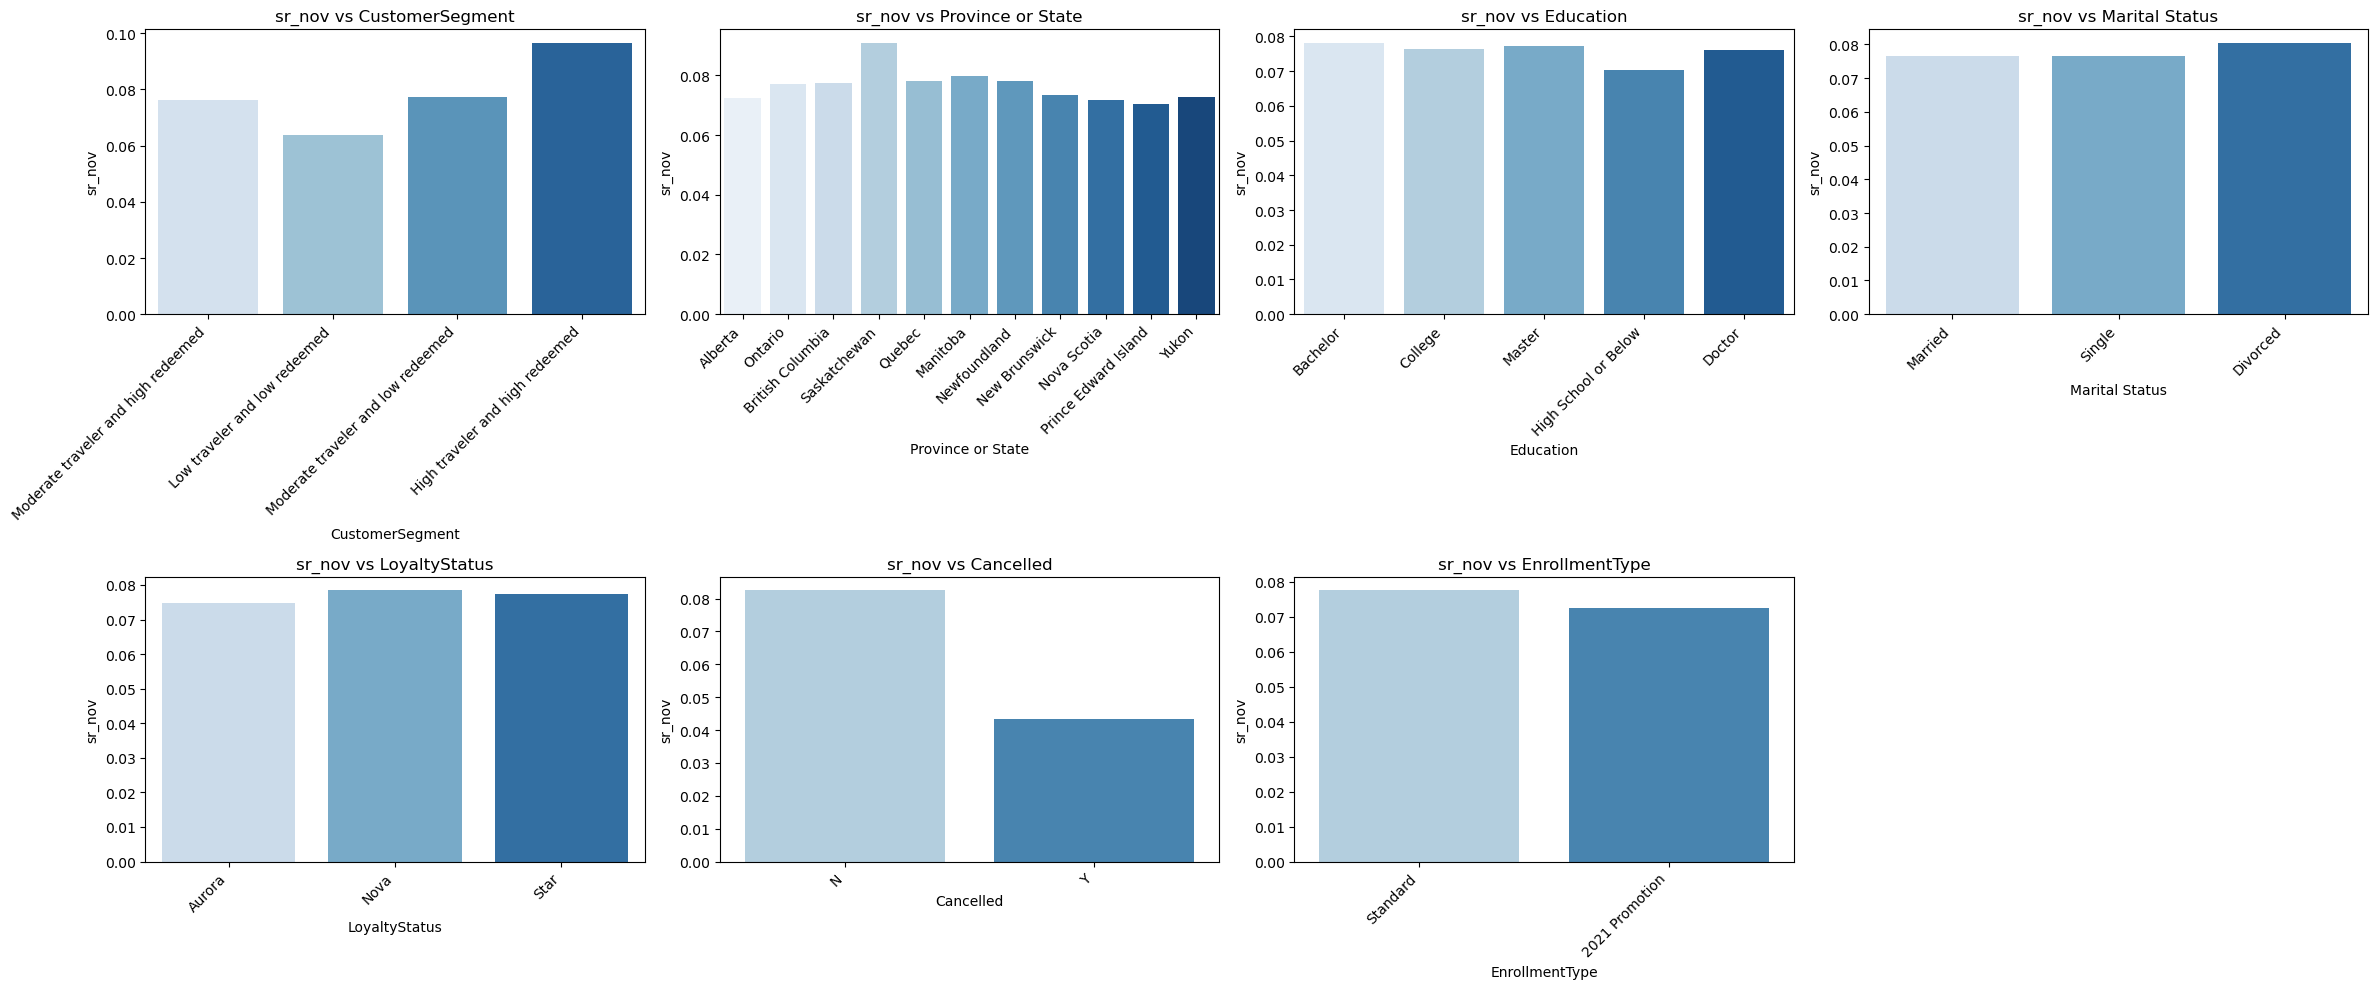

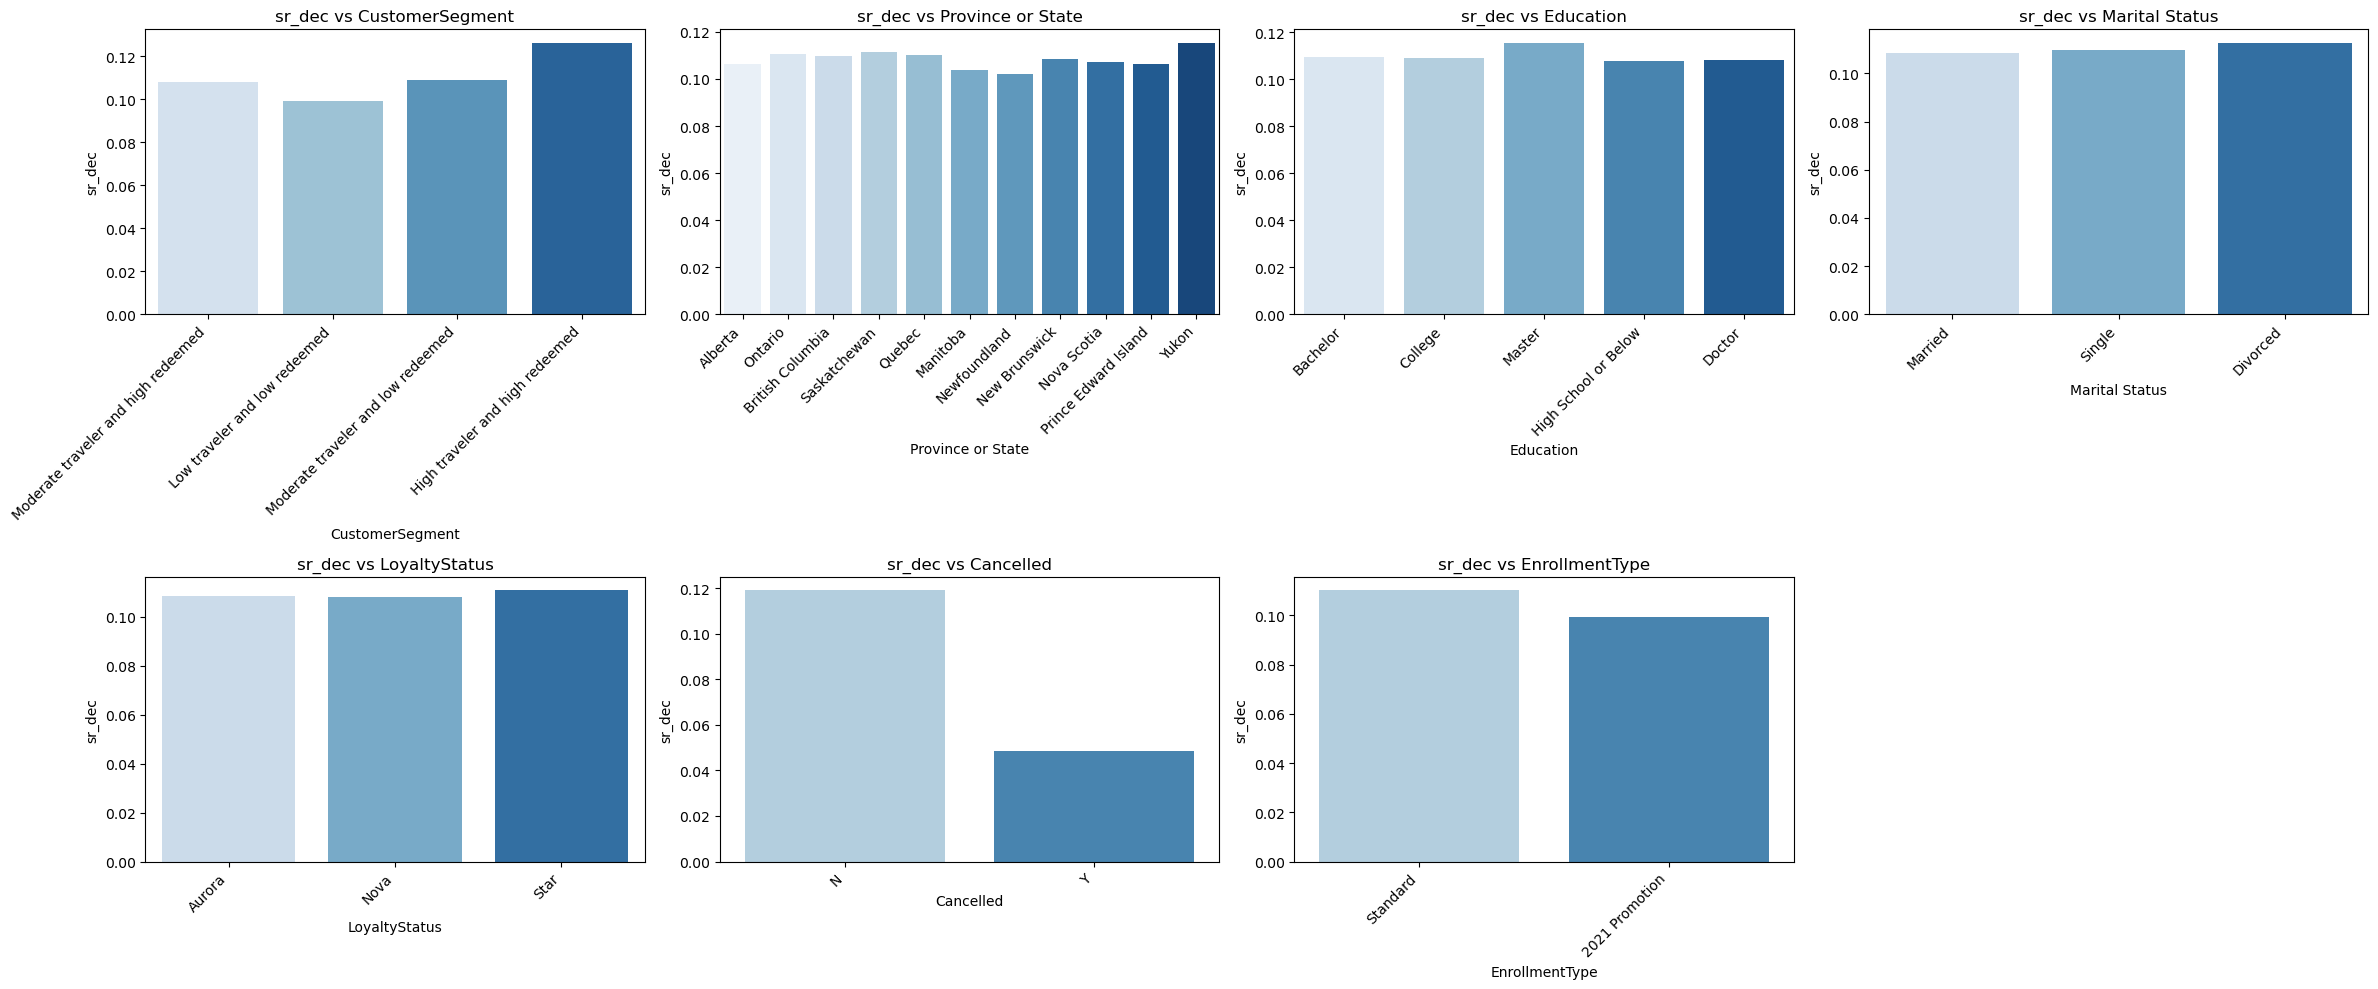

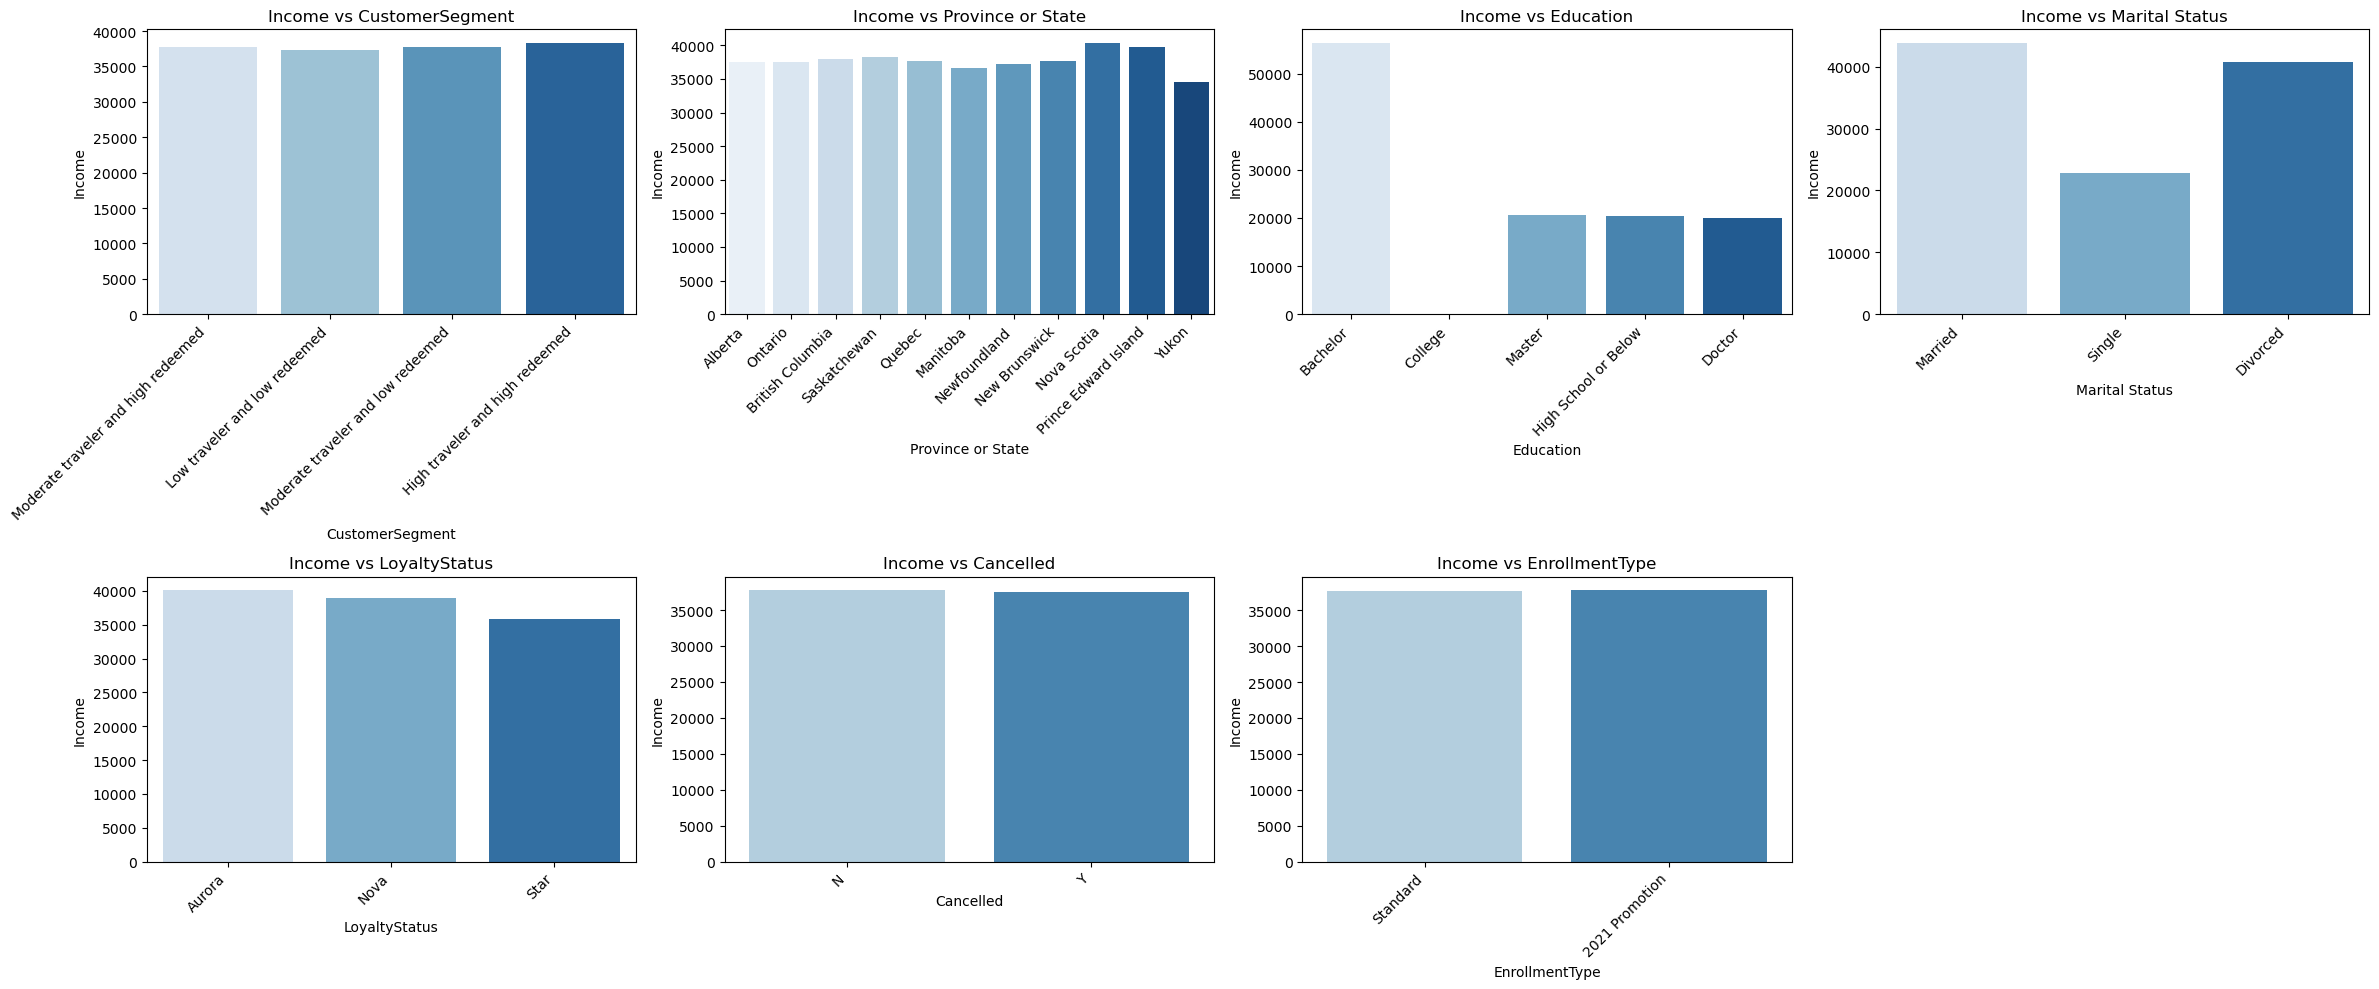

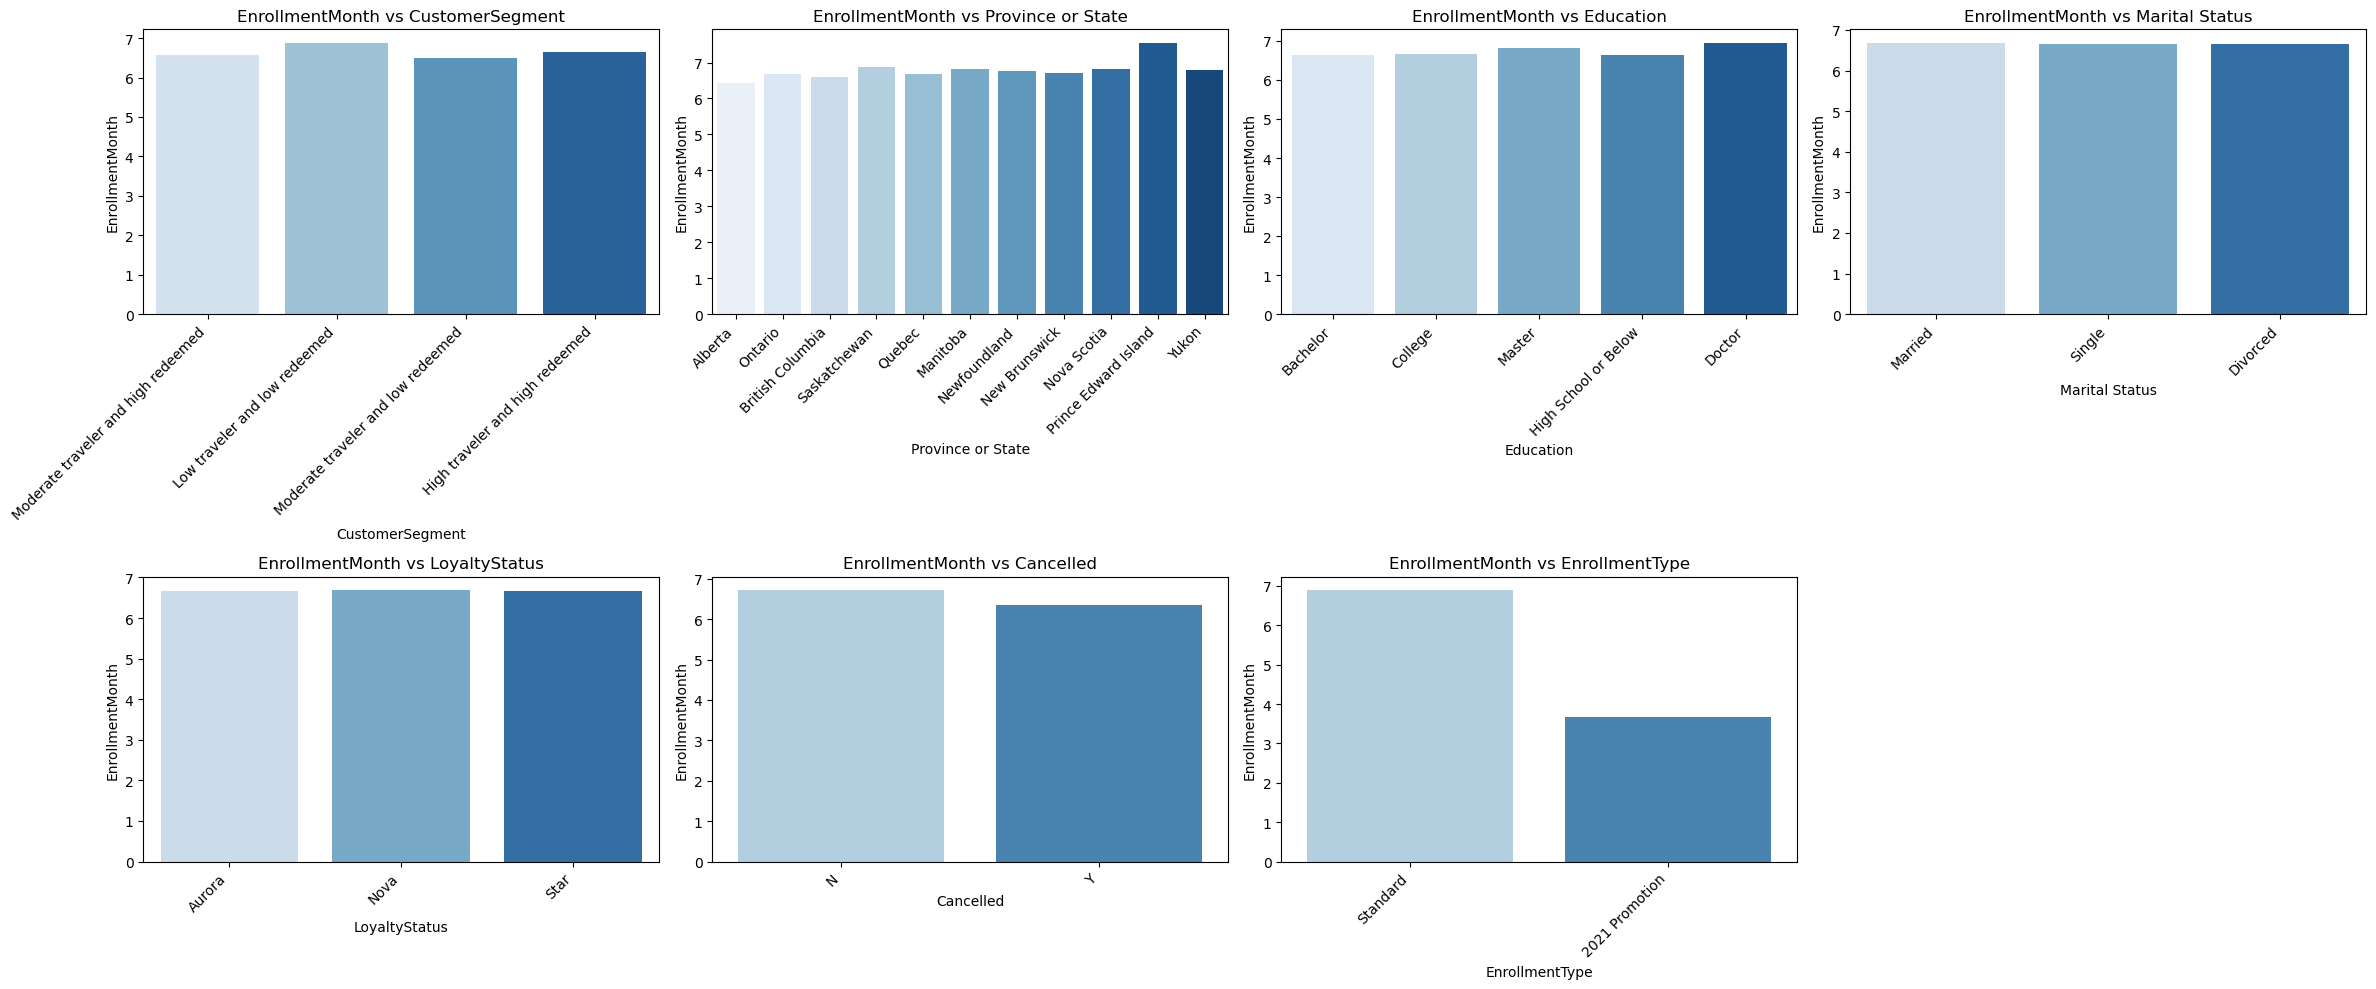

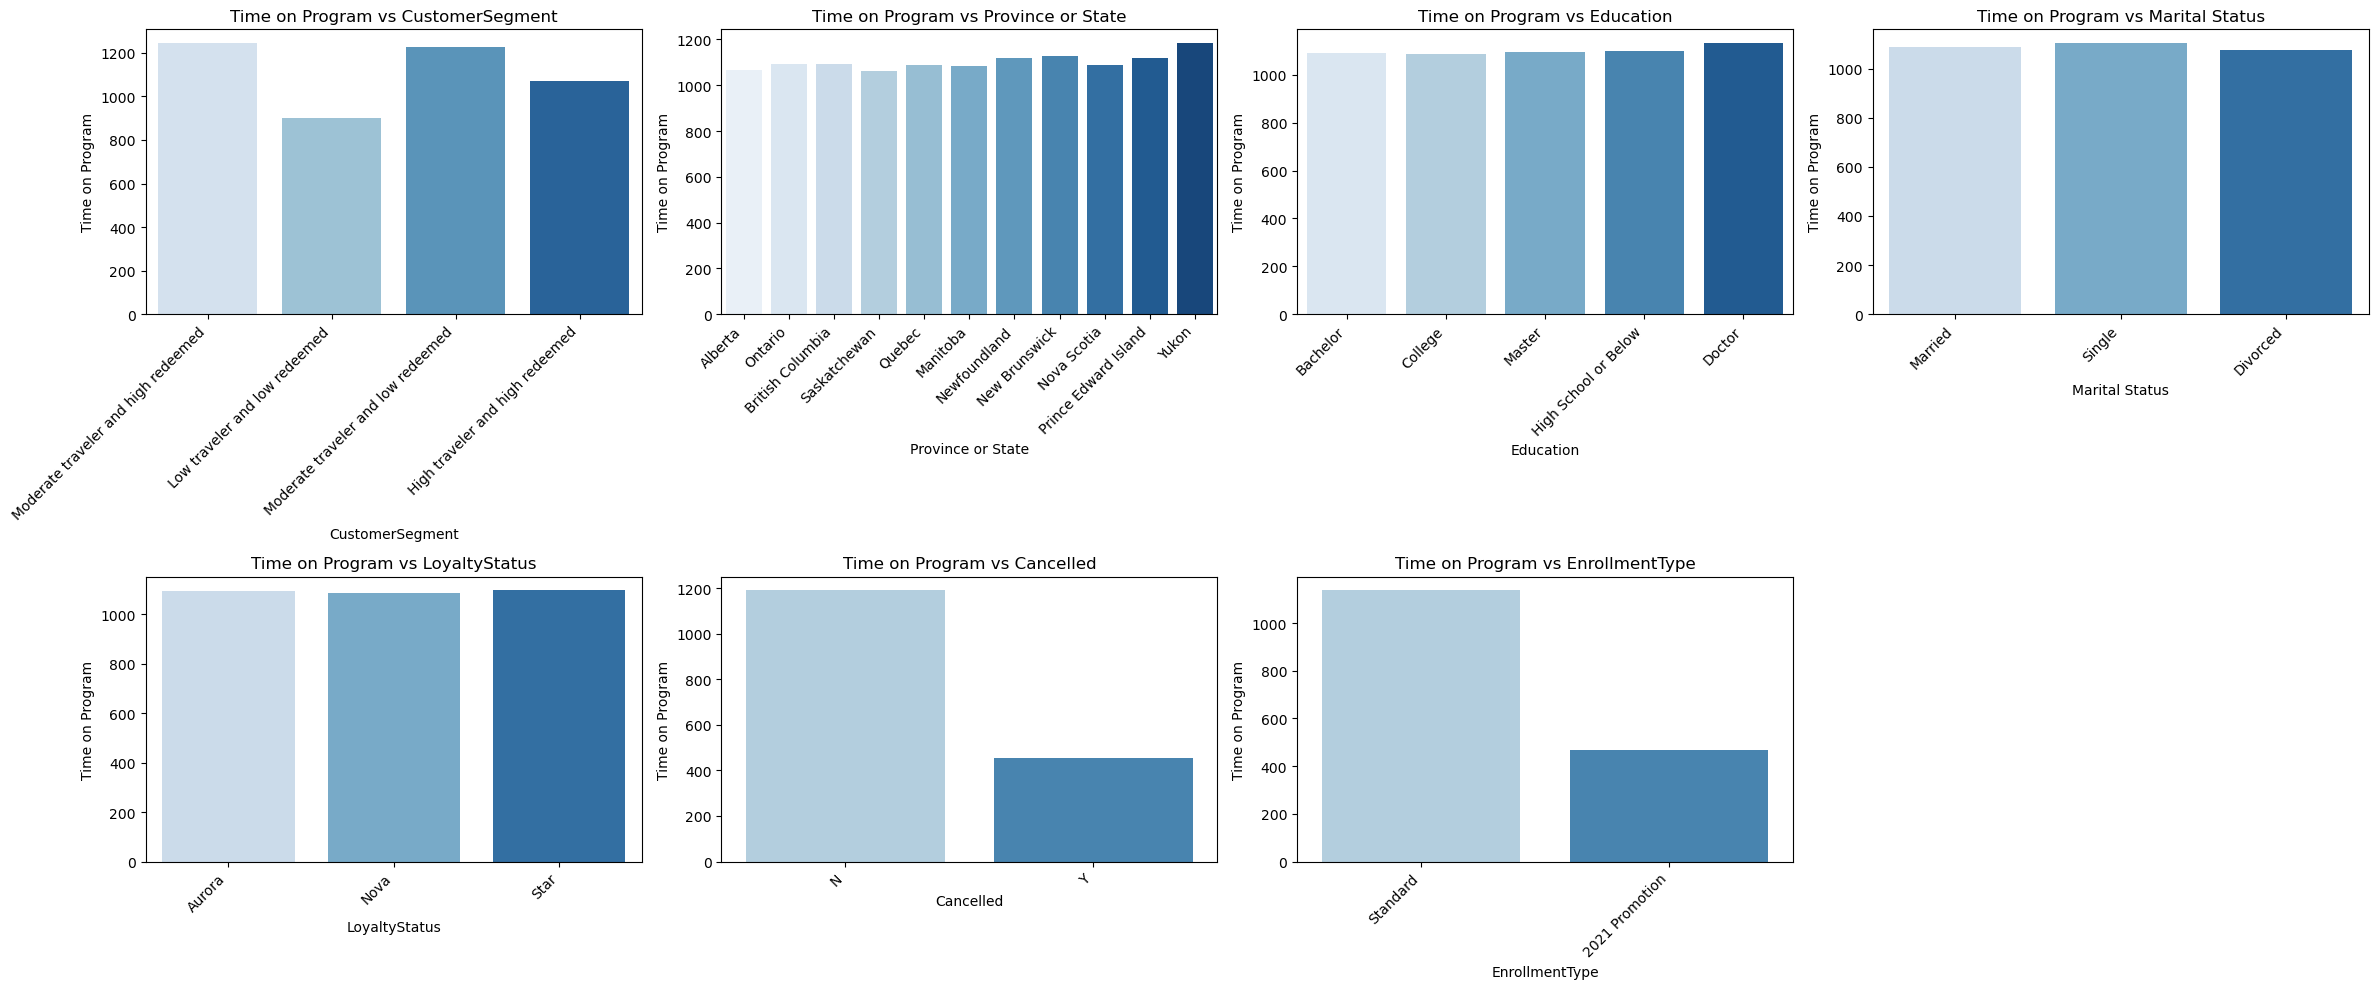

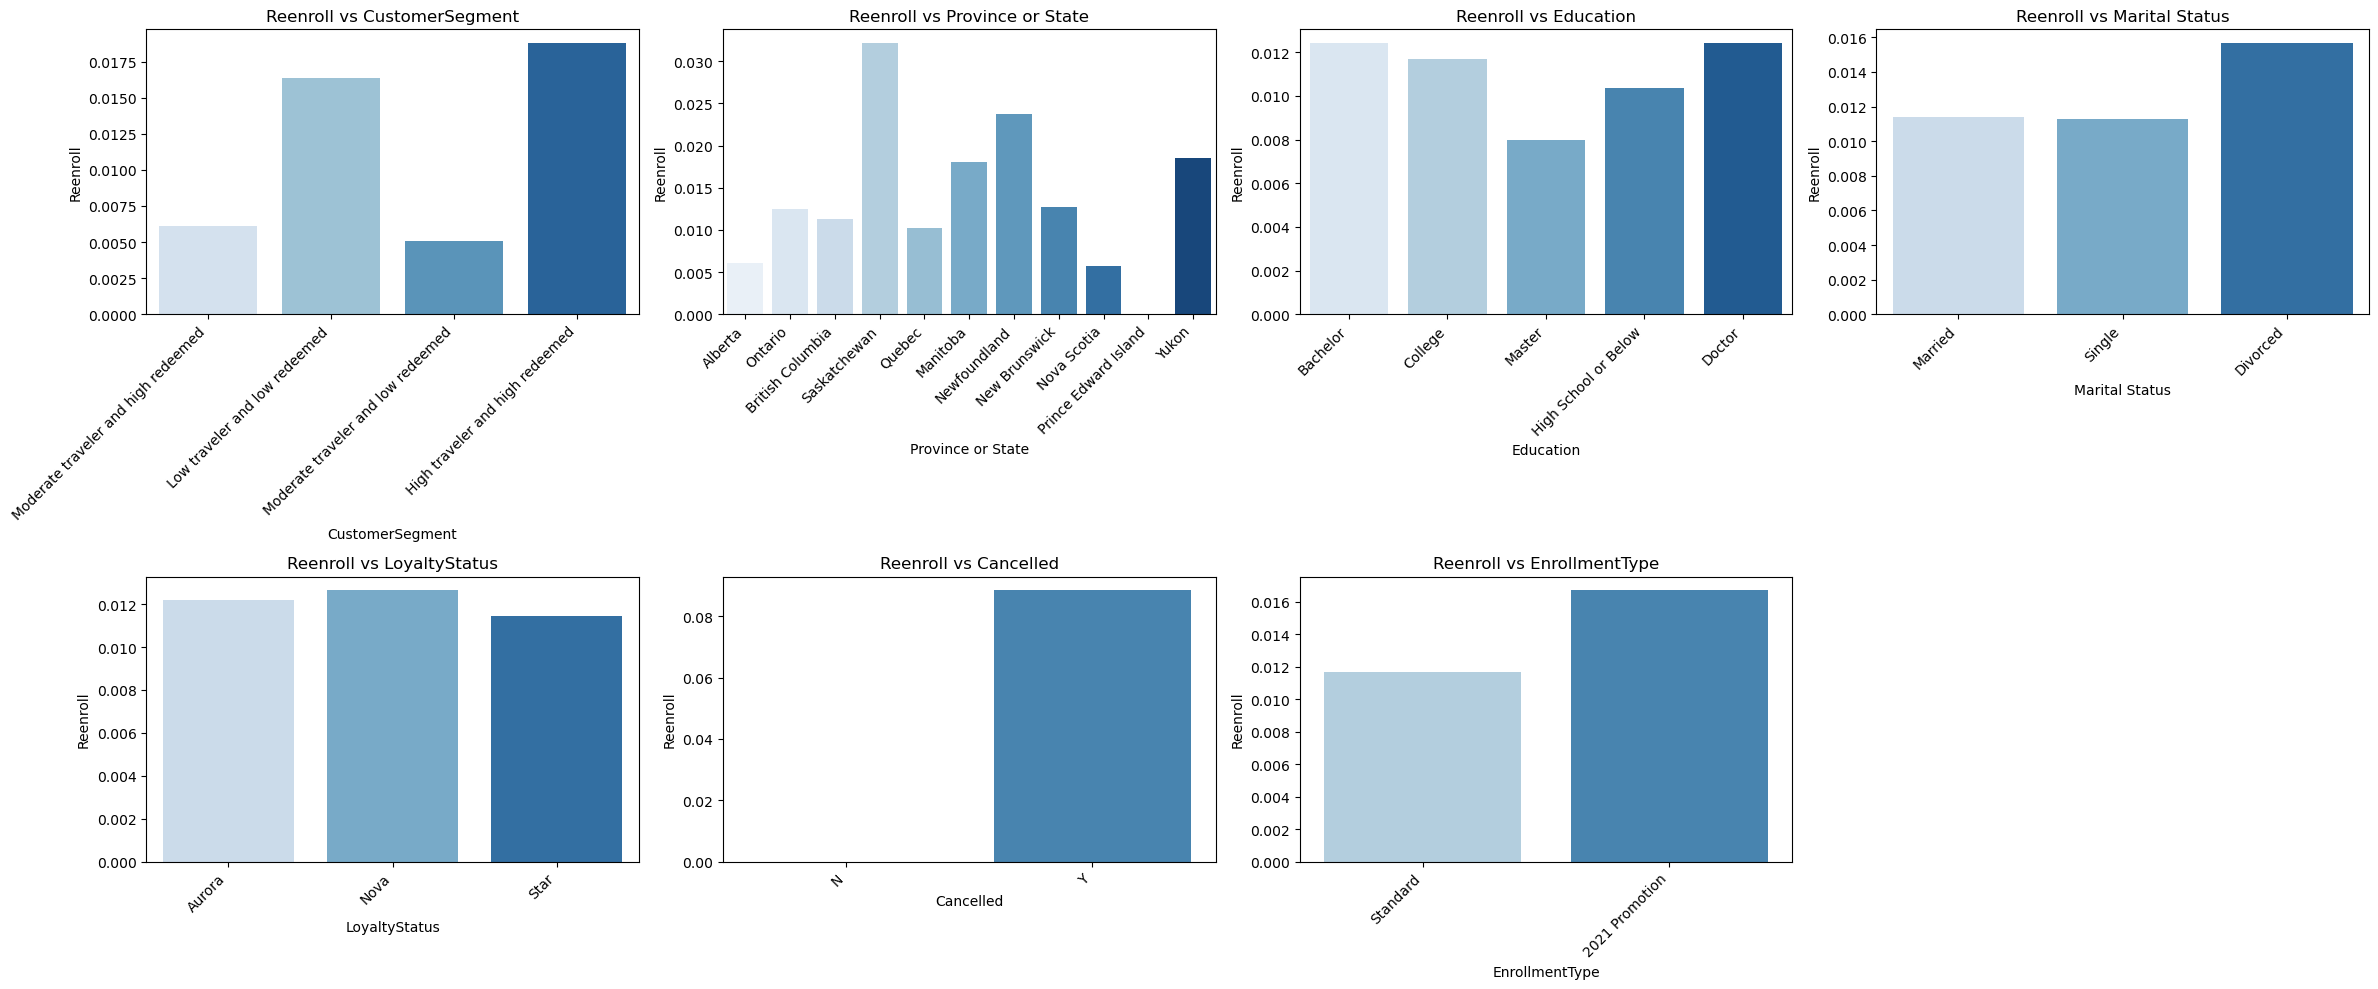

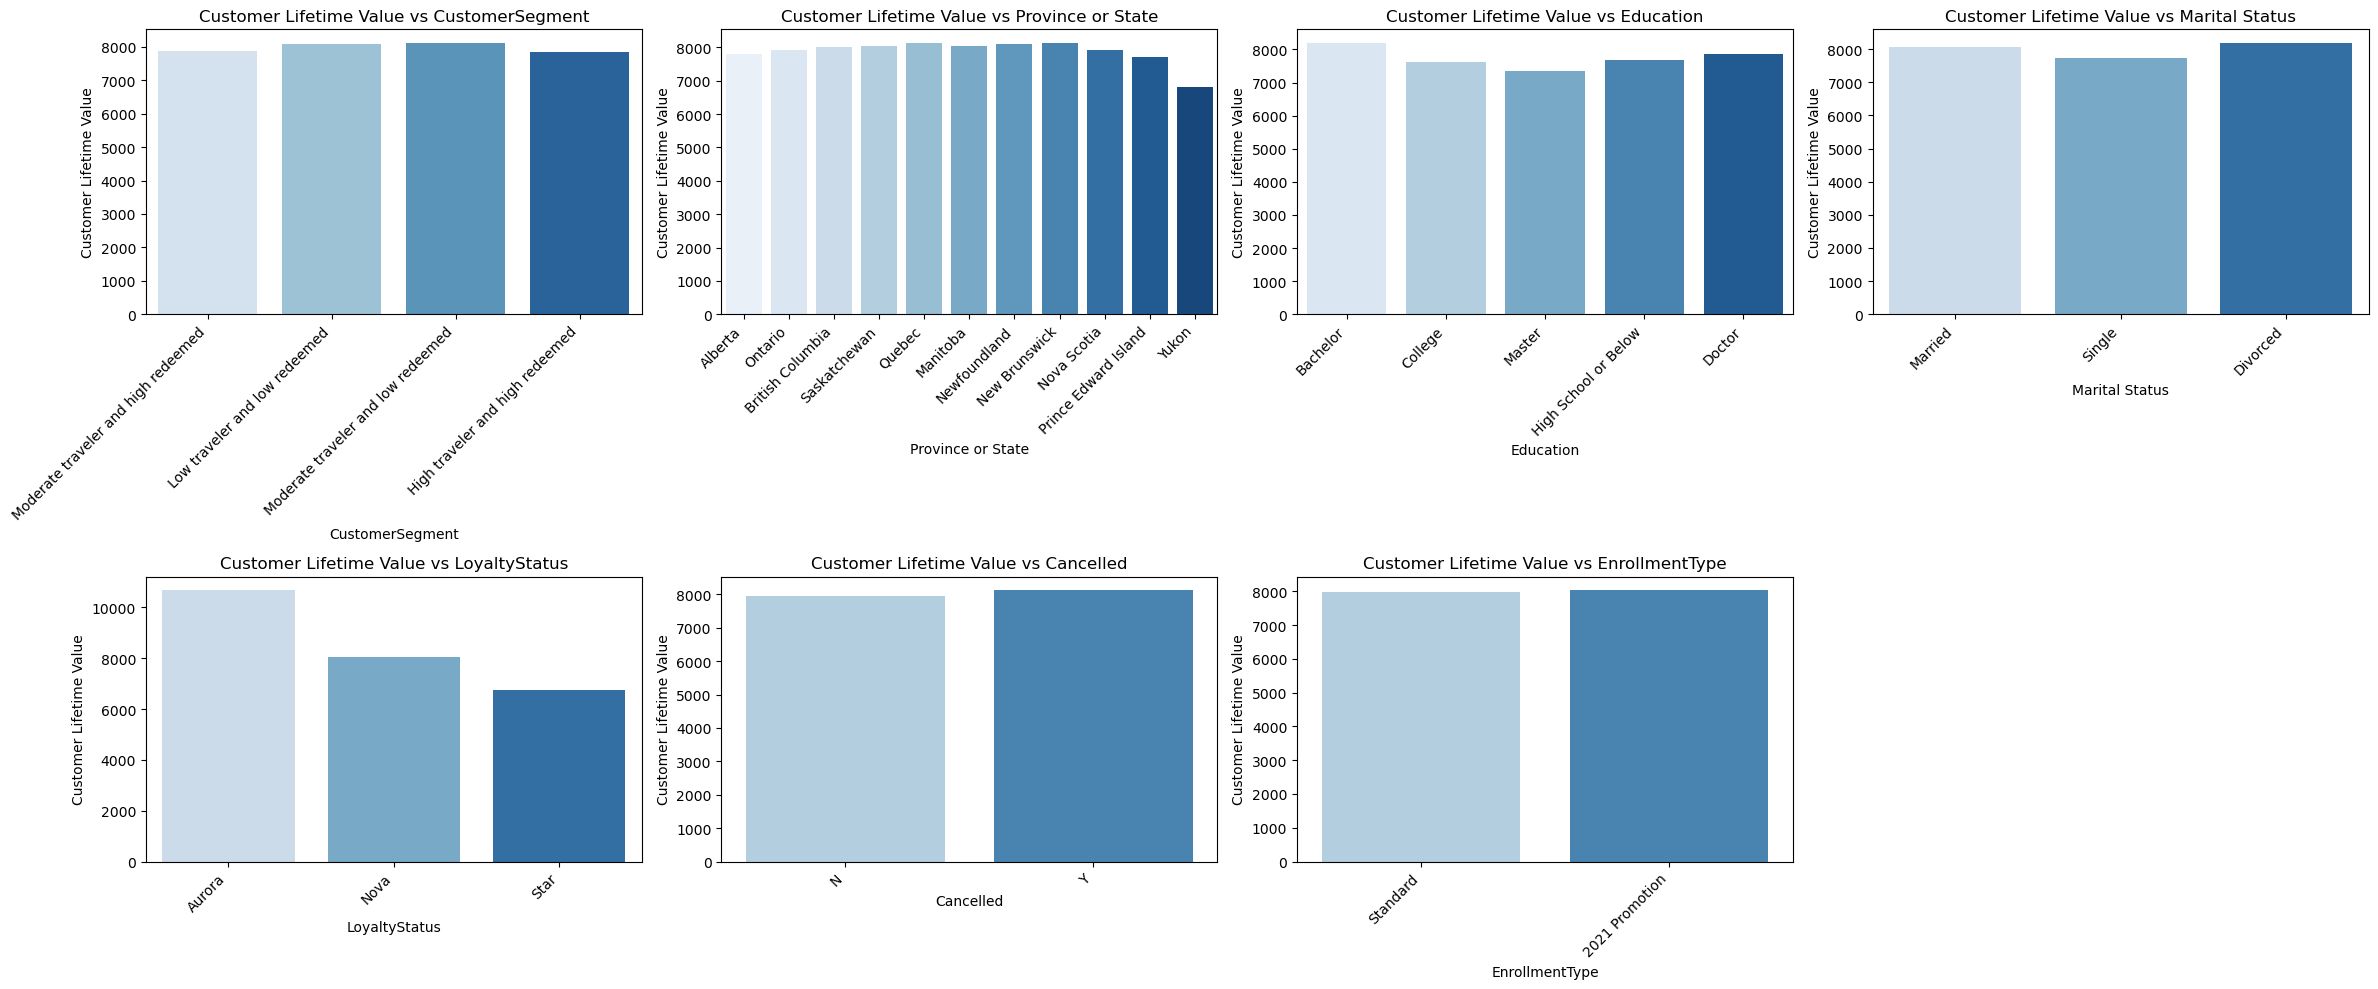

: 

In [ ]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
plots_per_row = 4  

numeric_df = [col for col in numeric_df if col != "Loyalty#"]

for num_col in numeric_df:
    total_plots = len(categorical_cols)
    rows = math.ceil(total_plots / plots_per_row)
    
    fig, axes = plt.subplots(rows, plots_per_row, figsize=(6*plots_per_row, 5*rows))
    axes = axes.flatten() if total_plots > 1 else [axes]
    
    for i, cat_col in enumerate(categorical_cols):
        sns.barplot(
            x=cat_col,
            y=num_col,
            data=df,
            ax=axes[i],
            palette="Blues",
            ci=None
        )
        axes[i].set_title(f"{num_col} vs {cat_col}")
        axes[i].set_xlabel(cat_col)
        axes[i].set_ylabel(num_col)
        plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()


Gender does not to seem provide any meaningful information and separation in the dataset, so we will remove them.

In [ ]:
df = df.drop(columns=['Gender'])


KeyError: "['Gender'] not found in axis"

: 

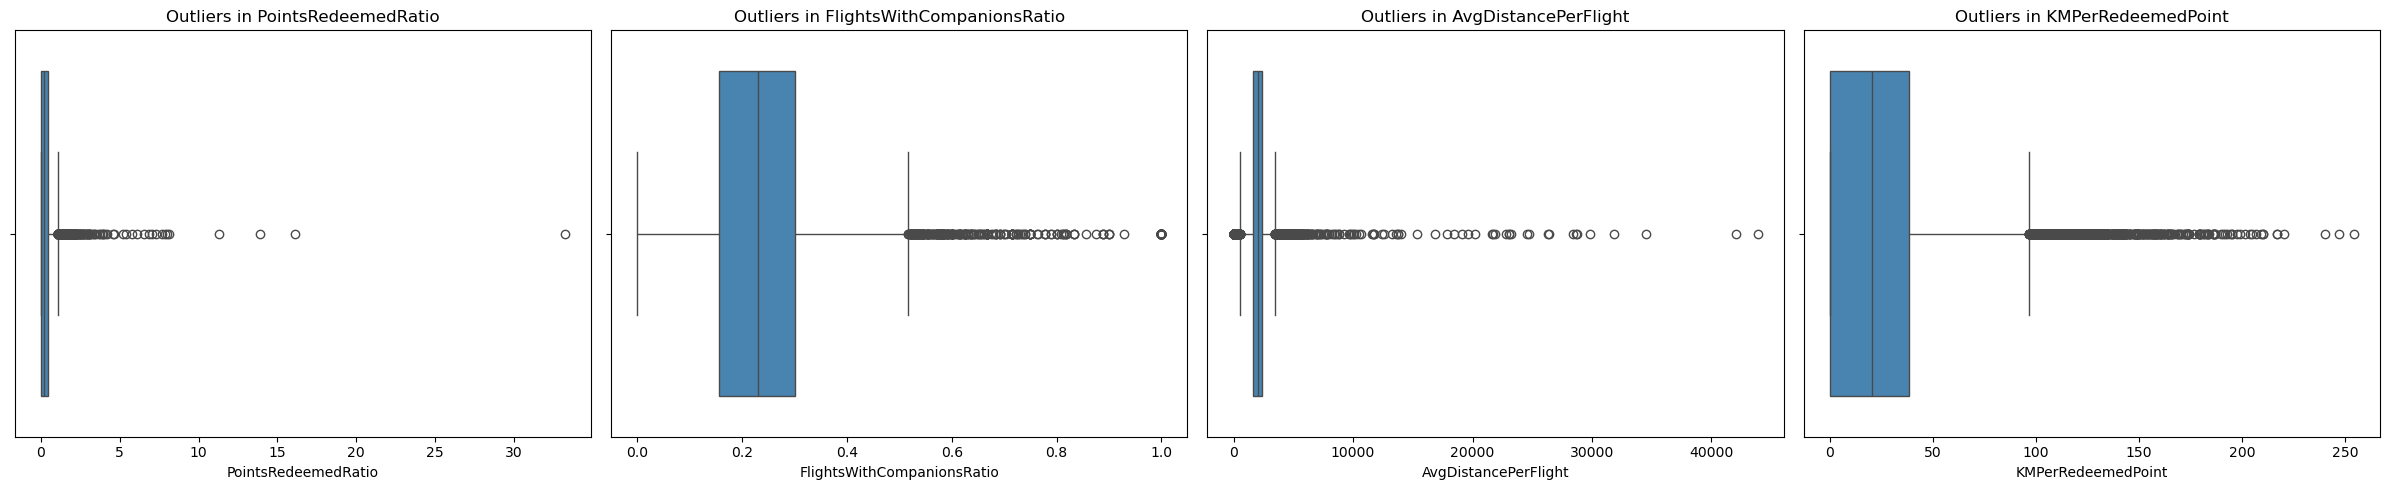

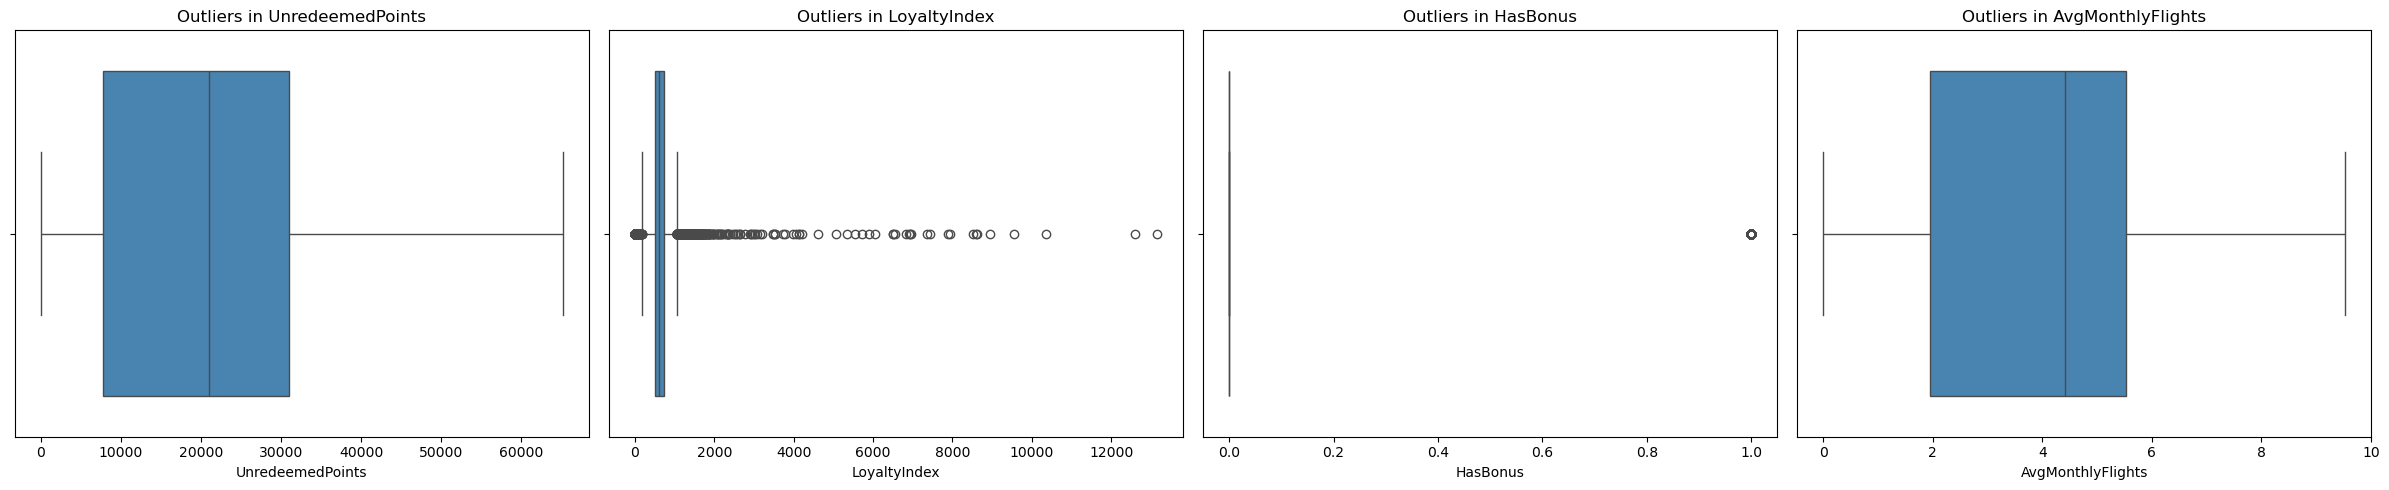

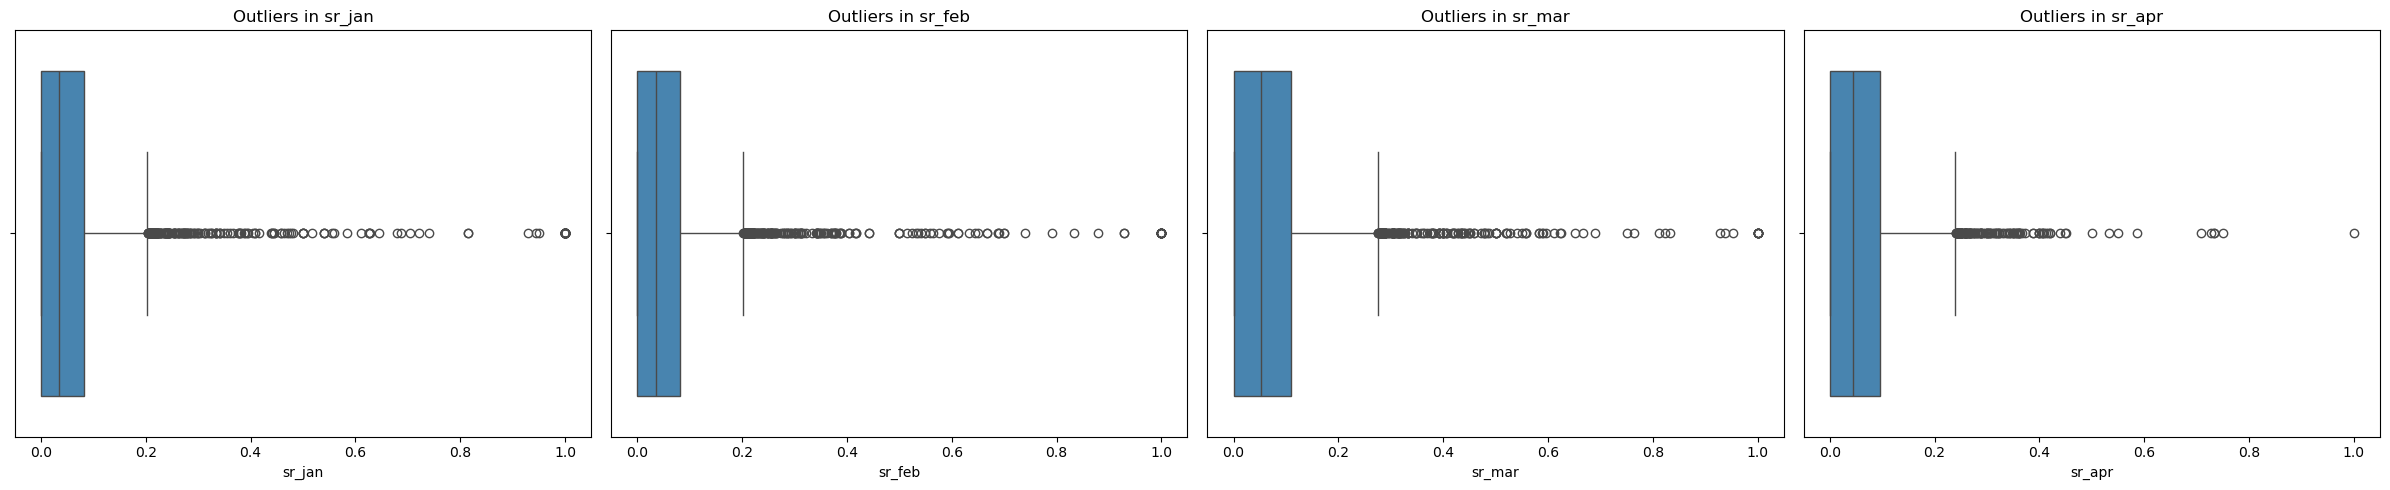

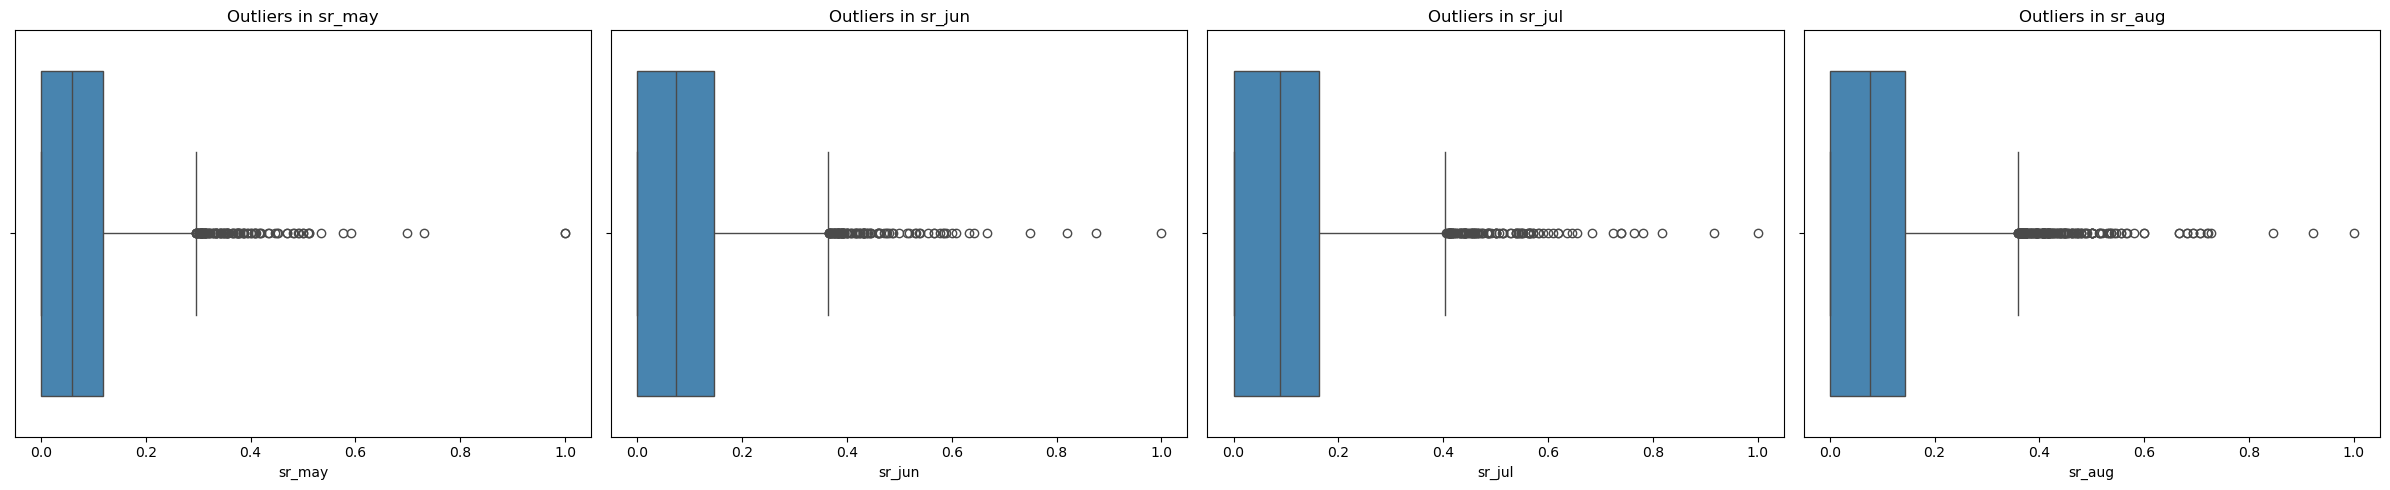

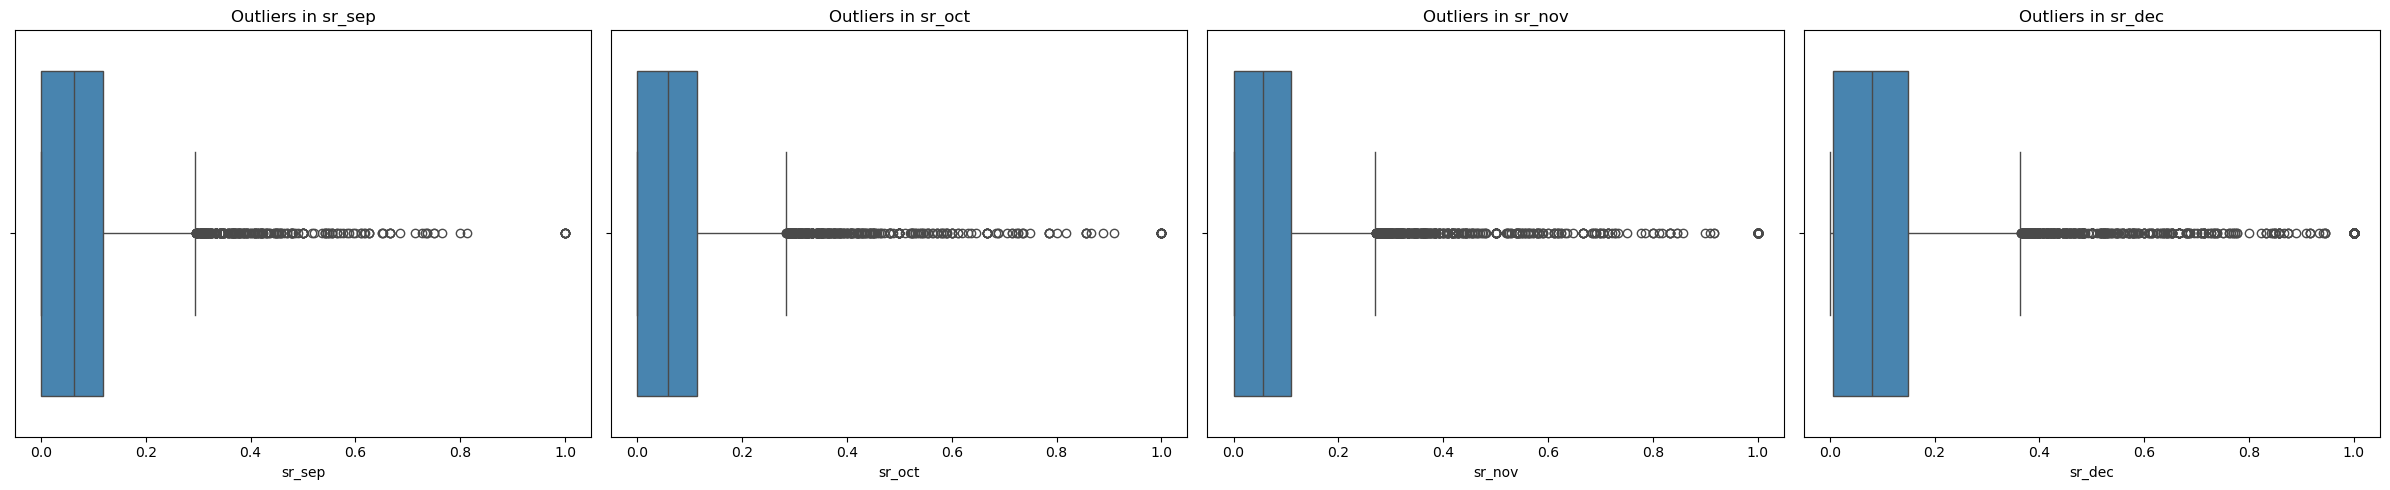

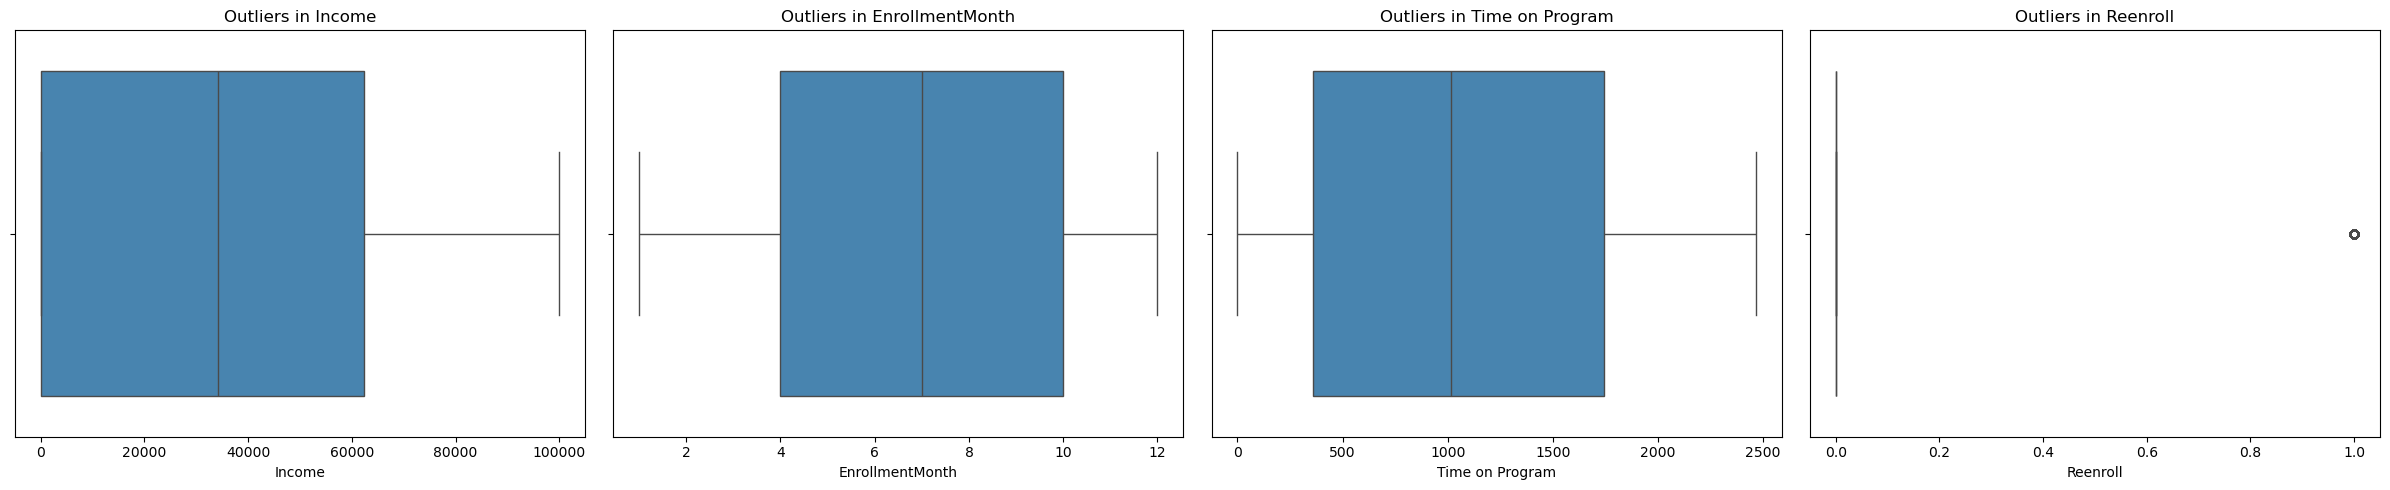

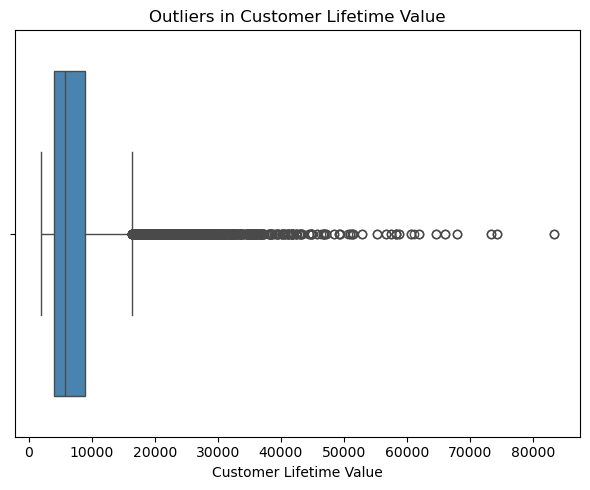

: 

: 

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plots_per_row = 4

# Take a consistent blue from the Blues palette
blue_color = sns.color_palette("Blues", 5)[3]

for i in range(0, len(numeric_cols), plots_per_row):
    subset_cols = numeric_cols[i:i + plots_per_row]
    fig, axes = plt.subplots(1, len(subset_cols), figsize=(6 * len(subset_cols), 5))
    
    if len(subset_cols) == 1:
        axes = [axes]
    
    for ax, col in zip(axes, subset_cols):
        sns.boxplot(
            x=df[col],
            ax=ax,
            color=blue_color,
            orient='h'
        )
        ax.set_title(f"Outliers in {col}")
        ax.set_xlabel(col)
    
    plt.tight_layout()
    plt.show()


In [ ]:
df.columns

Index(['PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'LoyaltyIndex', 'CustomerSegment', 'HasBonus', 'AvgMonthlyFlights',
       'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun', 'sr_jul',
       'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec', 'Province or State',
       'Education', 'Income', 'Marital Status', 'LoyaltyStatus',
       'EnrollmentMonth', 'Time on Program', 'Cancelled', 'Reenroll',
       'EnrollmentType', 'Customer Lifetime Value'],
      dtype='object')

: 

: 

In [ ]:
df = df.set_index('Loyalty#')
df.to_csv('df_ready_for_clustering.csv', index=False)

# Define column types
#binary_columns = ['EnrollmentType', 'Cancelled']
#frequency_column = 'Province or State'
#onehot_columns = ['CustomerSegment', 'Education', 'Marital Status', 'LoyaltyStatus']

# Get numerical columns (exclude categorical, datetime, and timedelta columns)
#all_categorical = binary_columns + [frequency_column] + onehot_columns

# Identify datetime and timedelta columns to exclude
#datetime_cols = df.select_dtypes(include=['datetime64', 'timedelta64']).columns.tolist()
#print(f"Datetime/Timedelta columns (will not be scaled): {datetime_cols}")

# Get only numeric columns that are not categorical or datetime
#numerical_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
#numerical_cols = [col for col in numerical_cols if col not in all_categorical]

#print(f"Numerical columns to scale: {numerical_cols}")

# 1. MINMAX SCALING on numerical columns directly in df
#if len(numerical_cols) > 0:
#    scaler = MinMaxScaler()
#    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
#    print(f" Scaled {len(numerical_cols)} numerical columns")

# 2. BINARY ENCODING directly in df
#for col in binary_columns:
#    if col in df.columns:
#        df[col] = (df[col] == df[col].unique()[1]).astype(int)
#        print(f" Binary encoded: {col}")

#if frequency_column in df.columns:
#    freq_map = df[frequency_column].value_counts(normalize=True)  # normalize=True gives proportion
#    df[frequency_column] = df[frequency_column].map(freq_map)
#    print(f"Frequency (proportion) encoded: {frequency_column}")

# 4. ONE-HOT ENCODING directly in df
#for col in onehot_columns:
#    if col in df.columns:
        # Create dummy variables
#        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        # Convert to int explicitly
#        dummies = dummies.astype(int)
        # Drop original column
#        df.drop(col, axis=1, inplace=True)
        # Add dummy columns directly to df
#        for dummy_col in dummies.columns:
#            df[dummy_col] = dummies[dummy_col]
#        print(f"✓ One-hot encoded: {col} -> {len(dummies.columns)} new columns")

# 5. CONVERT ALL REMAINING BOOLEAN COLUMNS TO INT
#bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
#if len(bool_cols) > 0:
#    df[bool_cols] = df[bool_cols].astype(int)
#    print(f"Converted {len(bool_cols)} boolean columns to int (0/1)")

#print("\n" + "="*60)
#print(f"Transformation complete")
#print(f"Final df shape: {df.shape}")
#print(f"Datetime columns kept as-is: {datetime_cols}")
#print(f"NaN count: {df.isnull().sum().sum()}")
#print(f"\nData types in df:")
#print(df.dtypes.value_counts())

KeyError: "None of ['Loyalty#'] are in the columns"

: 

: 